# ADA2017 project, milestone 3 <a class="tocSkip">
This notebook is an extension of the milestone 2 notebook. It is very long and contains explorations into the data that didn't end up in the final data story. However, these explorations are also interesting and were omitted simply to keep the data story coherent and to avoid overwhelming the reader with information.

Be prepared for an extensive read.

# Data processing pipeline

In [1]:
# To use Spark 1.6.3 in Jupyter Notebook we have to use Python 3.4
!python --version

Python 3.6.1 :: Anaconda custom (64-bit)


In [2]:
# USER to determine spark and dataset directories
import getpass
USER = getpass.getuser()
if USER == 'Tarmo':
    SPARK_DIR = 'C:/Users/Tarmo/Documents/Lausanne/CS-401_applied_data_analysis/spark/spark-1.6.3-bin-hadoop2.6'
    DATASET_DIR = 'C:/Users/Tarmo/Documents/Lausanne/data/Books_5.json'
    METADATA_DIR = 'C:/Users/Tarmo/Documents/Lausanne/data/meta_Books.json'
elif USER == 'adam':
    SPARK_DIR = '/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'
    DATASET_DIR = '/media/adam/B236CB1D36CAE209/Studia/ADA/reviews_Books_5.json'
    METADATA_DIR = '/media/adam/B236CB1D36CAE209/Studia/ADA/meta_Books.json'
else:
    SPARK_DIR = '/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'

In [3]:
SPARK_DIR

'/home/adam/EPFL_courses/spark-1.6.3-bin-hadoop2.6'

## Import libraries

### Spark libraries

In [4]:
import findspark
findspark.init(SPARK_DIR)

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import to_date, unix_timestamp, from_unixtime  #to_timestamp, pyspark 2.2 functiona 

### The others

In [2]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import resample
from scipy import stats
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import json
import re
import json 
import gzip
from collections import Counter
import operator

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

/home/adam/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Collection and aggregation of data
Loading and processing the data to see what it contains. To make further processing faster, we create intermediate well-structured csv files to avoid having to process the JSON data files every time we want to look at the data. We take a look at several different metrics and their aggregates in the data (review length, review number; by day, by month, by year, by book, etc.)

## Initialization of Spark and SQL context

In [6]:
sc = SparkContext()
sqlContext = SQLContext(sc)

sc.version

'1.6.3'

### Loading of dataset and metadata

In [8]:
# Load the dataset and create RDDs
text_file = sc.textFile(DATASET_DIR)
# Convert previously read text file to json DataFrame
df = sqlContext.read.json(text_file)

# Load metadata for dataset and convert it to DataFrame
metadata = sc.textFile(METADATA_DIR)
metadata_df = sqlContext.read.json(metadata)

# Register DataFrames as tables to use those names in SQL-type queries
sqlContext.registerDataFrameAsTable(metadata_df, "metadata")
sqlContext.registerDataFrameAsTable(df, "dataset")

In [109]:
# Number of RDDs
text_file.getNumPartitions()

282

In [110]:
# Number of records in the dataset
text_file.count()

8898041

In [9]:
# Schema of the dataset
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



### Initial data processing

In [10]:
# Bunch of castings, reviewTime: string->date, unixReviewTime: int->timestamp
# We do this to be able to better filter and manipulate the data
df = df.withColumn('unixReviewTime', from_unixtime(df['unixReviewTime']))
df = df.withColumn('reviewTime', to_date(df['unixReviewTime']))
df = df.withColumn('unixReviewTime', df['unixReviewTime'].cast('timestamp'))
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: date (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: timestamp (nullable = true)



In [113]:
# Look at couple of records, just to be sure that we obtained what we wanted
df.select("reviewTime", 'reviewText', 'unixReviewTime').take(2)

[Row(reviewTime=datetime.date(2012, 12, 16), reviewText='Spiritually and mentally inspiring! A book that allows you to question your morals and will help you discover who you really are!', unixReviewTime=datetime.datetime(2012, 12, 16, 1, 0)),
 Row(reviewTime=datetime.date(2003, 12, 11), reviewText="This is one my must have books. It is a masterpiece of spirituality. I'll be the first to admit, its literary quality isn't much. It is rather simplistically written, but the message behind it is so powerful that you have to read it. It will take you to enlightenment.", unixReviewTime=datetime.datetime(2003, 12, 11, 1, 0))]

## Average length of reviews per day

In [ ]:
# Computing an average length of review per day
aTuple = (0, 0)
avg = df.select("reviewTime", 'reviewText').rdd.map(lambda row: (row.reviewTime, len(row.reviewText)))
avg = avg.aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg = avg.mapValues(lambda v: v[0]/v[1])
avg = avg.collect()

In [ ]:
# Processing acquired data using Pandas
avg_len = pd.DataFrame(avg, columns=['Date', 'Avg_length'])
avg_len['Date'] = pd.to_datetime(avg_len['Date'])
avg_len.set_index('Date', inplace=True)
avg_len.sort_index(inplace=True)
avg_len.head()

In [ ]:
# Save to file not to compute this one more time
avg_len.to_csv("avg_length_review_by_day.csv")

In [6]:
avg_len = pd.read_csv("avg_length_review_by_day.csv", index_col='Date', parse_dates=['Date'])
avg_len.head()

Avg_length
Date                  
1996-05-20      1752.0
1996-06-25      1123.0
1996-08-17       826.0
1996-09-18       897.0
1996-11-15      1757.0

## Average length of reviews per month

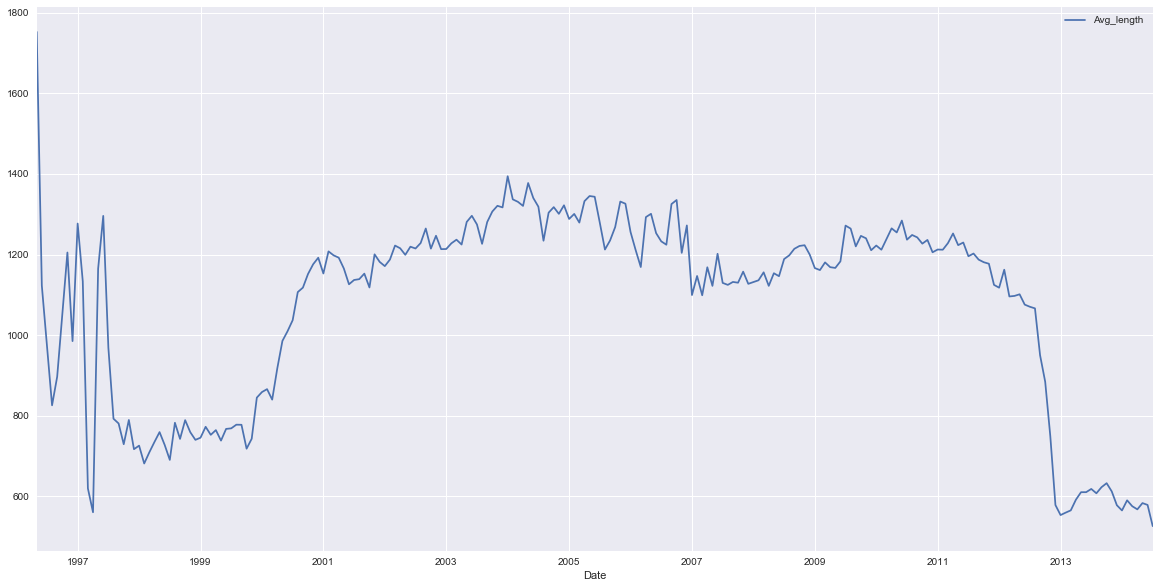

In [115]:
monthly_data = avg_len.groupby(avg_len.index.to_period('M')).mean()
monthly_data.plot(figsize=(20,10))

We notice that the average review length per month appears to have three somewhat stable levels in time: before 2000, between 2000 and 2013 and after 2013. In the middle period the review length is consistently high, and crashes around 2012-2013. In the beginning of the dataset time period, the number of reviews is small so there is high variation in monthly average.

### Average length of reviews between 2012 and 2013

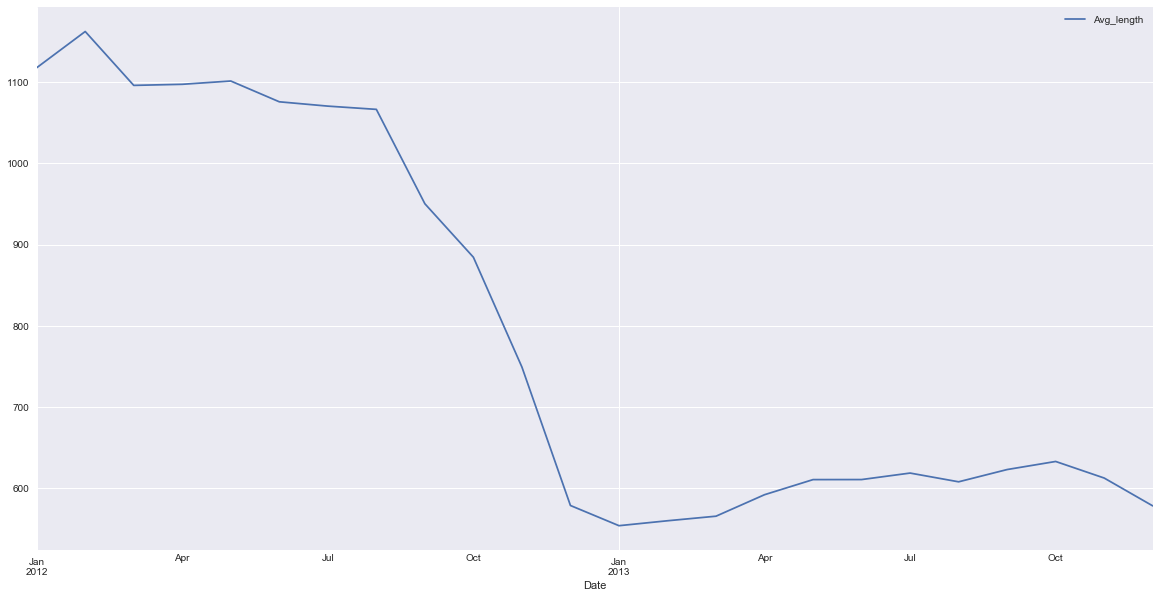

In [116]:
monthly_data['2012':'2013'].plot(figsize=(20,10))

The extreme drop is located between August 2012 and January 2013.

In [ ]:
# Save processed data
monthly_data.to_csv("avg_length_review_by_month.csv")

In [ ]:
# (Successful) attempt to filter by timestamp 
tmp = df.rdd.filter(lambda row: row.unixReviewTime > pd.to_datetime('2012-05')
                     and row.unixReviewTime < pd.to_datetime('2013'))
tmp.take(5)

## Number of reviews per each day

In [ ]:
# Number of reviews per each day
number_of_reviews = df.rdd.map(lambda row: (row.reviewTime, 1)).reduceByKey(lambda a, b: a+b).collect()

In [ ]:
# Processing the data
rev_num = pd.DataFrame(number_of_reviews, columns=['Date', 'Number of reviews'])
rev_num['Date'] = pd.to_datetime(rev_num['Date'])
rev_num.set_index('Date', inplace=True)
rev_num.sort_index(inplace=True)
rev_num.head()

In [ ]:
# Save the data not to compute over and over
rev_num.to_csv("number_of_reviews_per_day.csv")

In [9]:
# Read file with the data
rev_num = pd.read_csv("number_of_reviews_per_day.csv", index_col='Date', parse_dates=['Date'])
rev_num.tail()

Number of reviews
Date                         
2014-07-19               2797
2014-07-20               3332
2014-07-21               3456
2014-07-22               2697
2014-07-23                619

## Number of reviews per month

In [ ]:
monthly_data_reviews = rev_num.groupby(rev_num.index.to_period('M')).sum()
# Save the processed data
monthly_data_reviews.to_csv("number_of_reviews_per_month.csv")

In [422]:
# Read file with the data
monthly_data_reviews = pd.read_csv("number_of_reviews_per_month.csv", index_col='Date', parse_dates=['Date'])

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


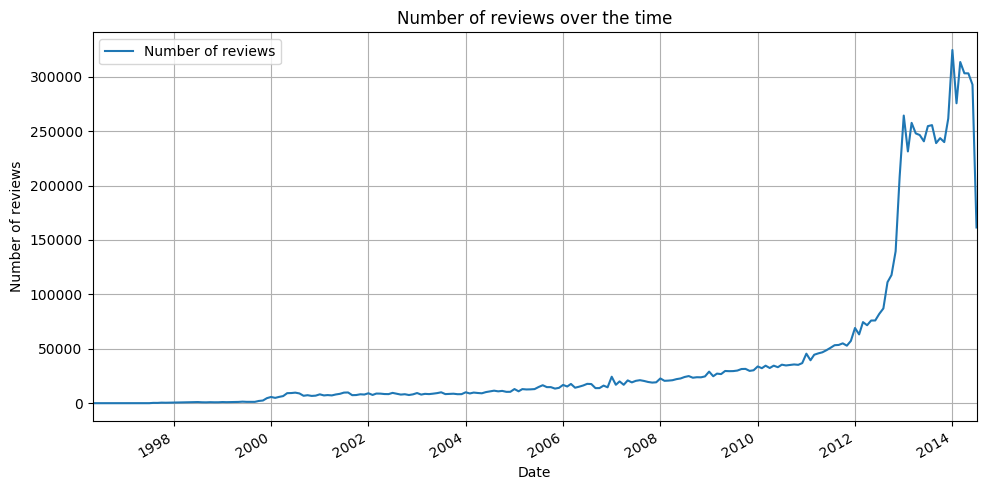

In [425]:
monthly_data_reviews.plot(figsize=(10,5))
plt.grid()
plt.title("Number of reviews over the time")
plt.ylabel("Number of reviews")
plt.savefig("./images/number_of_reviews_over_time.png", transparent=True)
plt.show()

We see that in the beginning of the data period, there are hardly any reviews being written. The number of reviews increases consistently until there is a huge jump after 2012. The extreme increase coincides with the drop in the average review length, and may reflect a sudden change in reviewer numbers and/or behavior. The apparent increase might also be due to changes in Amazon review policies: after a significant change, Amazon might retroactively remove old reviews not conforming to the new policy.

## Number of reviews per book

In [ ]:
number_of_reviews_per_book = df.rdd.map(lambda row: (row.asin, 1)).reduceByKey(lambda a, b: a+b).collect()
len(number_of_reviews_per_book)

In [ ]:
# Processing the data using Pandas and saving it to csv file
df_number_of_reviews_per_book = pd.DataFrame(number_of_reviews_per_book, columns=['Book_id', 'Number of reviews'])
df_number_of_reviews_per_book.sort_values('Number of reviews', ascending=False, inplace = True)
df_number_of_reviews_per_book.to_csv("number_of_reviews_per_book.csv", index=False)
df_number_of_reviews_per_book.head(10)

In [55]:
# Read file with the data
df_number_of_reviews_per_book = pd.read_csv("number_of_reviews_per_book.csv", index_col='Book_id')

In [56]:
df_number_of_reviews_per_book.describe()

Number of reviews
count      367982.000000
mean           24.180642
std            66.303046
min             5.000000
25%             6.000000
50%            10.000000
75%            21.000000
max          7440.000000

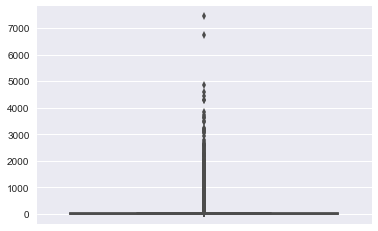

In [129]:
# Boxplot of numbers of reviews
sns.boxplot(np.array(df_number_of_reviews_per_book['Number of reviews'].values), orient='v')

The boxplot is not very box-like, since most books have only a small number of reviews.

We look at the numbers without the outliers:

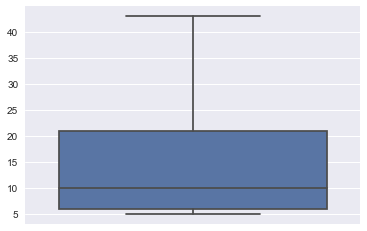

In [130]:
sns.boxplot(np.array(df_number_of_reviews_per_book['Number of reviews'].values), orient='v', showfliers=False)

In [131]:
# Basic statistics for this variable
stats.describe(df_number_of_reviews_per_book['Number of reviews'].values)

DescribeResult(nobs=367982, minmax=(5, 7440), mean=24.180641987923323, variance=4396.0938613274502, skewness=25.747403776095645, kurtosis=1461.9790549248125)

## Top 30 books based on the number of reviews
Our time-independent popularity metric is the number of reviews, so we take a closer look at the top 30 books according to it.

In [ ]:
top_books = df.rdd.map(lambda row: (row.asin, 1)).reduceByKey(lambda a, b: a+b).sortBy(lambda wc: -wc[1]).take(30)

top_books_df = sqlContext.createDataFrame(top_books, ['asin', 'rew_num'])
sqlContext.registerDataFrameAsTable(top_books_df, "top_books")
top_books_df.take(5)

In [ ]:
# Join the dataset table with the metadata table to see titles of the most popular books
sqlContext.sql("select t.asin, m.title from metadata m join top_books t on m.asin=t.asin").collect()

In [ ]:
sqlContext.sql("select t.asin, m.title from metadata m join top_books t limit 10").collect()

### Two methods of filtering by ids of books

In [ ]:
most_reviewed_books_id_top = df_number_of_reviews_per_book[:30]
most_reviewed_top = df.rdd.filter(lambda row: row.asin in list(most_reviewed_books_id_top.Book_id))
            .map(lambda row: (row.asin, row.reviewTime)).collect()

In [ ]:
most_reviewed_top_2 = sqlContext.sql("select asin, reviewTime from dataset where asin in " + 
               str(tuple(most_reviewed_books_id_top.Book_id)))

### Processing the data for top30 books

In [ ]:
# Processing the data using Pandas
most_reviewed_books_top30_df = pd.DataFrame(most_reviewed_top, columns=['asin', 'reviewTime'])
# Convert to datetime type
most_reviewed_books_top30_df['reviewTime'] = pd.to_datetime(most_reviewed_books_top30_df['reviewTime'])
# Assign number of review to compute the sum
most_reviewed_books_top30_df['Number_of_reviews'] = 1
# Create monthly period for aggregation purpose
most_reviewed_books_top30_df['Year-month'] = most_reviewed_books_top30_df['reviewTime'].dt.to_period('M')
most_reviewed_books_top30_df.head()

In [ ]:
# Save data describing number of reviews per day for each book in top30
most_reviewed_books_top30_df.groupby(['asin', 'reviewTime']).sum()
                            .to_csv("number_of_reviews_per_day_top30_books.csv")

In [ ]:
# Aggregating the data by month
m_rev_books_by_month = most_reviewed_books_top30_df.groupby(['asin', 'Year-month'], as_index=True).sum()
m_rev_books_by_month.to_csv("number_of_reviews_per_month_top30_books.csv")

In [2]:
m_rev_books_by_month = pd.read_csv("number_of_reviews_per_month_top30_books.csv").set_index(['asin', 'Year-month'])

### Multi-line plot for top30 books - timeseries of reviews per month

In [3]:
number_of_reviews_per_month_top30_books_UNSTACKED_df = m_rev_books_by_month.unstack(level=0)

In [ ]:
number_of_reviews_per_month_top30_books_UNSTACKED_df.to_csv("number_of_reviews_per_month_top30_books_UNSTACKED.csv")

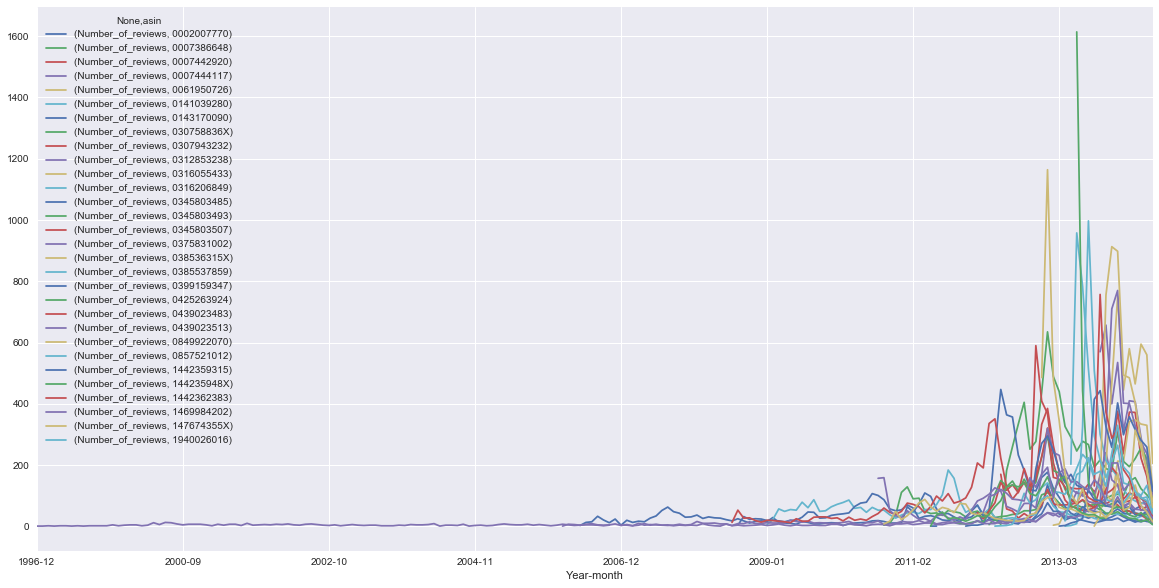

In [4]:
number_of_reviews_per_month_top30_books_UNSTACKED_df.plot(figsize = (20,10))

We see that for the top 30 books, most reviews are made after January 2013.

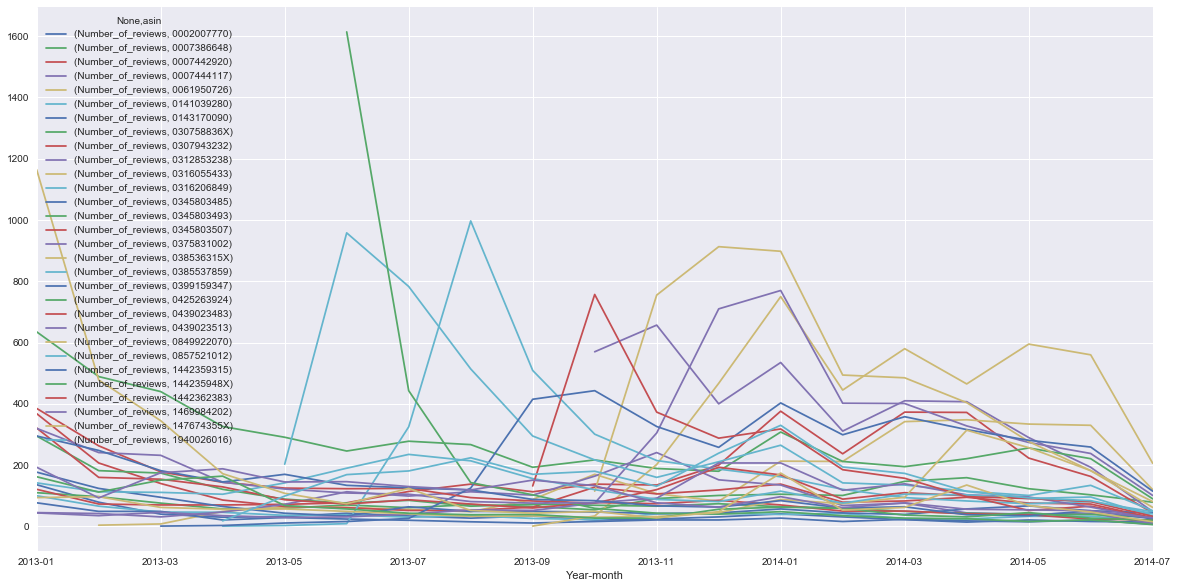

In [135]:
number_of_reviews_per_month_top30_books_UNSTACKED_df['2013':].plot(figsize = (20,10))

A top 30 book accrues a lot of reviews right after publication (or rather, appearance of first review). It is highly book-dependent whether this rate of reviewing drops quickly or slowly.

### Cumulated number of reviews for top 30 books

In [9]:
number_of_reviews_per_month_top30_books_cumsum_df = number_of_reviews_per_month_top30_books_UNSTACKED_df.cumsum()

In [11]:
number_of_reviews_per_month_top30_books_cumsum_df.shape

(192, 30)

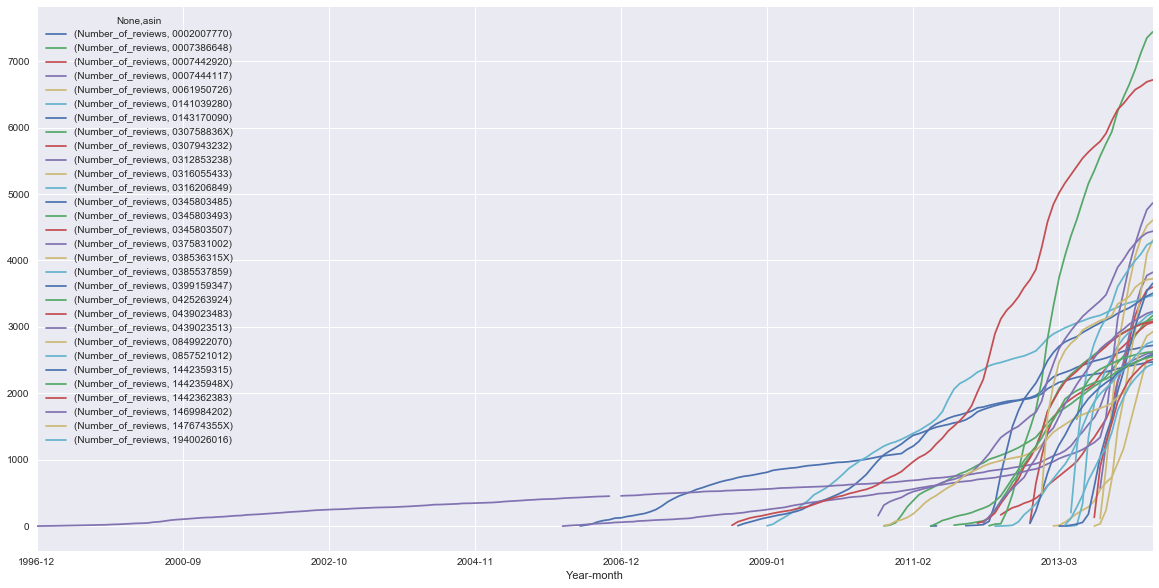

In [10]:
number_of_reviews_per_month_top30_books_cumsum_df.plot(figsize = (20,10))

## Average length and number of reviews per book

In [ ]:
aTuple = (0, 0)
avg_len_review = df.select('asin', 'reviewText').rdd.map(lambda row: (row.asin, len(row.reviewText)))
avg_len_review = avg_len_review.aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg_len_review = avg_len_review.mapValues(lambda v: (v[0]/v[1], v[1]))
avg_len_review = avg_len_review.collect()

In [ ]:
# Transformation of the data to be able to load it as a DataFrame 
avg_len_review = [(k, v1, v2) for k, (v1, v2) in avg_len_review]

In [ ]:
# Processing and saving to file
avg_len_review_per_book_df = pd.DataFrame(avg_len_review, columns=['Book_id', 'Avg_len', 'number_of_reviews'])
avg_len_review_per_book_df.sort_values(['Avg_len', 'number_of_reviews'], ascending=False, inplace=True)
avg_len_review_per_book_df.to_csv("avg_length_and_number_of_reviews_per_book.csv", index=False)
avg_len_review_per_book_df.head(10)

In [38]:
avg_len_review_per_book_df = pd.read_csv("avg_length_and_number_of_reviews_per_book.csv",index_col="Book_id")
avg_len_review_per_book_df.head()

Avg_len  number_of_reviews
Book_id                               
0195396170  13459.5                  6
0700619542   9934.8                  5
0061312118   9511.1                 10
0875522645   9377.8                  5
1405159286   8716.0                  9

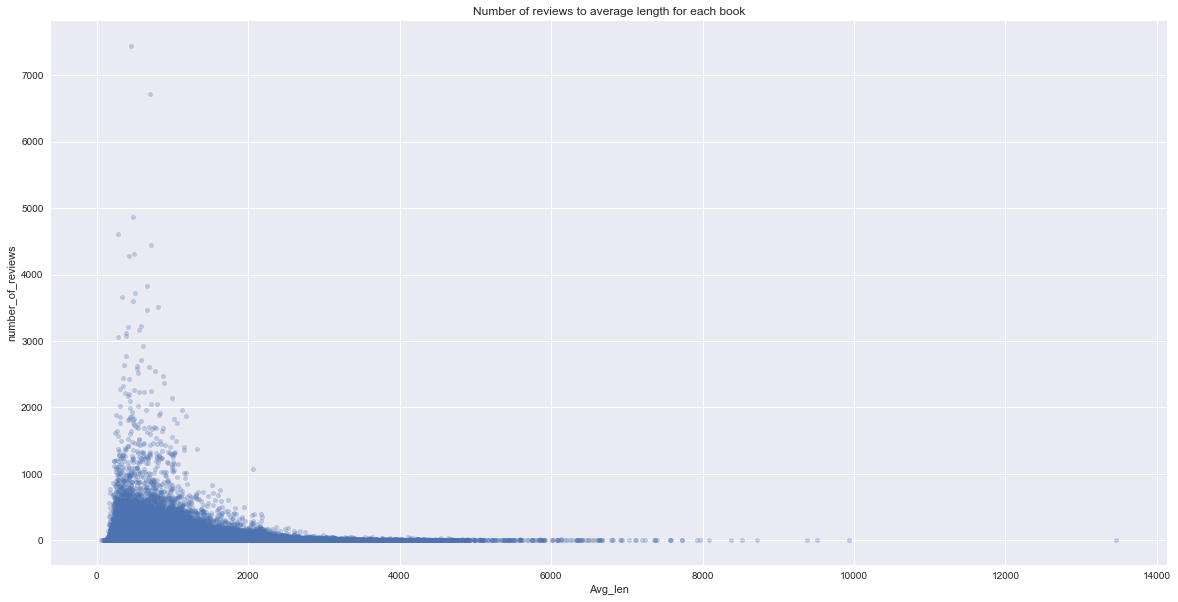

In [8]:
avg_len_review_per_book_df.plot(x = 'Avg_len', y = 'number_of_reviews', kind = 'scatter', figsize = (20,10), 
                       alpha = 0.3, title = 'Number of reviews to average length for each book')

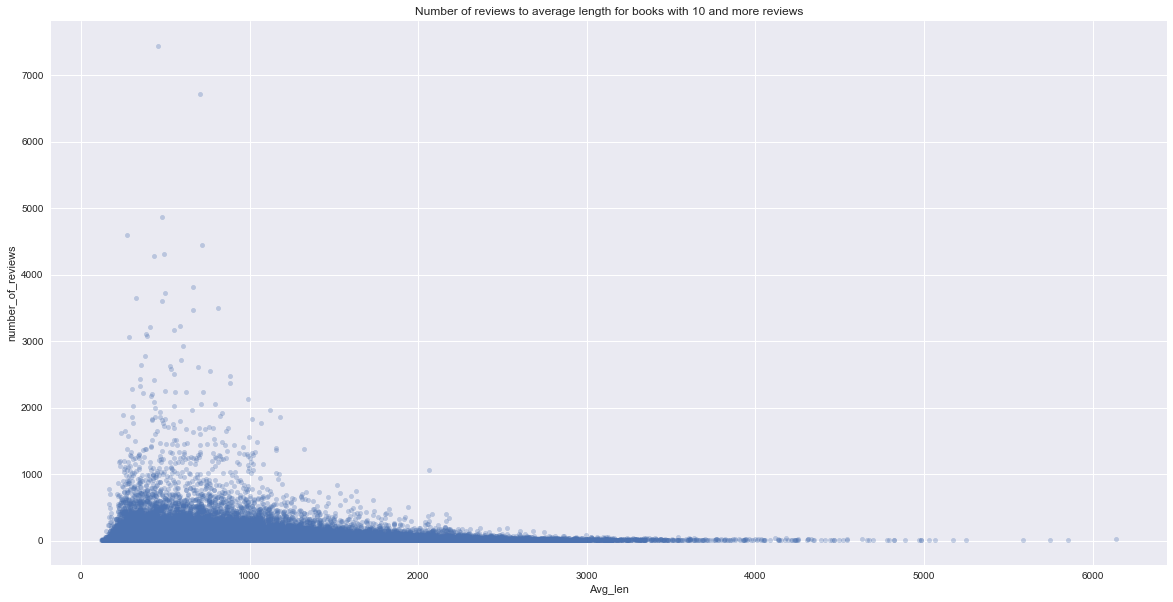

In [10]:
avg_len_review_per_book_df[avg_len_review_per_book_df['number_of_reviews'] > 10].plot(x = 'Avg_len', y = 'number_of_reviews', kind = 'scatter', figsize = (20,10), 
                       alpha = 0.3, title = 'Number of reviews to average length for books with 10 and more reviews')

## Collect reviews rating information
Book serial number, date of a review, rating, length of review.

In [14]:
ratings_with_length = df.select("asin", "unixReviewTime", "reviewerID", 'reviewText', 'overall', 'helpful').rdd.map(lambda row: (row.asin, row.unixReviewTime, row.reviewerID, len(row.reviewText), row.overall, row.helpful)).collect()

In [18]:
ratings_with_length_df = pd.DataFrame(ratings_with_length, columns = ["asin", "unixReviewTime", "reviewerID", 'review_length', 'overall', 'helpful'])
ratings_with_length_df['unixReviewTime'] = pd.to_datetime(ratings_with_length_df['unixReviewTime'])
ratings_with_length_df['overall']  = pd.to_numeric(ratings_with_length_df['overall'], downcast='unsigned')
ratings_with_length_df['review_length']  = pd.to_numeric(ratings_with_length_df['review_length'])
ratings_with_length_df.dtypes

In [ ]:
ratings_with_length_df['helpful_yes'] = ratings_with_length_df['helpful'].apply(lambda x: x[0])
ratings_with_length_df['helpful_yes']  = pd.to_numeric(ratings_with_length_df['helpful_yes'])
ratings_with_length_df['helpful_no'] = ratings_with_length_df['helpful'].apply(lambda x: x[1])
ratings_with_length_df['helpful_no']  = pd.to_numeric(ratings_with_length_df['helpful_no'])
ratings_with_length_df.drop('helpful', inplace = True, axis = 1)

In [40]:
ratings_with_length_df.to_csv("ratings_with_length.csv", index=False)

In [35]:
ratings_with_length_df.describe()

review_length       overall   helpful_yes    helpful_no
count   8.898041e+06  8.898041e+06  8.898041e+06  8.898041e+06
mean    8.189253e+02  4.249932e+00  3.007799e+00  4.050255e+00
std     1.035836e+03  1.057733e+00  1.967758e+01  2.263825e+01
min     0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00
25%     1.920000e+02  4.000000e+00  0.000000e+00  0.000000e+00
50%     4.290000e+02  5.000000e+00  0.000000e+00  1.000000e+00
75%     1.051000e+03  5.000000e+00  2.000000e+00  3.000000e+00
max     3.265800e+04  5.000000e+00  2.331100e+04  2.421200e+04

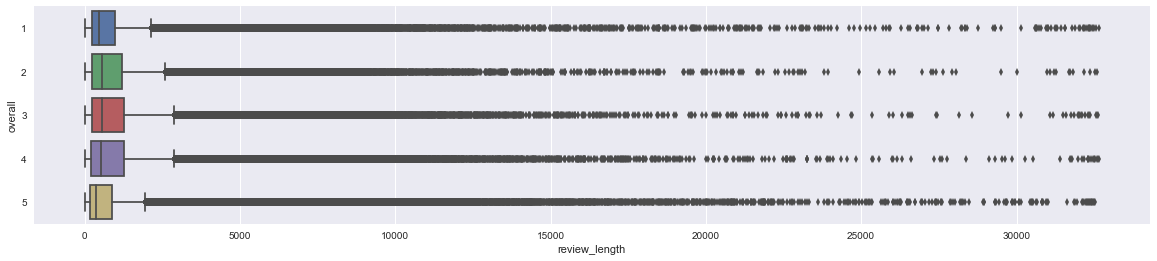

In [49]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
sns.boxplot(y = 'overall', x = 'review_length', data = ratings_with_length_df, orient='h',ax = ax)

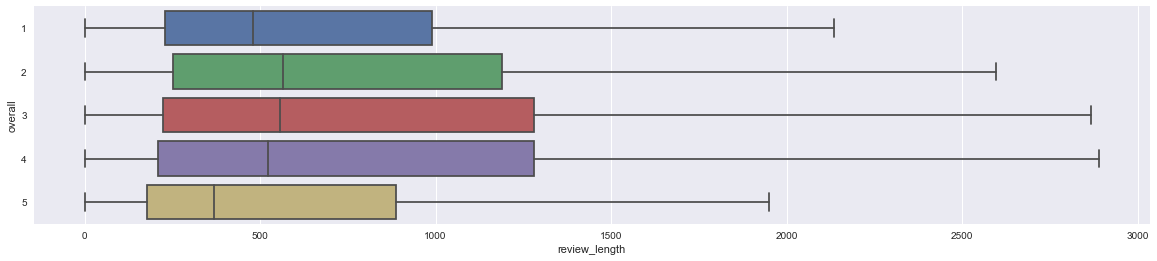

In [50]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
sns.boxplot(y = 'overall', x = 'review_length', data = ratings_with_length_df, orient='h', ax = ax, showfliers=False)

## Ratings

### Collecting the data about ratings
Each row contains: book serial number, date of the review, rating (overall). We construct an intermediate file where each book (asin) is associated with five column features, which give the number of ratings from 1 to 5, respectively.

Rating is in stars (integers), from 1 to 5.

In [ ]:
ratings = df.select("asin", "reviewTime", "overall").rdd.map(lambda row: (row.asin, row.reviewTime, int(row.overall))).collect()

In [ ]:
# Create a DataFrame from the dataset collected before
ratings_df = pd.DataFrame(ratings, columns=['asin', 'Date', 'rating'])
ratings_df['Date'] = pd.to_datetime(ratings_df['Date'])
ratings_df.shape

In [ ]:
# Save the data
ratings_df.to_csv("ratings.csv", index=False)

In [33]:
# Read the data from the file
ratings_df = pd.read_csv("ratings.csv", parse_dates=['Date'])

### Number of 1, 2, 3, 4, 5 - star ratings in each month

In [198]:
# Number of 1, 2, 3, 4, 5 - star ratings in each month
ratings_df['Year-month'] = ratings_df['Date'].dt.to_period('M')
ratings_grouped_df = ratings_df[['Year-month', 'rating', 'asin']].groupby(['Year-month', 'rating']).count()
ratings_grouped_unstack_date_df = ratings_grouped_df.unstack(level=1)
ratings_grouped_unstack_date_df.head()

asin                   
rating        1    2   3    4    5
Year-month                        
1996-05     NaN  NaN NaN  1.0  NaN
1996-06     1.0  NaN NaN  NaN  NaN
1996-08     NaN  NaN NaN  NaN  1.0
1996-09     NaN  NaN NaN  NaN  1.0
1996-11     NaN  2.0 NaN  2.0  2.0

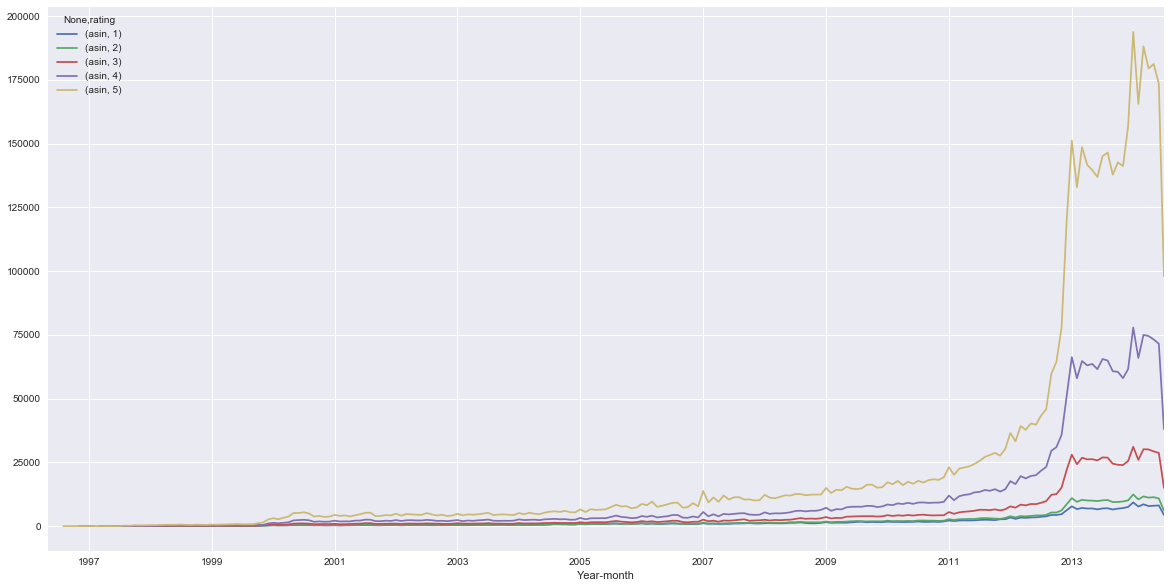

In [5]:
ratings_grouped_unstack_date_df.plot(figsize = (20,10))

### Number of each 1, 2, 3, 4, 5 ratings for each book

In [17]:
# Aggregate data by number of each 1, 2, 3, 4, 5 ratings for each book

ratings_grouped_asin_df = ratings_df[['Year-month', 'rating', 'asin']].groupby(['asin', 'rating']).count()
ratings_grouped_asin_unstack_df = ratings_grouped_asin_df.unstack(level=1, fill_value=0)
ratings_grouped_asin_unstack_df.columns = ratings_grouped_asin_unstack_df.columns.droplevel()
ratings_grouped_asin_unstack_df.head()

rating      1  2  3   4    5
asin                        
000100039X  6  4  8  15  173
0001055178  0  4  2  10    2
0001473123  1  0  0   2   13
0001473727  0  0  0   0    7
0001473905  0  0  1   0    5

In [18]:
# Save aggregated data to file
ratings_grouped_asin_unstack_df.to_csv("ratings_grouped_unstack.csv")

In [34]:
# Read data from file
ratings_grouped_unstack_df = pd.read_csv('ratings_grouped_unstack.csv', index_col='asin')
ratings_grouped_unstack_df.rename(columns={1:"1", 2:"2", 3:"3", 4:"4", 5:"5"}, inplace=True)
ratings_grouped_unstack_df.head()

1  2  3   4    5
asin                        
000100039X  6  4  8  15  173
0001055178  0  4  2  10    2
0001473123  1  0  0   2   13
0001473727  0  0  0   0    7
0001473905  0  0  1   0    5

Column 1 contains the number of 1-star ratings, etc.

### Mean and standard deviation of ratings for each book

In [35]:
# Calculating weighted mean and standard deviation
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=1)
    variance = np.average(((values.T - average).T)**2, weights=weights, axis=1)
    return (average, np.sqrt(variance))

In [36]:
ratings_grouped_unstack_df['Weighted_mean'], ratings_grouped_unstack_df[
    'Std_dev'] = weighted_avg_and_std(
        values=np.broadcast_to([1, 2, 3, 4, 5],
                               (ratings_grouped_unstack_df.shape[0], 5)),
        weights=np.array(ratings_grouped_unstack_df[['1', '2', '3', '4',
                                                     '5']].values))

ratings_grouped_unstack_df['Number_of_reviews'] = np.sum(
    np.array(ratings_grouped_unstack_df[['1', '2', '3', '4', '5']].values),
    axis=1)

ratings_grouped_unstack_df.head()

1  2  3   4    5  Weighted_mean   Std_dev  Number_of_reviews
asin                                                                    
000100039X  6  4  8  15  173       4.674757  0.873584                206
0001055178  0  4  2  10    2       3.555556  0.955814                 18
0001473123  1  0  0   2   13       4.625000  0.992157                 16
0001473727  0  0  0   0    7       5.000000  0.000000                  7
0001473905  0  0  1   0    5       4.666667  0.745356                  6

In [199]:
ratings_grouped_unstack_df.describe()

1              2              3              4  \
count  367982.000000  367982.000000  367982.000000  367982.000000   
mean        0.880024       1.128071       2.595749       6.041312   
std         4.809409       4.139157       7.780360      16.193202   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       1.000000       3.000000   
75%         1.000000       1.000000       3.000000       6.000000   
max      1565.000000     640.000000    1209.000000    2065.000000   

                   5  Weighted_mean        Std_dev  Number_of_reviews  \
count  367982.000000  367982.000000  367982.000000      367982.000000   
mean       13.535485       4.261260       0.836717          24.180642   
std        39.736241       0.514929       0.394379          66.303046   
min         0.000000       1.000000       0.000000           5.000000   
25%         4.000000       4.000000       0.507269           6.000000   
50%         6.000000       4.333333       0.817920          10.000000   
75%        12.000000       4.625000       1.118034          21.000000   
max      4839.000000       5.000000       2.000000        7440.000000   

             Avg_len  
count  367982.000000  
mean      887.403050  
std       563.153632  
min        63.000000  
25%       464.200000  
50%       769.506637  
75%      1172.400000  
max     13459.500000

In [39]:
ratings_grouped_unstack_df = pd.merge(
    ratings_grouped_unstack_df,
    avg_len_review_per_book_df,
    right_index=True,
    left_index=True)
ratings_grouped_unstack_df.drop('number_of_reviews', inplace=True, axis=1)
ratings_grouped_unstack_df.head()

1  2  3   4    5  Weighted_mean   Std_dev  Number_of_reviews  \
000100039X  6  4  8  15  173       4.674757  0.873584                206   
0001055178  0  4  2  10    2       3.555556  0.955814                 18   
0001473123  1  0  0   2   13       4.625000  0.992157                 16   
0001473727  0  0  0   0    7       5.000000  0.000000                  7   
0001473905  0  0  1   0    5       4.666667  0.745356                  6   

                Avg_len  
000100039X   638.033981  
0001055178  1308.611111  
0001473123   287.937500  
0001473727   187.571429  
0001473905   481.833333

In [40]:
ratings_grouped_unstack_df.describe()

1              2              3              4  \
count  367982.000000  367982.000000  367982.000000  367982.000000   
mean        0.880024       1.128071       2.595749       6.041312   
std         4.809409       4.139157       7.780360      16.193202   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       1.000000       3.000000   
75%         1.000000       1.000000       3.000000       6.000000   
max      1565.000000     640.000000    1209.000000    2065.000000   

                   5  Weighted_mean        Std_dev  Number_of_reviews  \
count  367982.000000  367982.000000  367982.000000      367982.000000   
mean       13.535485       4.261260       0.836717          24.180642   
std        39.736241       0.514929       0.394379          66.303046   
min         0.000000       1.000000       0.000000           5.000000   
25%         4.000000       4.000000       0.507269           6.000000   
50%         6.000000       4.333333       0.817920          10.000000   
75%        12.000000       4.625000       1.118034          21.000000   
max      4839.000000       5.000000       2.000000        7440.000000   

             Avg_len  
count  367982.000000  
mean      887.403050  
std       563.153632  
min        63.000000  
25%       464.200000  
50%       769.506637  
75%      1172.400000  
max     13459.500000

###  Plots

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


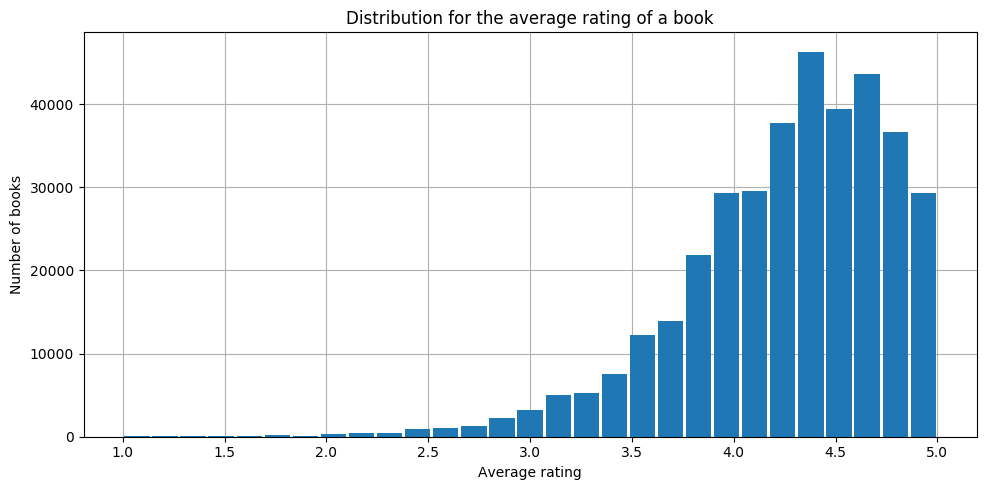

In [421]:
#Plot a histogram 
fig, ax = plt.subplots(figsize=(10,5), ncols=1, nrows=1)

ratings_grouped_unstack_df['Weighted_mean'].hist(bins=np.linspace(1,5,30), rwidth=0.9)

plt.title('Distribution for the average rating of a book')
plt.xlabel('Average rating')
plt.ylabel('Number of books')
plt.savefig('./images/distribution_of_avg_rating.png', transparent=True)
plt.show()

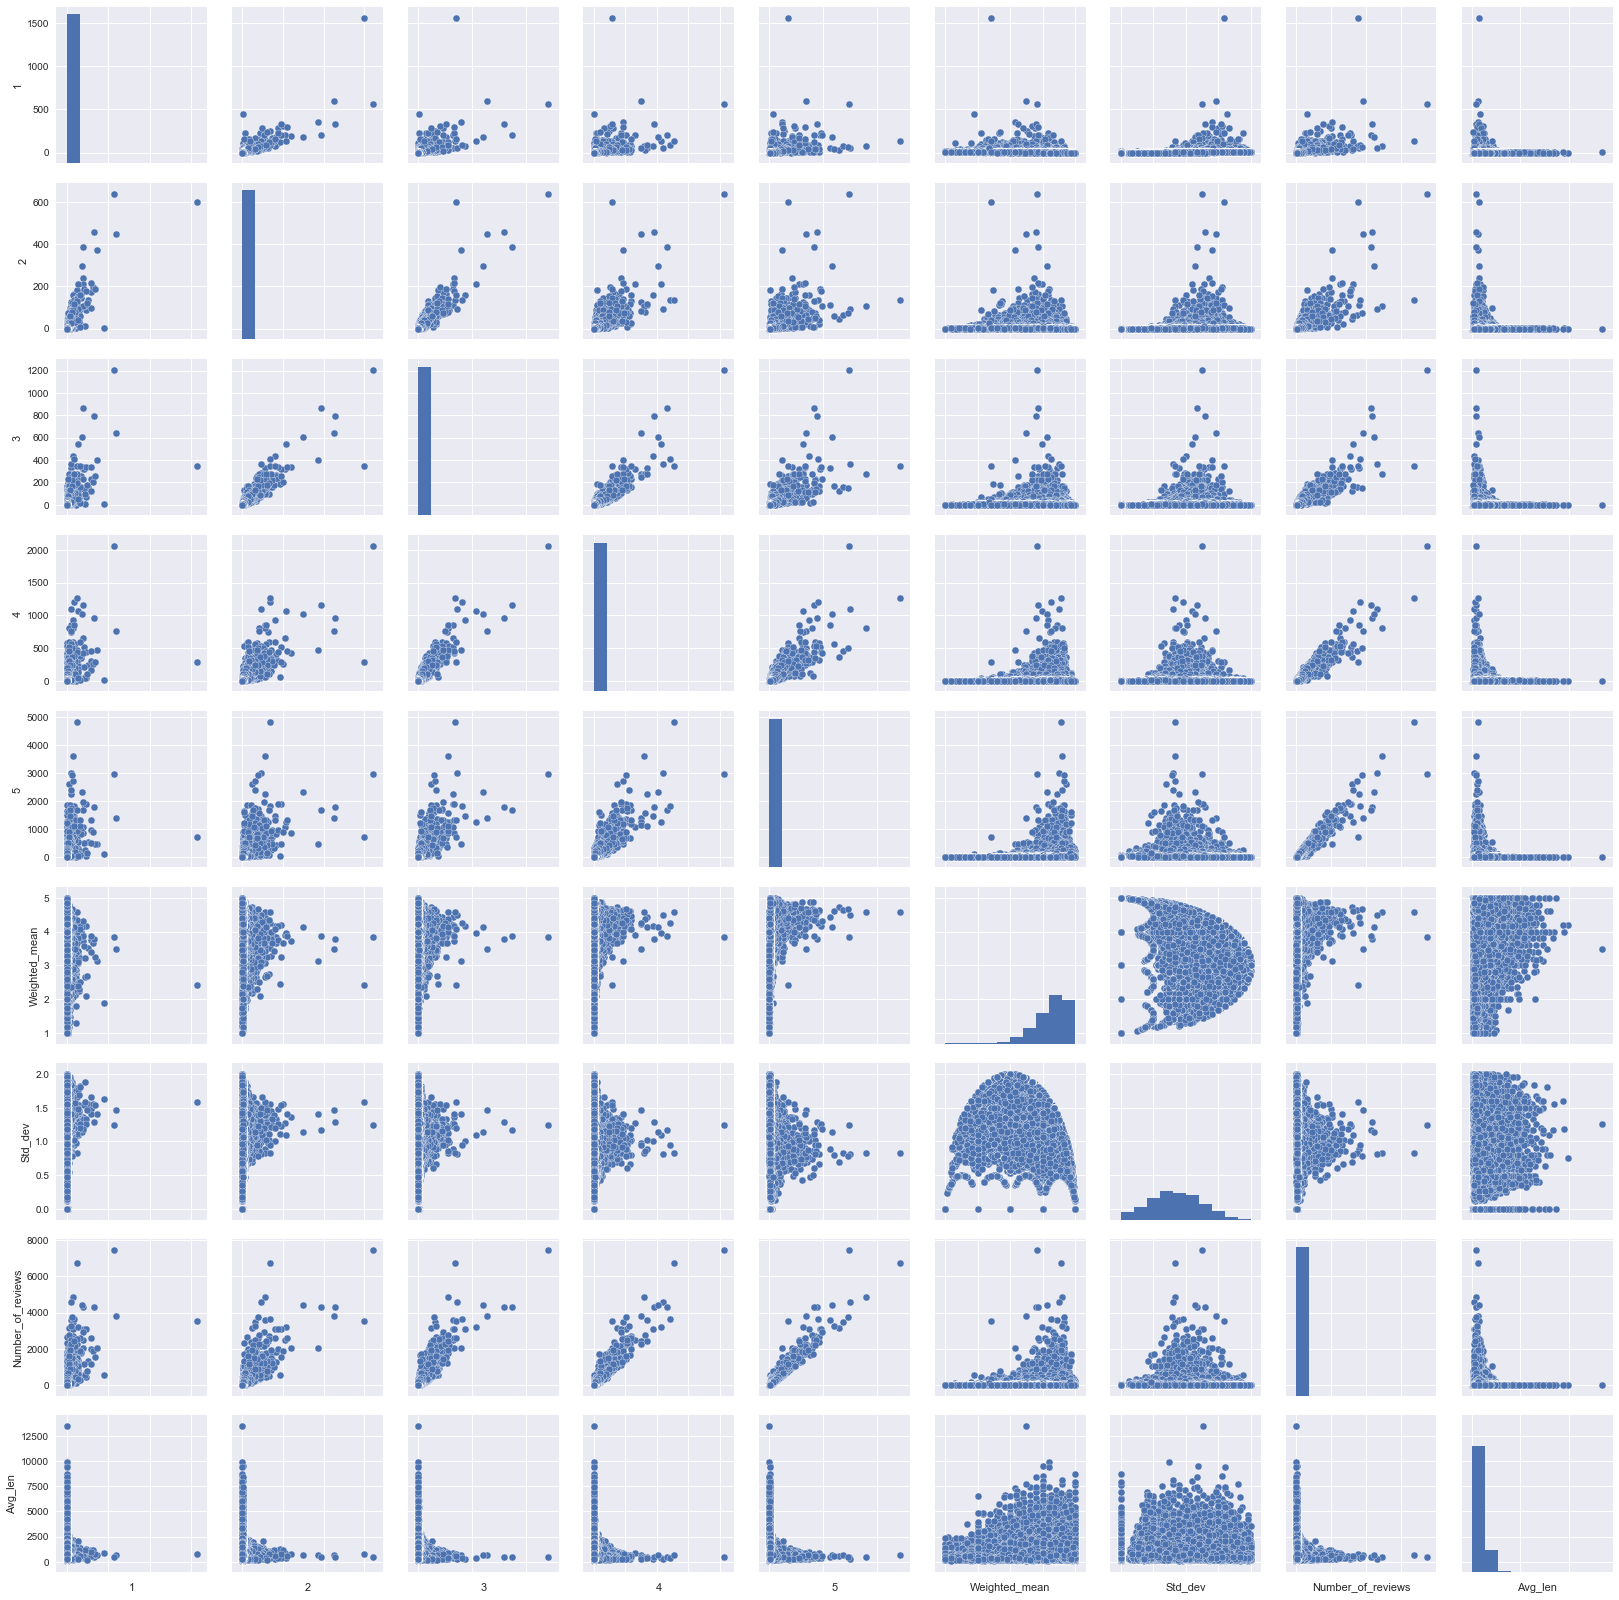

In [224]:
g = sns.pairplot(ratings_grouped_unstack_df)
g.set(xticklabels=[])

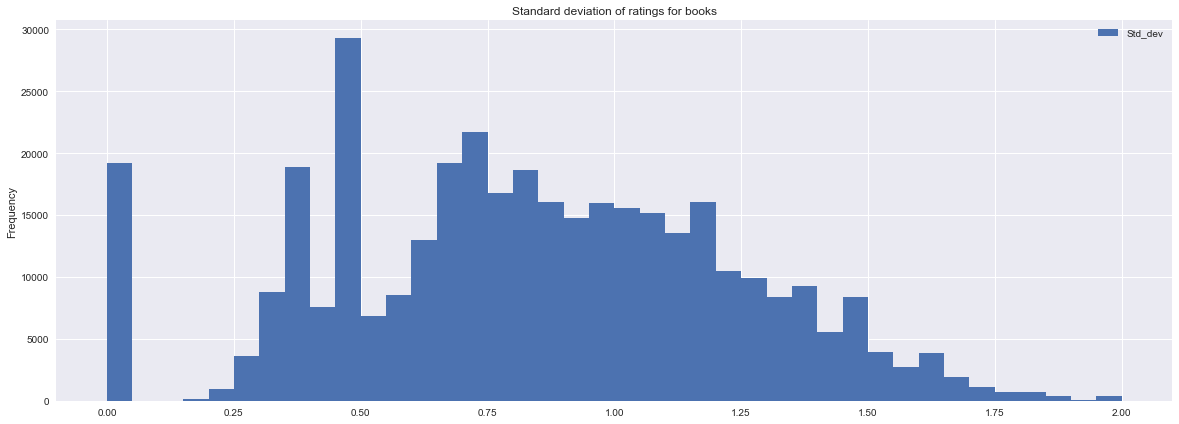

In [26]:
ratings_grouped_unstack_df.plot(y = 'Std_dev', kind = 'hist', bins = 40, figsize = (20,7), 
        title = 'Standard deviation of ratings for books')

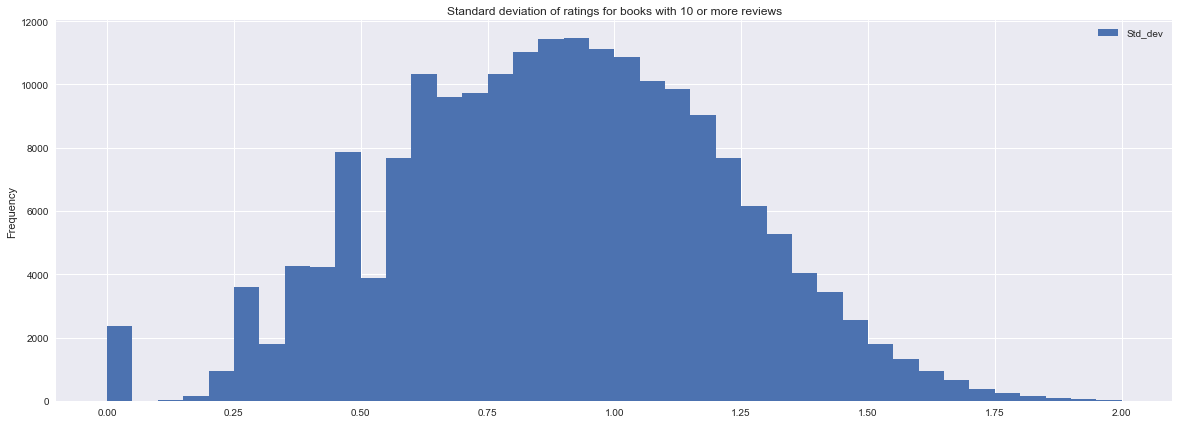

In [27]:
ratings_grouped_unstack_df[ratings_grouped_unstack_df['Number_of_reviews'] > 9].plot(y = 'Std_dev', 
        kind = 'hist', bins = 40, figsize = (20,7), 
        title = 'Standard deviation of ratings for books with 10 or more reviews')

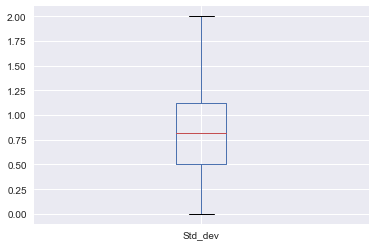

In [80]:
ratings_grouped_unstack_df.plot(y = 'Std_dev', kind = 'box')

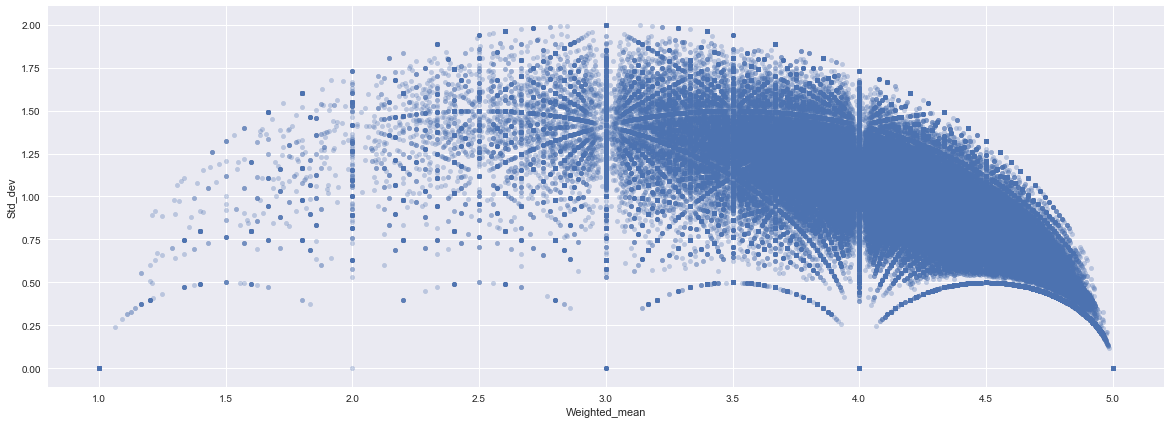

In [28]:
ratings_grouped_unstack_df.plot(x = 'Weighted_mean', y = 'Std_dev', kind = 'scatter', alpha = 0.3, figsize = (20,7))

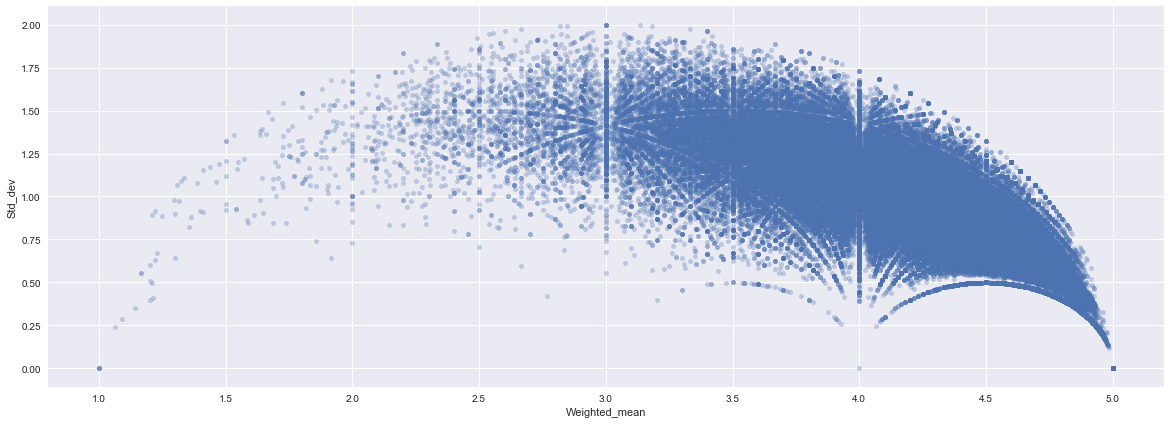

In [29]:
ratings_grouped_unstack_df[ratings_grouped_unstack_df['Number_of_reviews'] > 9].plot(x = 'Weighted_mean', y = 'Std_dev', kind = 'scatter', alpha = 0.3, figsize = (20,7))

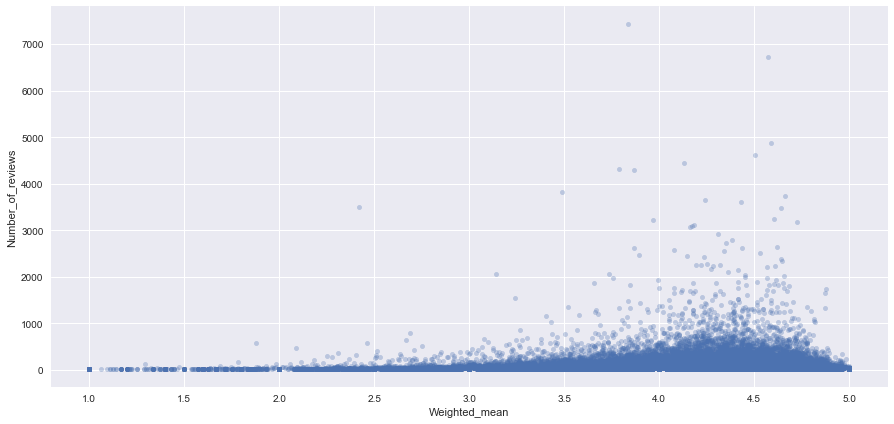

In [30]:
ratings_grouped_unstack_df.plot(x = 'Weighted_mean', y = 'Number_of_reviews', kind = 'scatter', alpha = 0.3, figsize = (15,7))

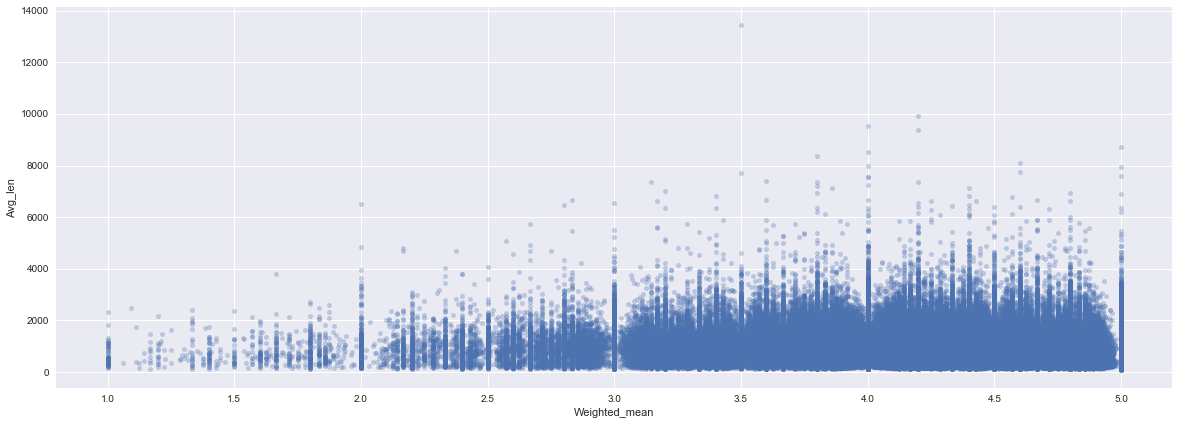

In [31]:
ratings_grouped_unstack_df.plot(x = 'Weighted_mean', y = 'Avg_len', kind = 'scatter', figsize = (20,7), alpha = 0.3)

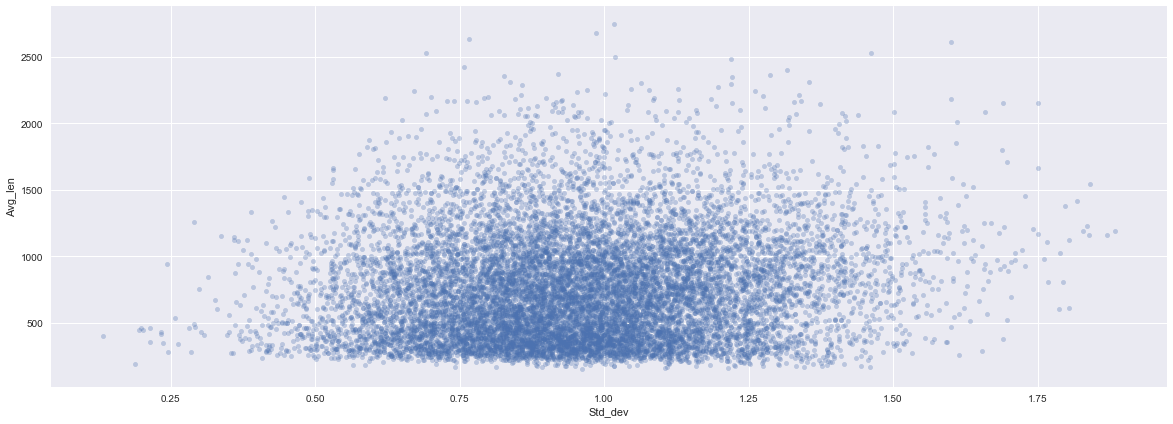

In [32]:
ratings_grouped_unstack_df[ratings_grouped_unstack_df['Number_of_reviews'] > 100].plot(x = 'Std_dev', y = 'Avg_len', kind = 'scatter', figsize = (20,7), alpha = 0.3)

### High vs. low variance test - do they have the same average review lenght?

Here we are going to see if books with high and low variance in the ratings of their reviews have reviews with similar lengths. 

In [36]:
books_low_std = ratings_grouped_unstack_df[ratings_grouped_unstack_df['Std_dev'] < 0.507]
books_high_std = ratings_grouped_unstack_df[ratings_grouped_unstack_df['Std_dev'] > 1.18]
print(books_low_std.shape[0], books_high_std.shape[0])

91945 73906


In [37]:
books_low_std.describe()

1             2             3             4             5  \
count  91945.000000  91945.000000  91945.000000  91945.000000  91945.000000   
mean       0.007320      0.005351      0.075186      2.132003      7.780184   
std        0.221183      0.119972      0.441639      2.430834     13.635870   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      1.000000      4.000000   
50%        0.000000      0.000000      0.000000      2.000000      5.000000   
75%        0.000000      0.000000      0.000000      3.000000      8.000000   
max       20.000000     12.000000     27.000000    125.000000   1604.000000   

       Weighted_mean       Std_dev  Number_of_reviews       Avg_len  
count   91945.000000  91945.000000       91945.000000  91945.000000  
mean        4.743573      0.332847          10.000044    850.340227  
std         0.276237      0.181190          15.338557    570.802787  
min         1.000000      0.000000           5.000000     63.000000  
25%         4.625000      0.300000           5.000000    430.387097  
50%         4.800000      0.400000           7.000000    710.833333  
75%         4.900000      0.471405          10.000000   1117.833333  
max         5.000000      0.506812        1731.000000   8716.000000

In [38]:
books_high_std.describe()

1             2             3             4             5  \
count  73906.000000  73906.000000  73906.000000  73906.000000  73906.000000   
mean       2.817782      2.212107      3.098273      4.711634      9.610140   
std        9.829752      7.157018     10.577516     15.644846     31.245404   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      0.000000      1.000000      3.000000   
50%        1.000000      1.000000      1.000000      2.000000      5.000000   
75%        3.000000      2.000000      3.000000      4.000000      8.000000   
max     1565.000000    640.000000   1209.000000   2065.000000   2959.000000   

       Weighted_mean       Std_dev  Number_of_reviews       Avg_len  
count   73906.000000  73906.000000       73906.000000  73906.000000  
mean        3.697671      1.390584          22.449936    901.369553  
std         0.472719      0.160412          69.236831    586.023271  
min         1.444444      1.180041           5.000000    103.000000  
25%         3.428571      1.259964           7.000000    477.461538  
50%         3.777778      1.356466          10.000000    781.400000  
75%         4.000000      1.490712          19.000000   1174.356061  
max         4.600000      2.000000        7440.000000  13459.500000

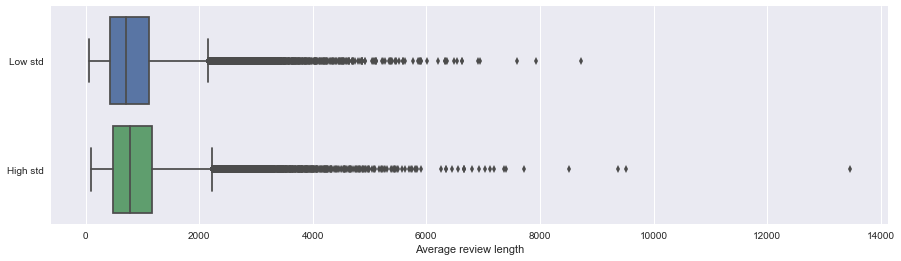

In [39]:
fig, ax1 = plt.subplots(figsize=(15, 4))
bp = sns.boxplot(data = [books_low_std['Avg_len'].values, books_high_std['Avg_len'].values], orient = 'h')
ax1.set_yticklabels(['Low std','High std'])
ax1.set_xlabel("Average review length")

In [40]:
stats.ks_2samp(books_low_std['Avg_len'].values, books_high_std['Avg_len'].values)

Ks_2sampResult(statistic=0.057000797657238644, pvalue=3.4237576578318584e-116)

We can reject hypothesis that these two samples come from the same distribution, so we proved that books with high std dev have on average longer reviews that those with low std_dev. 

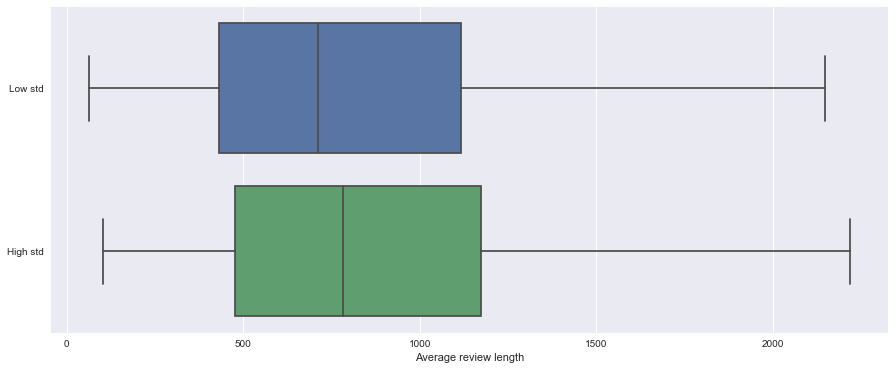

In [45]:
fig, ax1 = plt.subplots(figsize=(15, 6))
bp = sns.boxplot(data = [books_low_std['Avg_len'].values, books_high_std['Avg_len'].values], orient = 'h', showfliers=False)
ax1.set_yticklabels(['Low std','High std'])
ax1.set_xlabel("Average review length")

In [42]:
def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(data.shape[1])+offset 
    bp = ax.boxplot(data, positions = pos, widths=0.3, patch_artist=True, manage_xticks=False)
#    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
#        plt.setp(bp[element], color=edge_color)
#    for patch in bp['boxes']:
#        patch.set(facecolor=fill_color)

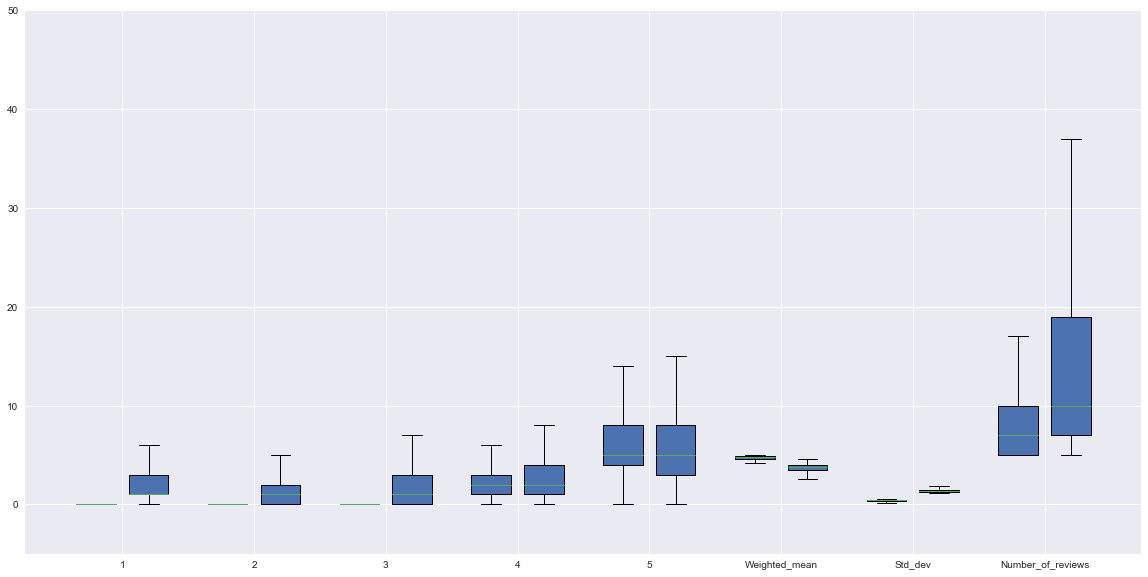

In [44]:
fig, ax = plt.subplots(figsize = (20, 10))
draw_plot(books_low_std.ix[:, books_low_std.columns != "Avg_len"].values, -0.2, "tomato", "white")
draw_plot(books_high_std.ix[:, books_high_std.columns != "Avg_len"].values, +0.2,"skyblue", "white")
ax.set_xticks(np.arange(books_low_std.shape[1] - 1))
ax.set_xticklabels(books_low_std.columns)
ax.set_ylim([-5, 50])
#plt.savefig(__file__+'.png', bbox_inches='tight')
plt.show()
plt.close()

We showed that the average review length is higher for books with high variance in the ratings of their reviews. 

### Good start = good finish?

Here we will try to see if the books that have high ratings associated to their first reviews are more likely to have high ratings associated to their final reviews (or in general for all reviews). We will only look at the books with more than 100 reviews to have enough reviews to make this analysis. 

In [46]:
# Serial numbers of books that have more than 100 reviews
asins_100 = ratings_grouped_unstack_df[ratings_grouped_unstack_df['Number_of_reviews'] > 99].index

In [52]:
ratings_100 = ratings_df[ratings_df['asin'].isin(asins_100)]

In [102]:
start_mean = pd.DataFrame()
for book in ratings_100.groupby("asin"):
    start_mean = start_mean.append(
        pd.DataFrame.from_records([{
            "asin":
            book[0],
            "start_mean":
            pd.DataFrame(book[1]).sort_values("Date").rating[:25].mean()
        }]),
        ignore_index=True)

In [135]:
start_mean.describe()

start_mean
count  13364.000000
mean       4.336082
std        0.462883
min        1.480000
25%        4.120000
50%        4.440000
75%        4.680000
max        5.000000

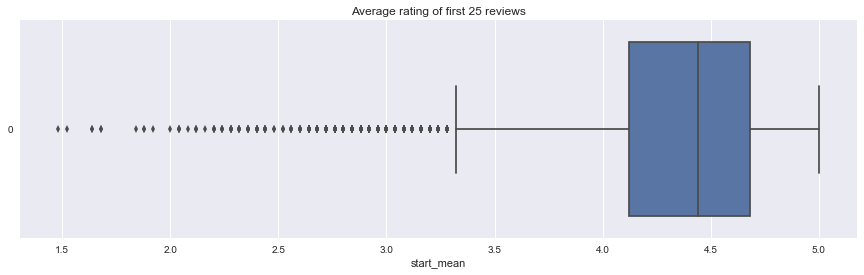

In [104]:
fig, ax1 = plt.subplots(figsize=(15, 4))
bp = sns.boxplot(data = start_mean['start_mean'].values, orient = 'h')
ax1.set_xlabel("start_mean")
ax1.set_title("Average rating of first 25 reviews")

In [178]:
end_mean = pd.DataFrame()
for book in ratings_100.groupby("asin"):
    end_mean = end_mean.append(
        pd.DataFrame.from_records([{
            "asin":
            book[0],
            "end_mean":
            pd.DataFrame(book[1]).sort_values("Date").rating[-50:].mean()
        }]),
        ignore_index=True)

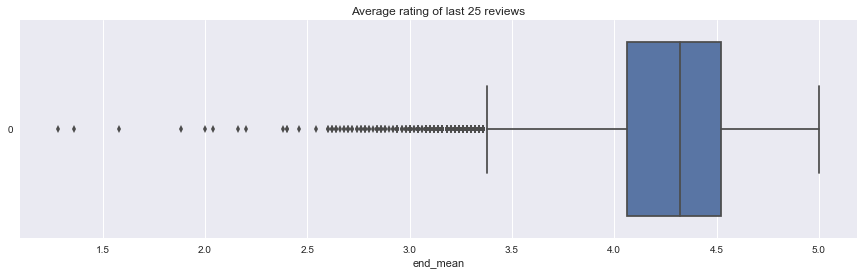

In [181]:
fig, ax1 = plt.subplots(figsize=(15, 4))
bp = sns.boxplot(data = end_mean['end_mean'].values, orient = 'h')
ax1.set_xlabel("end_mean")
ax1.set_title("Average rating of last 25 reviews")

In [188]:
# Final ratings
ratings_100_combined = ratings_grouped_unstack_df[ratings_grouped_unstack_df.index.isin(asins_100)]
#ratings_100_combined = ratings_100_combined[['Weighted_mean']]

In [189]:
ratings_100_combined = pd.merge(ratings_100_combined, start_mean, left_index=True, right_on='asin')

In [191]:
ratings_100_combined = pd.merge(ratings_100_combined, end_mean, left_on='asin', right_on='asin')

In [195]:
ratings_100_combined['start_end_mean_diff'] = ratings_100_combined['start_mean'] - ratings_100_combined['end_mean']

In [196]:
ratings_100_combined.describe()

1             2             3             4             5  \
count  13364.000000  13364.000000  13364.000000  13364.000000  13364.000000   
mean       8.631098     10.775217     24.301257     56.603711    130.774095   
std       22.800373     17.832510     31.423513     62.240291    163.242477   
min        0.000000      0.000000      0.000000      1.000000      4.000000   
25%        1.000000      3.000000     10.000000     29.000000     64.000000   
50%        4.000000      6.000000     17.000000     41.000000     88.000000   
75%        9.000000     13.000000     28.000000     62.000000    137.000000   
max     1565.000000    640.000000   1209.000000   2065.000000   4839.000000   

       Weighted_mean       Std_dev  Number_of_reviews       Avg_len  \
count   13364.000000  13364.000000       13364.000000  13364.000000   
mean        4.247727      0.959518         231.085379    753.364585   
std         0.371833      0.232384         263.500575    394.388906   
min         1.294118      0.132432         100.000000    150.386207   
25%         4.060903      0.802522         120.000000    431.505687   
50%         4.304348      0.949834         156.000000    689.325094   
75%         4.506865      1.109635         239.000000    985.694675   
max         4.982143      1.883433        7440.000000   2747.601504   

         start_mean      end_mean  start_end_mean_diff  
count  13364.000000  13364.000000         13364.000000  
mean       4.336082      4.260094             0.075988  
std        0.462883      0.365522             0.388539  
min        1.480000      1.280000            -2.720000  
25%        4.120000      4.060000            -0.120000  
50%        4.440000      4.320000             0.100000  
75%        4.680000      4.520000             0.320000  
max        5.000000      5.000000             1.800000

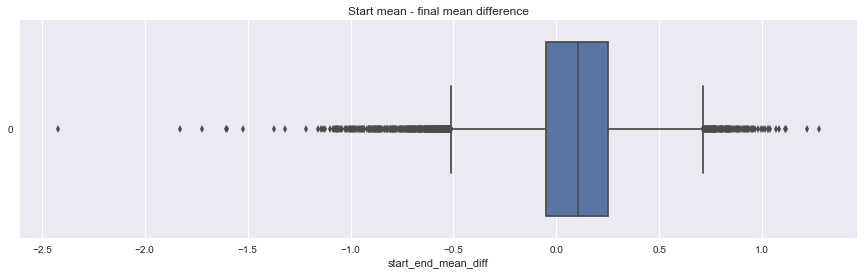

In [127]:
fig, ax1 = plt.subplots(figsize=(15, 4))
bp = sns.boxplot(data = ratings_100_combined['start_end_mean_diff'].values, orient = 'h')
ax1.set_xlabel("start_end_mean_diff")
ax1.set_title("Start mean - final mean difference")

In [143]:
low_high = ratings_100_combined[(ratings_100_combined['start_mean'] < 4.12)
                     & (ratings_100_combined['Weighted_mean'] > 4.506)]
high_low = ratings_100_combined[(ratings_100_combined['start_mean'] > 4.68)
                     & (ratings_100_combined['Weighted_mean'] < 4.06)]
low_low = ratings_100_combined[(ratings_100_combined['start_mean'] < 4.12)
                     & (ratings_100_combined['Weighted_mean'] < 4.06)]
high_high = ratings_100_combined[(ratings_100_combined['start_mean'] > 4.68)
                     & (ratings_100_combined['Weighted_mean'] > 4.506)]
print(low_low.shape[0], low_high.shape[0], high_high.shape[0], high_low.shape[0])

2293 20 2093 30


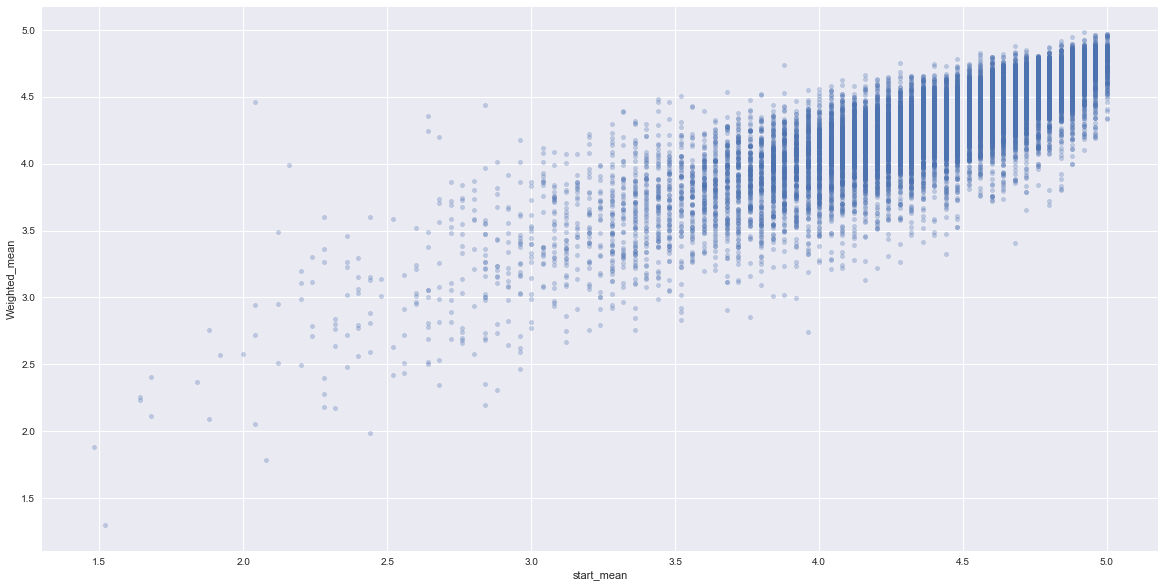

In [145]:
ratings_100_combined.plot(x="start_mean", y="Weighted_mean", kind="scatter", figsize=(20,10), alpha=0.3)

In [377]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev


def jitter(x,
           y,
           s=20,
           c='b',
           marker='.',
           cmap=None,
           norm=None,
           vmin=None,
           vmax=None,
           alpha=None,
           linewidths=None,
           verts=None,
           hold=None,
           **kwargs):
    return plt.scatter(
        rand_jitter(x),
        rand_jitter(y),
        s=s,
        c=c,
        marker=marker,
        cmap=cmap,
        norm=norm,
        vmin=vmin,
        vmax=vmax,
        alpha=alpha,
        linewidths=linewidths,
        verts=verts,
        hold=hold,
        **kwargs)

In [374]:
plt.rcdefaults()
font = {'size' : 10}
plt.rc('font', **font)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rc('axes', axisbelow=True)

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


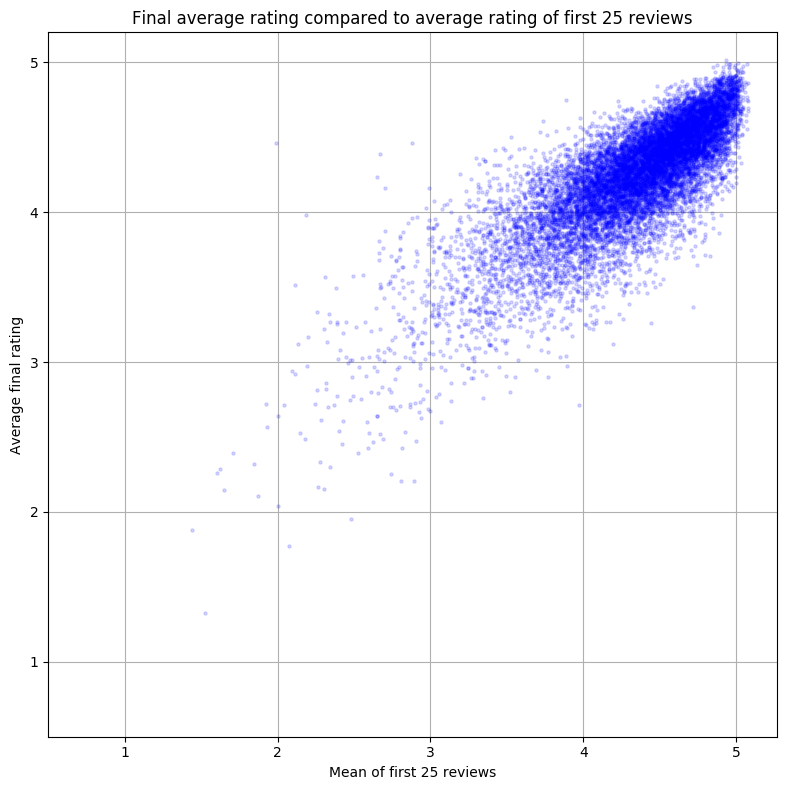

In [385]:
plt.figure(figsize=(8,8))
plt.grid()
jitter(x=ratings_100_combined["start_mean"], y=ratings_100_combined["Weighted_mean"], alpha=0.15)
plt.xlabel("Mean of first 25 reviews")
plt.ylabel("Average final rating")
plt.xlim(xmin = 0.5)
plt.ylim(ymin = 0.5)
plt.title("Final average rating compared to average rating of first 25 reviews")
plt.savefig('./images/Final average rating compared to average rating of first 25 reviews.png', transparent=True)
plt.show()

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


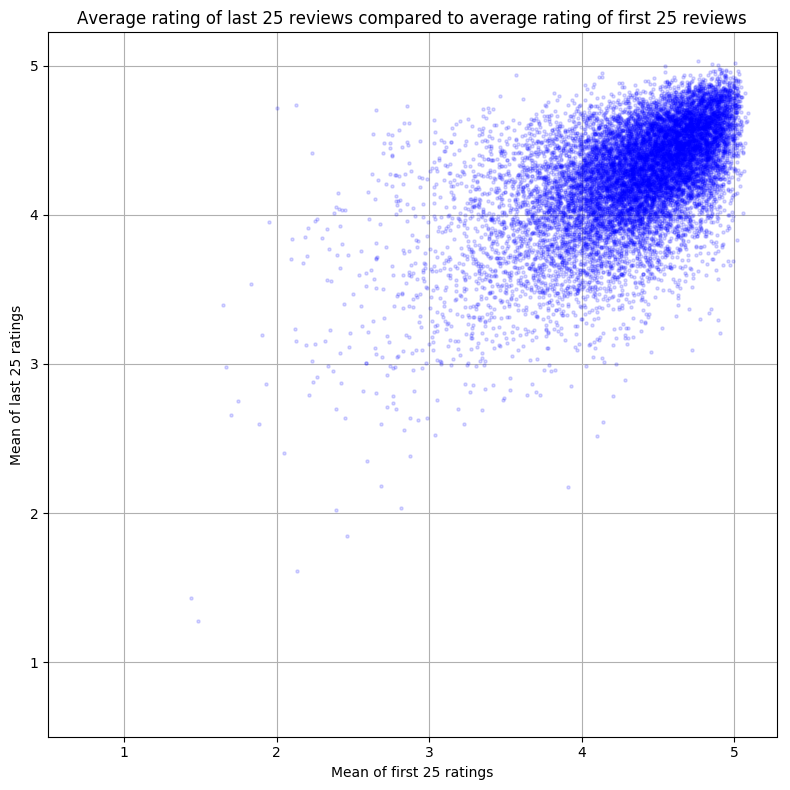

In [386]:
plt.figure(figsize=(8,8))
plt.grid()
jitter(x=ratings_100_combined["start_mean"], y=ratings_100_combined["end_mean"], alpha=0.15)
plt.xlabel("Mean of first 25 ratings")
plt.ylabel("Mean of last 25 ratings")
plt.xlim(xmin = 0.5)
plt.ylim(ymin = 0.5)
plt.title("Average rating of last 25 reviews compared to average rating of first 25 reviews")
plt.savefig('./images/Average rating of last 25 reviews compared to average rating of first 25 reviews', transparent=True)
plt.show()

This analysis showed that the first 25 ratingscan have an influence on the following ratings as the books with high first ratings are more likely to have better ratings in the end. 

## Popularity metrics

In this part, we tried to define statistics that could measure the "popularity" of a book. 

### 1st popularity measure
For the first measure, we will consider an overall popularity measure that corresponds to number of reviews divided by the days from the first review. A book that has a lot of reviews in a small period after the first review will be classified as popular by this definition whereas a book that only has a few comments for a long period after the first review will be classified as not very popular with this definition. 

In [235]:
# Overall popularity measure (#reviews / #days from first review)
ratings_gb_df = ratings_df[['asin', 'Date', 'rating']].groupby('asin').agg({
    'Date':
    np.min,
    'rating':
    'count'
})
ratings_gb_df.columns = ['first_review_date', 'number_of_reviews']
last_review = ratings_df.Date.max()
ratings_gb_df[
    'days_since_first_review'] = last_review - ratings_gb_df['first_review_date']
ratings_gb_df['days_since_first_review'] = ratings_gb_df[
    'days_since_first_review'].astype('timedelta64[D]')
ratings_gb_df['popularity_factor'] = ratings_gb_df[
    'number_of_reviews'] / ratings_gb_df['days_since_first_review']
popularity_measure1_df = ratings_gb_df.sort_values(
    'popularity_factor', ascending=False)
popularity_measure1_df.head()

first_review_date  number_of_reviews  days_since_first_review  \
asin                                                                       
B00M13FNSS        2014-07-23                  7                      0.0   
B00LZKMXBI        2014-07-21                160                      2.0   
B00LBFVNQS        2014-07-22                 32                      1.0   
B00M0RE7CS        2014-07-22                 30                      1.0   
1471133524        2014-07-01                515                     22.0   

            popularity_factor  
asin                           
B00M13FNSS                inf  
B00LZKMXBI          80.000000  
B00LBFVNQS          32.000000  
B00M0RE7CS          30.000000  
1471133524          23.409091

### 2nd popularity measure
For the second popularity measure, we will take a measure equal to the biggest increase in the number of reviews in a 3-month-period (the highest first derivative for the accumulated number of reviews -  with time period equal to 3 months).

In [143]:
# DataFrame having all possible months 
first_review = ratings_df.Date.min()
first_review_month = first_review.to_period("M")

last_review = ratings_df.Date.max()
last_review_month = last_review.to_period("M")

month_year_timespan = pd.date_range(first_review_month.to_timestamp(), last_review_month.to_timestamp(), freq = 'M').to_period('M')
month_year_timespan_df = pd.DataFrame(month_year_timespan, columns = ['Year-month'])

In [162]:
def pop_measure_2(df, period):
    df = df.groupby(['asin', "Year-month"]).count()
    df = df.reset_index()

    df = pd.merge(
        df,
        month_year_timespan_df,
        how='right',
        right_on='Year-month',
        left_on="Year-month")
    df.fillna(0, inplace=True)
    df.sort_values("Year-month", inplace=True)

    df['cumsum_rating'] = df['rating'].cumsum()
    df['rating_shift'] = df['cumsum_rating'].shift(period)
    df['month_diff'] = df['cumsum_rating'] - df['rating_shift']
    return df[['asin', 'Year-month',
               'month_diff']].loc[df['month_diff'].idxmax()]

In [ ]:
# Computing popularity measure equal to the biggest 3-month-period review increase
# (the biggest first derivative over accumulated number of reviews with delta eqaul 3 month)
period = 3
ratings_gb_df = ratings_df[['asin', 'Year-month', 'rating']].groupby('asin')
popularity_measure2_df = pd.DataFrame()

for idx, book in enumerate(ratings_gb_df):
    temp = pd.DataFrame(book[1], copy=True)
    popularity_measure2_df = pd.concat([popularity_measure2_df, pop_measure_2(temp, period)])

asins = popularity_measure2_df.values[::3].flatten()
ym = popularity_measure2_df.values[1::3].flatten()
max_diff = popularity_measure2_df.values[2::3].flatten()
popularity_measure2_df = pd.DataFrame.from_dict({'asin': asins, 'Year-month': ym, 'month_diff': max_diff})

In [ ]:
popularity_measure2_df = pd.read_csv("popularity_measure_2_part1.csv")
popularity_measure2_df = pd.concat([popularity_measure2_df, pd.read_csv("popularity_measure_2_part2.csv")])
popularity_measure2_df.reset_index(drop=True, inplace=True)

# Check for 0 valued 'asin' column entries that could happen in case of not being 3 months on the market (books having first review in the last 3 months)
unique_asin = set(ratings_df['asin'].values)
popularity_asins = set(popularity_measure2_df['asin'].values)
t = unique_asin - popularity_asins
t = list(t)

popularity_measure2_df = popularity_measure2_df.drop(popularity_measure2_df[popularity_measure2_df['asin'] == '0'].index)
popularity_measure2_df.to_csv("popularity_measure_2.csv", index = False)

In [ ]:
popularity_measure2_df = pd.read_csv("popularity_measure_2.csv")

Now that we define two popularity metrics we can gather tem into a table for all the books we want to analyse. 

### Complete popularity DataFrame

In [ ]:
popularity_measure_df = pd.merge(
    popularity_measure1_df,
    popularity_measure2_df,
    how='left',
    left_index=True,
    right_on='asin')
popularity_measure_df.reset_index(inplace=True)

## All statistics gathered in one DataFrame
Statistics for each book:
+ Serial number -  `asin`
+ Number of 1, 2, 3, 4, 5 - star ratings
+ Mean of ratings
+ Standard deviation of ratings
+ Number of reviews
+ Average review length
+ Date of the first review
+ Number of days since the first review
+ 1st popularity metric
+ 2nd popularity metric
+ Date of the highest value of 2nd popularity metric

In [251]:
complete_books_df = pd.merge(ratings_grouped_unstack_df, popularity_measure_df, how='left', left_index=True, right_on='asin')
complete_books_df.drop('index', axis = 1, inplace=True)
complete_books_df.reset_index(inplace=True, drop=True)

In [ ]:
complete_books_df = complete_books_df.rename(
    index=str,
    columns={
        "popularity_factor": "pop_metric_1",
        "month_diff": "pop_metric_2",
        "Weighted_mean": "mean",
        "Year-month": "pop_metric_2_date"
    })
complete_books_df['pop_metric_2_date'] = pd.to_datetime(
    complete_books_df['pop_metric_2_date']).dt.to_period("M")
complete_books_df.drop("Number_of_reviews", axis = 1, inplace=True)

In [29]:
# Save statistics data to file
complete_books_df.to_csv("books_statistics_df.csv", index=False)

### Plots

Now that we defined two popularity metrics we will try to plot some figures to see what we can notice from our dataset. 

In [16]:
# Read statistics data from file
complete_books_df = pd.read_csv(
    "books_statistics_df.csv",
    parse_dates=['first_review_date', 'pop_metric_2_date'])

complete_books_df['pop_metric_2_date'] = pd.to_datetime(
    complete_books_df['pop_metric_2_date']).dt.to_period("M")

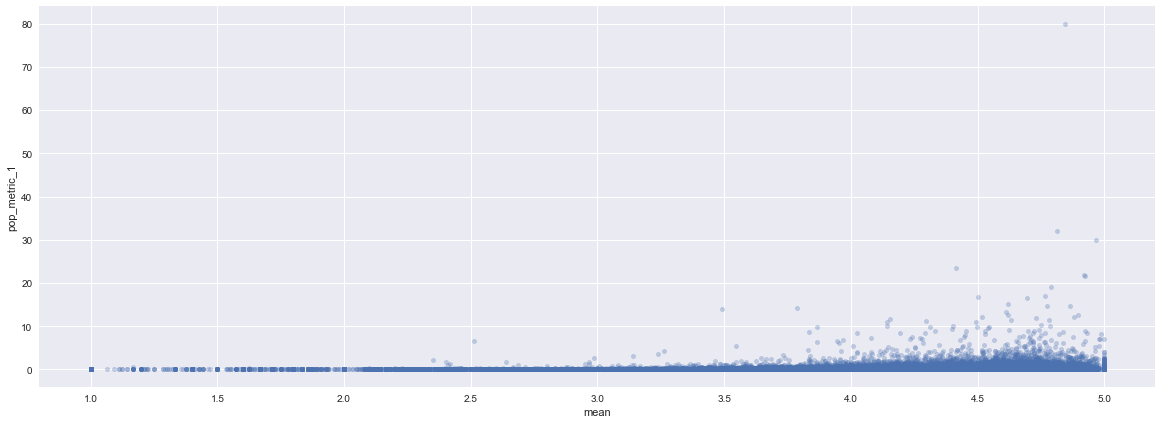

In [8]:
complete_books_df.plot(x = 'mean', y = 'pop_metric_1', kind = 'scatter', alpha = 0.3, figsize=(20,7))

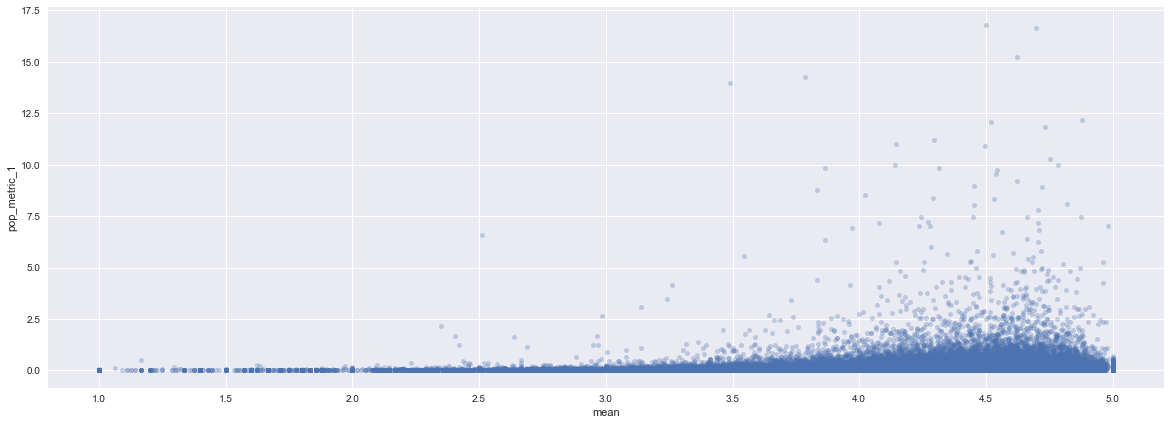

In [10]:
complete_books_df[complete_books_df['days_since_first_review'] > 30].plot(
    x='mean', y='pop_metric_1', kind='scatter', alpha=0.3, figsize=(20, 7))

Here we see that the higher the mean ratings, the higher the popularity score. 

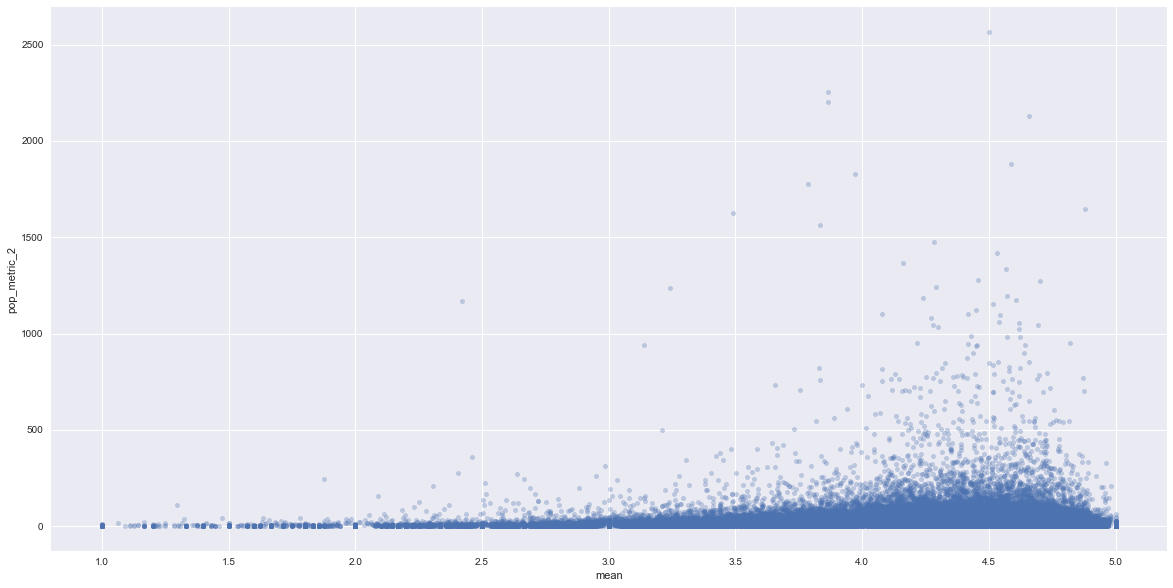

In [15]:
complete_books_df.plot(
    x='mean', y='pop_metric_2', kind='scatter', alpha=0.3, figsize=(20, 10))

Again with the second popularity metric, we see that high rated books are more "popular" according to our definitions of popularity. 

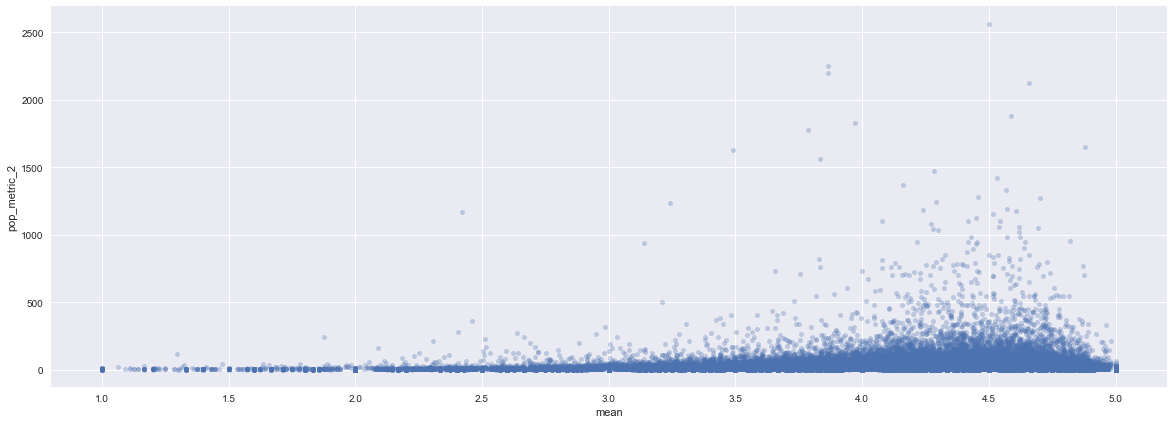

In [200]:
complete_books_df[complete_books_df['days_since_first_review'] > 30].plot(
    x='mean', y='pop_metric_2', kind='scatter', alpha=0.3, figsize=(20, 7))

In [29]:
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    x = ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.xticks(rotation=90)
    plt.colorbar(x)

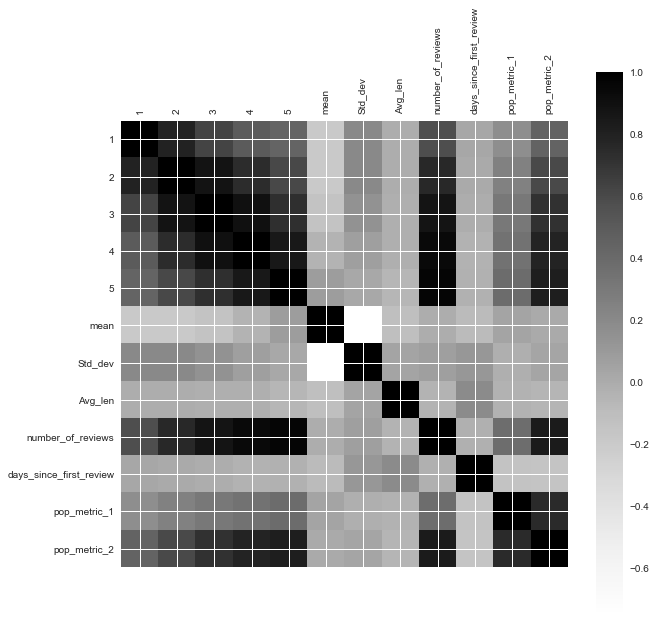

In [30]:
plot_corr(complete_books_df)

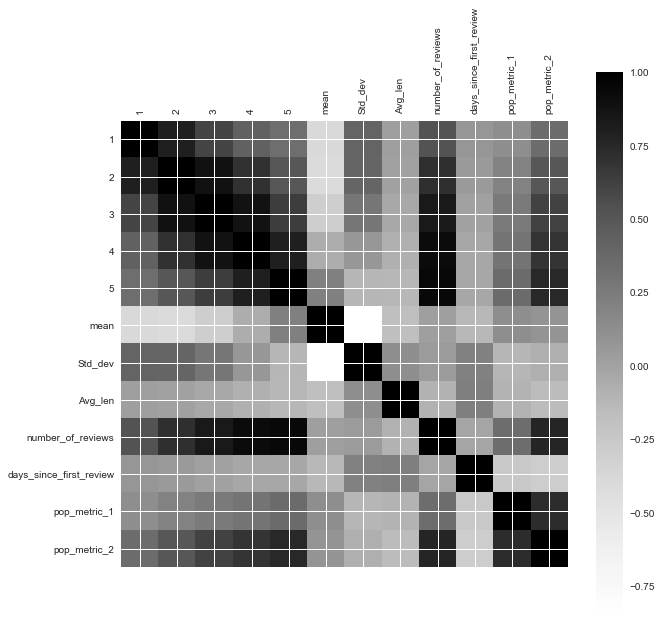

In [32]:
plot_corr(complete_books_df[complete_books_df['number_of_reviews'] > 100])

Here we see that our popularity metrics are correlated with some other metrics. 

# Categories

In this part we will use the categories of the books that we scraped from the Amazon website. In this first section we will start by having a look at the categories we scraped. 

## Reviews covered by books with categories

In [201]:
# Read data from the first file (data scraped manually from Amazon website)
books_with_categories = pd.read_json("product_categories_enhanced.json", lines = True)
books_with_categories = books_with_categories.set_index('asin', drop = True)
books_with_categories.head()

author             brand  \
asin                                            
030758836X    Gillian Flynn             Crown   
0439023483  Suzanne Collins  Scholastic Press   
0375831002     Markus Zusak   Alfred A. Knopf   
038536315X     John Grisham      John Grisham   
0439023513  Suzanne Collins  Scholastic Press   

                                                   categories  \
asin                                                            
030758836X  [[Books, Mystery, Thriller & Suspense, Thrille...   
0439023483  [[Books, Children's Books, Science Fiction & F...   
0375831002  [[Books, Children's Books, Literature & Fictio...   
038536315X  [[Books, Mystery, Thriller & Suspense, Thrille...   
0439023513  [[Books, Teens, Literature & Fiction, Social &...   

                                                     keywords  \
asin                                                            
030758836X  [mystery fiction, wives, 030758836x, thrillers...   
0439023483  [science fiction, scholastic press, survival, ...   
0375831002  [holocaust, the book thief, historical, orphan...   
038536315X  [john grisham, political, suspense fiction, ra...   
0439023513  [science fiction, scholastic press, survival, ...   

                                publisher release_date  \
asin                                                     
030758836X                          Crown   2012-06-05   
0439023483               Scholastic Press   2008-09-14   
0375831002  Knopf Books for Young Readers   2006-03-14   
038536315X       Random House Large Print   2013-10-22   
0439023513               Scholastic Press   2010-08-24   

                                                  title  
asin                                                     
030758836X                                    Gone Girl  
0439023483  The Hunger Games (The Hunger Games, Book 1)  
0375831002                               The Book Thief  
038536315X                                 Sycamore Row  
0439023513                Mockingjay (The Hunger Games)

In [202]:
# Read data from the second file (data got thru Amazon API)
books_with_categories2 = pd.read_json("product_categories.json", lines=True)
books_with_categories2 = books_with_categories2.set_index('asin', drop=True)

# Because of anti-scrape protection not every entry contains categories (so we are removing those)
books_with_categories2 = books_with_categories2[
    books_with_categories2.astype(str)['categories'] != '[]']

In [203]:
books_with_categories = books_with_categories.append(books_with_categories2)

In [204]:
books_with_categories = books_with_categories[~books_with_categories.index.duplicated(keep='first')]

In [205]:
books_with_categories = pd.merge(
    books_with_categories,
    complete_books_df,
    left_index=True,
    right_on='asin',
    how='inner')

In [206]:
books_with_categories.sort_values('number_of_reviews', ascending=False, inplace=True)

In [207]:
books_with_categories.head()

author             brand  \
29335    Gillian Flynn             Crown   
68268  Suzanne Collins  Scholastic Press   
54647     Markus Zusak   Alfred A. Knopf   
58019     John Grisham      John Grisham   
68270  Suzanne Collins  Scholastic Press   

                                              categories  \
29335  [[Books, Mystery, Thriller & Suspense, Thrille...   
68268  [[Books, Children's Books, Science Fiction & F...   
54647  [[Books, Children's Books, Literature & Fictio...   
58019  [[Books, Mystery, Thriller & Suspense, Thrille...   
68270  [[Books, Teens, Literature & Fiction, Social &...   

                                                keywords  \
29335  [mystery fiction, wives, 030758836x, thrillers...   
68268  [science fiction, scholastic press, survival, ...   
54647  [holocaust, the book thief, historical, orphan...   
58019  [john grisham, political, suspense fiction, ra...   
68270  [science fiction, scholastic press, survival, ...   

                           publisher release_date  \
29335                          Crown   2012-06-05   
68268               Scholastic Press   2008-09-14   
54647  Knopf Books for Young Readers   2006-03-14   
58019       Random House Large Print   2013-10-22   
68270               Scholastic Press   2010-08-24   

                                             title    1    2     3  \
29335                                    Gone Girl  567  640  1209   
68268  The Hunger Games (The Hunger Games, Book 1)  129  134   344   
54647                               The Book Thief   81  109   274   
58019                                 Sycamore Row   50   91   360   
68270                Mockingjay (The Hunger Games)  184  298   607   

          ...           mean   Std_dev     Avg_len  first_review_date  \
29335     ...       3.834543  1.250125  455.739785         2012-03-25   
68268     ...       4.571684  0.835131  709.171952         2008-07-22   
54647     ...       4.588199  0.830168  482.175576         2006-02-16   
58019     ...       4.501955  0.809504  276.146612         2013-10-22   
68270     ...       4.131081  1.134602  720.243018         2010-03-03   

       number_of_reviews days_since_first_review  pop_metric_1  \
29335               7440                   850.0      8.752941   
68268               6717                  2192.0      3.064325   
54647               4864                  3079.0      1.579734   
58019               4604                   274.0     16.802920   
68270               4440                  1603.0      2.769807   

       pop_metric_2_date        asin pop_metric_2  
29335            2013-03  030758836X       1564.0  
68268            2013-02  0439023483        981.0  
54647            2014-02  0375831002       1882.0  
58019            2014-01  038536315X       2566.0  
68270            2013-03  0439023513        793.0  

[5 rows x 22 columns]

In [208]:
sum(books_with_categories['number_of_reviews'].values)

3670731

In [209]:
# Unzipping list of lists of categories, extracting all categories to which book is assigned
all_categories = books_with_categories['categories'].apply(lambda x: 
        list(set([item for lists in x for item in lists])))
all_categories_frequency = dict(Counter(all_categories.sum()))
len(all_categories_frequency)

2556

In [210]:
# Most popular categories
sorted_all_categories_frequency = sorted(all_categories_frequency.items(), key=operator.itemgetter(1), reverse=True)
sorted_all_categories_frequency[:10]

[('Books', 24471),
 ('Literature & Fiction', 13279),
 ('Romance', 7214),
 ('Genre Fiction', 5158),
 ('Mystery, Thriller & Suspense', 4820),
 ('Contemporary', 3884),
 ('Science Fiction & Fantasy', 3700),
 ('Kindle Store', 3174),
 ('Kindle eBooks', 3132),
 ('Thrillers & Suspense', 3032)]

In [211]:
# First level category
first_level_cat = books_with_categories['categories'].apply(lambda x: 
        list(set([lists[1] for lists in x if len(lists)>1])))
first_level_cat_frequency = dict(Counter(first_level_cat.sum()))
len(first_level_cat_frequency)

52

In [212]:
sorted_first_level_cat_frequency = sorted(first_level_cat_frequency.items(), key=operator.itemgetter(1), reverse=True)
sorted_first_level_cat_frequency[:10]

[('Literature & Fiction', 10879),
 ('Romance', 5287),
 ('Mystery, Thriller & Suspense', 4369),
 ('Kindle eBooks', 3132),
 ('Science Fiction & Fantasy', 2453),
 ('Christian Books & Bibles', 1991),
 ('Teens', 1530),
 ('Biographies & Memoirs', 1473),
 ("Children's Books", 1060),
 ('Politics & Social Sciences', 1014)]

In [213]:
# Second level category
second_level_cat = books_with_categories['categories'].apply(lambda x: 
        list(set([lists[2] for lists in x if len(lists)>2])))
second_level_cat_frequency = dict(Counter(second_level_cat.sum()))
len(second_level_cat_frequency)

410

In [214]:
sorted_second_level_cat_frequency = sorted(second_level_cat_frequency.items(), key=operator.itemgetter(1), reverse=True)
sorted_second_level_cat_frequency[:10]

[('Genre Fiction', 4932),
 ('Literature & Fiction', 4144),
 ('Contemporary', 3376),
 ('Thrillers & Suspense', 3022),
 ('Mystery', 2168),
 ('United States', 2066),
 ('Romance', 1770),
 ('Fantasy', 1661),
 ('Science Fiction & Fantasy', 1353),
 ('Literary', 1306)]

Those are some examples of the most common categories that the books can be assigned to. 

# Books classification into categories like Bad, good, controversial. 

By the previous look at the data, we drew the conclusion that we would focus on the negative and positive ratings. We will therefore, for now, focus on the file giving the number of 1,2,3,4 and 5 stars ratings for each book. 

In [3]:
#create a dataframe with the ratings for each books and the length and total number or reviews
reviews_df_raw=pd.DataFrame.from_csv('ratings_grouped_unstack.csv')
d1=pd.DataFrame.from_csv('avg_length_and_number_of_reviews_per_book.csv')

In [4]:
reviews_df_raw.head()

1  2  3   4    5
asin                        
000100039X  6  4  8  15  173
0001055178  0  4  2  10    2
0001473123  1  0  0   2   13
0001473727  0  0  0   0    7
0001473905  0  0  1   0    5

In this dataset, asin is the Amazon identifier for the book, and the column named 1 (respectively 2, 3, 4 and 5) corresponds to how many reviews were associated with a rating of 1 star (respectively 2, 3, 4 and 5 stars) (every time someone reviews a book they need to rate the book from 1 star to 5). 


We can start by plotting the total number of ratings for each number of stars.

([<matplotlib.axis.XTick at 0x264122a1668>,
 <a list of 5 Text xticklabel objects>)

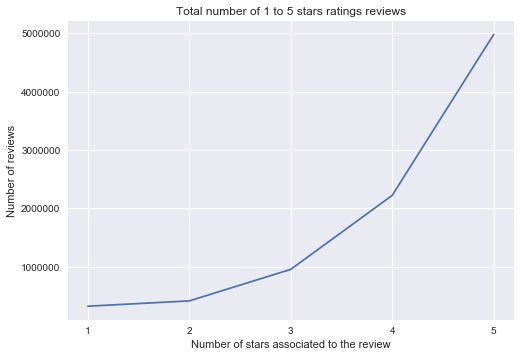

In [5]:
x = reviews_df_raw.columns
y = reviews_df_raw.sum()

plt.plot(x,y)
plt.title('Total number of 1 to 5 stars ratings reviews')
plt.ylabel('Number of reviews')
plt.xlabel('Number of stars associated to the review')
plt.xticks([1,2,3,4,5])

Let's try to plot the logarithm of y for this plot to see if we can find something interesting.

([<matplotlib.axis.XTick at 0x2641233c860>,
 <a list of 5 Text xticklabel objects>)

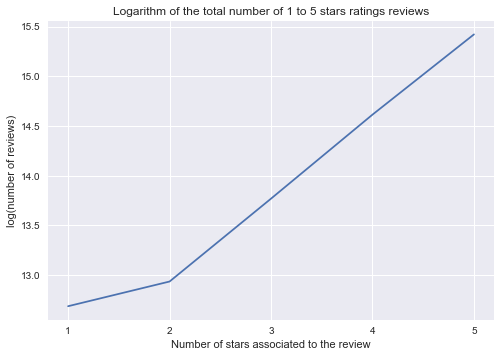

In [6]:
y2=np.log(y)
g=plt.plot(x,y2)

plt.title('Logarithm of the total number of 1 to 5 stars ratings reviews')
plt.ylabel('log(number of reviews)')
plt.xlabel('Number of stars associated to the review')
plt.xticks([1,2,3,4,5])

From 2 to 5 stars the logarithm of y gives a straight line! This means that people would give exponentially more 5 stars than 2 stars rating. This is a very interesting discovery that will be needed to be questionned further, by, for example, checking if in the Amazon rules concerning reviews something could explain this. 


#### We will now try to find "good books" , "controversial books" and "bad books" defined as follow:
* "good book"= many high ratings hew low ratings 
* "bad book" = many low ratings few high ratings  
* "controversial book" = any kind of ratings with small variance between number of reviews with 1,2,3,4 or 5 stars 


In [13]:
# merge the two datasets and calculate the "bad ratio" and "good_ratio" for each book
#bad_ratio and good_ratio are defined as the number of 1,2 stars (resp 4,5 stars) divided 
#by the total number of reviews 

d1['asin']=d1.index
reviews_df_raw['asin']=reviews_df_raw.index
reviews_df_tot=pd.merge(reviews_df_raw, d1, on=['asin'])
reviews_df_tot['bad_ratio']= (reviews_df_tot['1']+reviews_df_tot['2'])/(reviews_df_tot['1']+reviews_df_tot['2']+reviews_df_tot['3']+reviews_df_tot['4']+reviews_df_tot['5'])
reviews_df_tot['good_ratio']= (reviews_df_tot['4']+reviews_df_tot['5'])/(reviews_df_tot['1']+reviews_df_tot['2']+reviews_df_tot['3']+reviews_df_tot['4']+reviews_df_tot['5'])


reviews_df_tot.head()

1  2  3   4    5        asin      Avg_len  number_of_reviews  bad_ratio  \
0  6  4  8  15  173  000100039X   638.033981                206   0.048544   
1  0  4  2  10    2  0001055178  1308.611111                 18   0.222222   
2  1  0  0   2   13  0001473123   287.937500                 16   0.062500   
3  0  0  0   0    7  0001473727   187.571429                  7   0.000000   
4  0  0  1   0    5  0001473905   481.833333                  6   0.000000   

   good_ratio  
0    0.912621  
1    0.666667  
2    0.937500  
3    1.000000  
4    0.833333

For our analysis to make sense, we need to take books that have a significative number of reviews as if the book only has one or two reviews that is negative/positive, the book will be directly classified as a bad/good book and this is not reliable. However, if we take a minimum too high for the number of reviews of a book, we will have very few "bad books" as, we will see that the bulk of bad books have very few comments. 

We will try with a limit of 10 reviews. 

In [14]:
reviews_df = reviews_df_tot.copy()[reviews_df_tot.number_of_reviews>10]

In [15]:
# as a first guess, we can define bad books as having a bad ratio higher than 0.7 
#(respectively lower than 0.7 for good books)


#we will compare how many bad books we have if we consider the all dataset and if we consider only the books that have more than 10 reviews (for reliability)
bad_books_tot = reviews_df_tot[reviews_df_tot.bad_ratio>0.7]
bad_books = reviews_df[reviews_df.bad_ratio>0.7]

#As we have already a significant number of good and controversial books with our limit, we just consider with the limit 
good_books = reviews_df[reviews_df.good_ratio>0.7]
controversial_books= reviews_df[abs(reviews_df.good_ratio-reviews_df.bad_ratio)<0.1]



In [16]:
bad_books_tot.describe()

1           2           3           4           5  \
count  936.000000  936.000000  936.000000  936.000000  936.000000   
mean     5.973291    1.967949    0.591880    0.475427    0.849359   
std     16.132484    2.010411    1.105213    0.930433    4.037758   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      3.000000    1.000000    0.000000    0.000000    0.000000   
50%      4.000000    2.000000    0.000000    0.000000    0.000000   
75%      6.000000    3.000000    1.000000    1.000000    1.000000   
max    447.000000   20.000000   14.000000   12.000000  119.000000   

           Avg_len  number_of_reviews   bad_ratio  good_ratio  
count   936.000000         936.000000  936.000000  936.000000  
mean    852.246335           9.857906    0.816833    0.123201  
std     577.108054          21.163739    0.085686    0.095057  
min     116.666667           5.000000    0.704545    0.000000  
25%     449.900000           5.000000    0.750000    0.000000  
50%     710.778333           7.000000    0.800000    0.142857  
75%    1128.700000           9.000000    0.843117    0.200000  
max    6498.200000         582.000000    1.000000    0.294118

In [17]:
bad_books.describe()

1           2           3           4           5  \
count  185.000000  185.000000  185.000000  185.000000  185.000000   
mean    15.794595    3.372973    1.502703    1.140541    2.405405   
std     34.482998    3.216183    1.981228    1.671933    8.847929   
min      2.000000    0.000000    0.000000    0.000000    0.000000   
25%      7.000000    1.000000    0.000000    0.000000    0.000000   
50%     10.000000    3.000000    1.000000    1.000000    1.000000   
75%     16.000000    5.000000    2.000000    2.000000    2.000000   
max    447.000000   20.000000   14.000000   12.000000  119.000000   

           Avg_len  number_of_reviews   bad_ratio  good_ratio  
count   185.000000         185.000000  185.000000  185.000000  
mean    842.318764          24.216216    0.796491    0.134620  
std     440.475755          44.836257    0.077958    0.076236  
min     147.909091          11.000000    0.704545    0.000000  
25%     539.714286          12.000000    0.733333    0.076923  
50%     768.315789          15.000000    0.777070    0.138889  
75%    1090.764706          21.000000    0.833333    0.187500  
max    2494.909091         582.000000    1.000000    0.294118

As we said before, the number of 'bad books' depends a lot on the limit we take for the minimum number of reviews of our dataset. This might be due to the fact that when books have some bad comments, the books popularity drops and people stop reviewing them very fast. 

In [18]:
good_books.describe()

1              2              3              4  \
count  142711.000000  142711.000000  142711.000000  142711.000000   
mean        0.954432       1.410024       3.788601      10.963324   
std         3.312660       3.970387       9.158551      22.480132   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       3.000000   
50%         0.000000       0.000000       2.000000       6.000000   
75%         1.000000       1.000000       4.000000      11.000000   
max       229.000000     298.000000     607.000000    1271.000000   

                   5        Avg_len  number_of_reviews      bad_ratio  \
count  142711.000000  142711.000000      142711.000000  142711.000000   
mean       26.448417     847.175892          43.564799       0.049209   
std        59.200941     491.345135          92.935312       0.053780   
min         0.000000     121.909091          11.000000       0.000000   
25%         9.000000     464.714286          14.000000       0.000000   
50%        13.000000     749.948718          22.000000       0.038462   
75%        25.000000    1117.581144          40.000000       0.080000   
max      4839.000000    5850.666667        6717.000000       0.296296   

          good_ratio  
count  142711.000000  
mean        0.870685  
std         0.084861  
min         0.700315  
25%         0.806452  
50%         0.875000  
75%         0.934783  
max         1.000000

In [19]:
controversial_books.describe()

1            2            3            4            5  \
count  2810.000000  2810.000000  2810.000000  2810.000000  2810.000000   
mean      6.190747     5.680783     6.414591     5.698221     6.730961   
std      12.073168    10.577229    11.582232    12.215638    13.130457   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000     2.000000     2.000000     2.000000     3.000000   
50%       4.000000     4.000000     4.000000     3.000000     4.000000   
75%       6.000000     6.000000     7.000000     6.000000     7.000000   
max     359.000000   373.000000   397.000000   464.000000   457.000000   

           Avg_len  number_of_reviews    bad_ratio   good_ratio  
count  2810.000000        2810.000000  2810.000000  2810.000000  
mean    972.133560          30.715302     0.385675     0.402699  
std     554.989698          57.239637     0.066117     0.063787  
min     136.357143          11.000000     0.090909     0.153846  
25%     553.401786          13.000000     0.347826     0.363636  
50%     908.617908          17.000000     0.384615     0.406250  
75%    1270.751786          30.000000     0.428571     0.454545  
max    4822.833333        2050.000000     0.545455     0.548387

We can already notice that there are way less "bad books" according to our definition and it is very dependent of the limit that we impose for the minimum reviews taken into account in our dataset. This needs to be analysed further. 

As there are many outliers in our dataset, we will plot only robust variables. The first function defined below plots boxplots with outliers and the second one without the outliers. 

In [20]:
def plot_categories(column):
    # Create a figure with 2 subplots and set the title
    fig, ax = plt.subplots(figsize=(15,12), ncols=1, nrows=3)
    plt.suptitle("Boxplots of "+ column + " for three categories of books", fontsize=18)


    # Adjust the sub plots parameters
    hspace =  0.5   

    plt.subplots_adjust(
      hspace  =  hspace
    )


    # Set a title to each graph
    ax[0].set_title("Bad books", fontsize=15)
    ax[1].set_title("Good books", fontsize=15)
    ax[2].set_title("Controversial Books", fontsize=15)

    # Plot the data

    sns.boxplot( bad_books[column], ax=ax[0])
    sns.boxplot( good_books[column], ax= ax[1])
    sns.boxplot( controversial_books[column], ax=ax[2])

    plt.show()

In [21]:
def plot_categories_no_outliers(column):
    # Create a figure with 2 subplots and set the title
    fig, ax = plt.subplots(figsize=(15,12), ncols=1, nrows=3)
    plt.suptitle("Boxplots of "+ column + " for three categories of books", fontsize=18)


    # Adjust the sub plots parameters
    hspace =  0.5   

    plt.subplots_adjust(
      hspace  =  hspace
    )


    # Set a title to each graph
    ax[0].set_title("Bad books", fontsize=15)
    ax[1].set_title("Good books", fontsize=15)
    ax[2].set_title("Controversial Books", fontsize=15)

    # Plot the data

    sns.boxplot( bad_books[column], ax=ax[0], showfliers=False)
    sns.boxplot( good_books[column], ax= ax[1], showfliers=False)
    sns.boxplot( controversial_books[column], ax=ax[2], showfliers=False)

    plt.show()

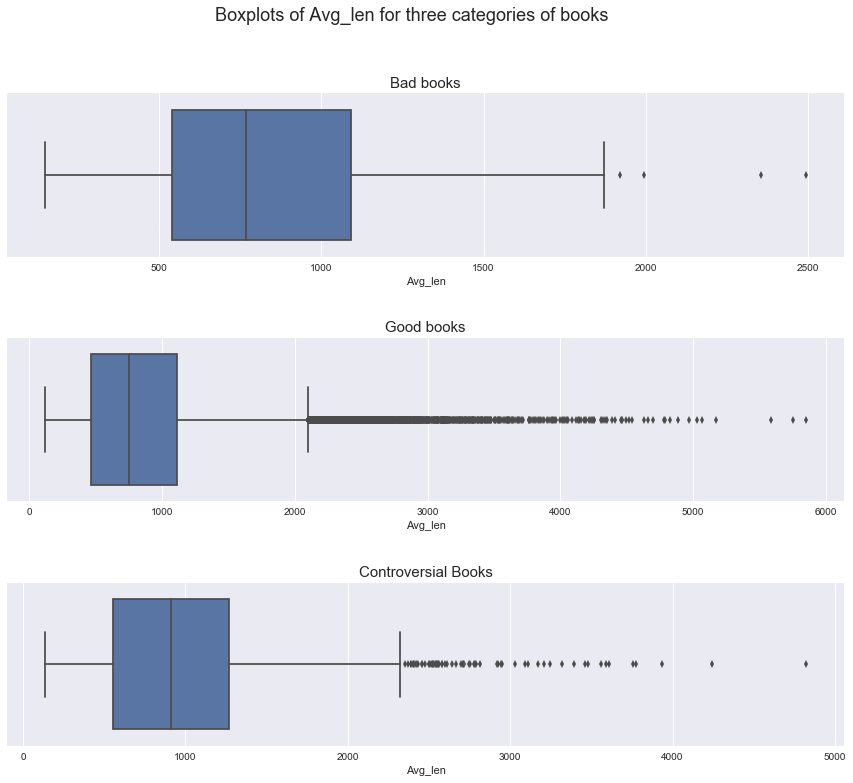

In [22]:
plot_categories('Avg_len')

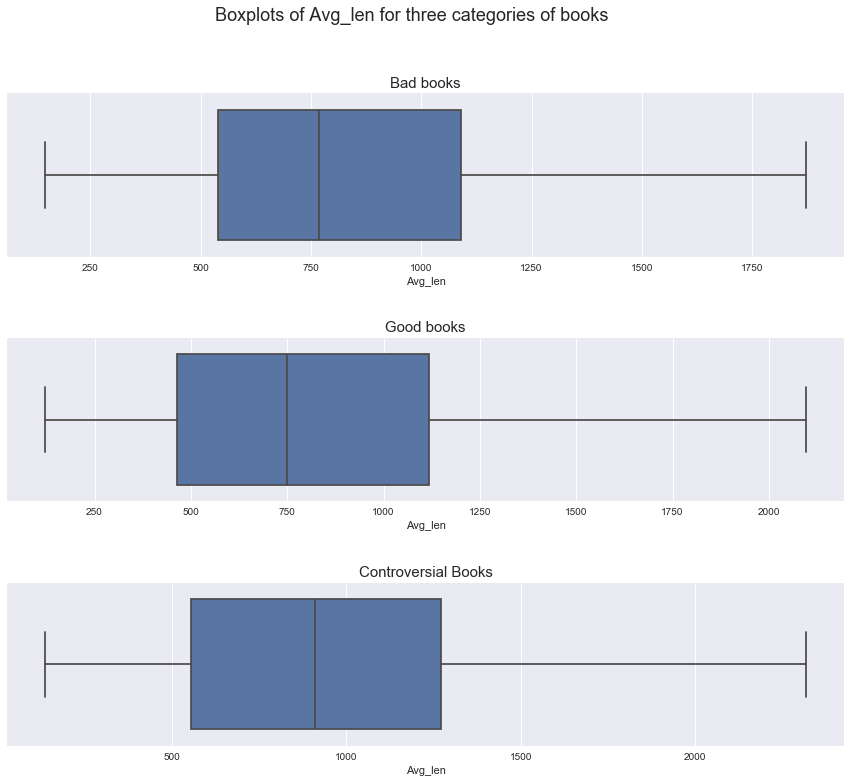

In [23]:
plot_categories_no_outliers('Avg_len')

The average length of the reviews is pretty well balanced through the groups. However, there are way more outliers (longer reviews) in the "good books" and "controversial books" than in the "bad books". The median for controversial books also seems to be a bit higher than for the two other categories. This could be explained by the fact that when people don't agree with each other they are more willing to write longer comments to explain their point of view. However, we see that we need to use more reliable statistics that the bad_ratio and good_ratio that we made up before to be able to draw conclusions. 

#### What we can do now is to try to refine our definitions for the books categories, and to do that we can try to consider mean and standard deviation of the ratings to have maybe more  interpretable results. 

We can calculate the mean and the standard deviation of ratings for each book. We can use these not robust statistics here as the ratings are bound between 1 and 5 so there are no outliers. 

In [34]:
# start again with a copy of our first dataset 
reviews_df_2 = reviews_df_tot.copy()
del reviews_df_2['bad_ratio']
del reviews_df_2['good_ratio']

reviews_df_2.head()

1  2  3   4    5        asin      Avg_len  number_of_reviews
0  6  4  8  15  173  000100039X   638.033981                206
1  0  4  2  10    2  0001055178  1308.611111                 18
2  1  0  0   2   13  0001473123   287.937500                 16
3  0  0  0   0    7  0001473727   187.571429                  7
4  0  0  1   0    5  0001473905   481.833333                  6

In [35]:
# calculate the mean for each book 

reviews_df_2 ['mean_rat'] = (reviews_df_2['1']*1+reviews_df_2['2']*2+reviews_df_2['3']*3+reviews_df_2['4']*4+reviews_df_2['5']*5)/reviews_df_2.number_of_reviews
reviews_df_2.head()


1  2  3   4    5        asin      Avg_len  number_of_reviews  mean_rat
0  6  4  8  15  173  000100039X   638.033981                206  4.674757
1  0  4  2  10    2  0001055178  1308.611111                 18  3.555556
2  1  0  0   2   13  0001473123   287.937500                 16  4.625000
3  0  0  0   0    7  0001473727   187.571429                  7  5.000000
4  0  0  1   0    5  0001473905   481.833333                  6  4.666667

([<matplotlib.axis.XTick at 0x223cea3a978>,
 <a list of 5 Text xticklabel objects>)

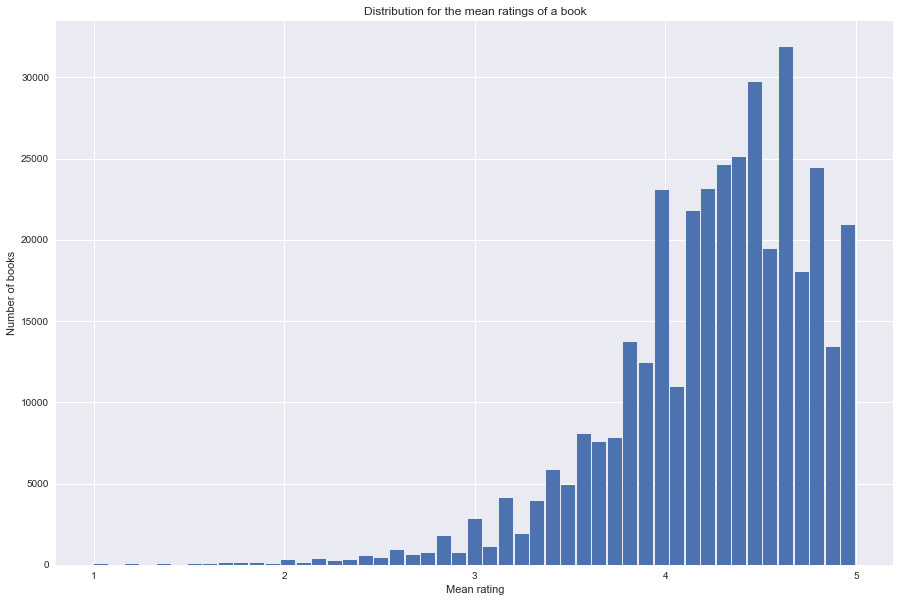

In [36]:
#Plot a histogram 
fig, ax = plt.subplots(figsize=(15,10), ncols=1, nrows=1)

reviews_df_2.mean_rat.hist(bins=np.linspace(1,5,50), rwidth=0.9)




plt.title('Distribution for the mean ratings of a book')
plt.xlabel('Mean rating')
plt.ylabel('Number of books')
plt.xticks([1,2,3,4,5])

We see that the distribution is completely left skewed and we will try to recentre it between 0 and 1 using this article http://rogeriofvieira.com/wp-content/uploads/2016/05/Data-Transformations-1.pdf.

From this article, we see that we can try two transformations: 

 - Logarithms : Growth rates are often exponential and log transforms will
often normalize them. Log transforms are particularly appropriate if the
variance increases with the mean.
 - Reciprocal : If a log transform does not normalize your data you could try a
reciprocal (1/x) transformation. This is often used for enzyme reaction rate
data. 


In [48]:
#Take the transformated weigthed mean as explained in the article 
reviews_df_2['Trans_weighted_mean'] = np.log10(6 - reviews_df_2['mean_rat'].values)

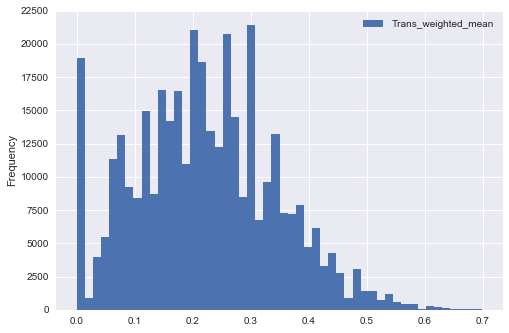

In [38]:
reviews_df_2.plot(y = 'Trans_weighted_mean', kind = 'hist', bins = 50, logx=False)

In [41]:
reviews_df_2['Inverse_weighted_mean'] = 1/(6 - reviews_df_2['mean_rat'].values)

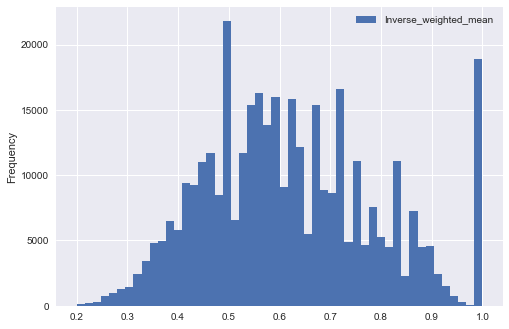

In [42]:
reviews_df_2.plot(y = 'Inverse_weighted_mean', kind = 'hist', bins = 50, logx=False)

We see that this doesn't give very smooth plots and this is due to the books that have just a few ratings and therefore will have values completely equal to 5 for example. As before, we will consider only books that have more than 10 reviews. 

In [43]:
reviews_df_sm = reviews_df_2.copy()[reviews_df_tot.number_of_reviews>10]

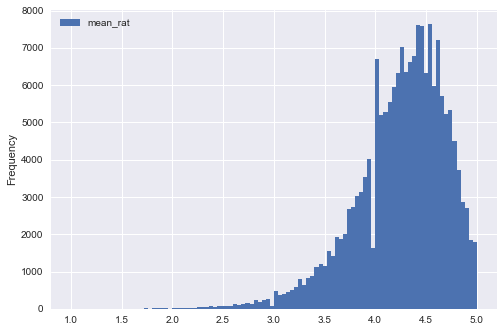

In [45]:
reviews_df_sm.plot(y = 'mean_rat', kind = 'hist', bins = 100, logx=False)

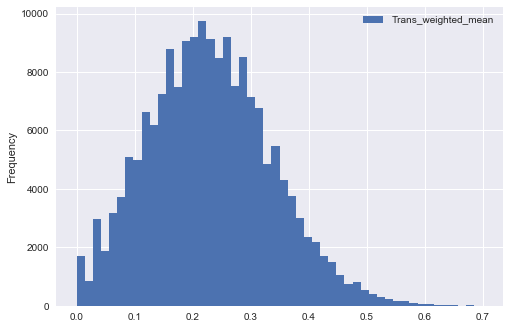

In [46]:
reviews_df_sm.plot(y = 'Trans_weighted_mean', kind = 'hist', bins = 50, logx=False)

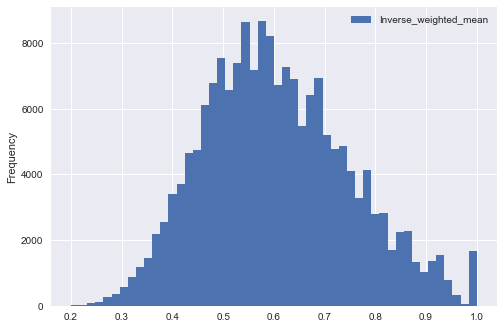

In [47]:
reviews_df_sm.plot(y = 'Inverse_weighted_mean', kind = 'hist', bins = 50, logx=False)

Now the graphs look way better. We can then refine our definitions for "good", "bad" and also add "neutral" books as following:

* "bad" book = the books in the 25% on the left of this plot
* "neutral" book = the books in the 50% in the middle of this plot
* "good" book = the books in the 25% on the right of this plot


We will also analyse the standard deviation to define what is a "controversial" book. 


## Data spliting into good vs. bad and controversial vs. non-controversial

Here we will ameliorate our previous analysis and use the average and standard deviation of the ratings associated to the reviews under a book to classify books into 6 categories: Good Neutral Bad Controversial Neutral(with regard to controversiality) and Uncontroversial. 

In [215]:
reviews_df = pd.DataFrame.from_csv('ratings_grouped_unstack.csv')
# Small set for testing
reviews_df_small = reviews_df.head(100)

In [216]:
reviews_df_small.head()

1  2  3   4    5
asin                        
000100039X  6  4  8  15  173
0001055178  0  4  2  10    2
0001473123  1  0  0   2   13
0001473727  0  0  0   0    7
0001473905  0  0  1   0    5

Stats calculation function:

In [217]:
def calculate_stats(df,index):
    ratings = []
    for ii in range(1,6):
        ratings = ratings + int(df.loc[index][str(ii)])*[ii]
    return np.mean(ratings),np.median(ratings),np.std(ratings)

### First test on small data set:

In [238]:
reviews_df_small = reviews_df_small.assign(total=reviews_df_small.sum(axis=1))

In [218]:
reviews_df_small = reviews_df_small.assign(mean = np.nan, median = np.nan, std_dev = np.nan)

for index in reviews_df_small.index:
    mean,median,std_dev = calculate_stats(reviews_df_small,index)
    reviews_df_small.at[index,'mean'] = mean
    reviews_df_small.at[index,'median'] = median
    reviews_df_small.at[index,'std_dev'] = std_dev
    
reviews_df_small.head()

1  2  3   4    5  total      mean  median   std_dev
asin                                                           
000100039X  6  4  8  15  173    206  4.674757     5.0  0.873584
0001055178  0  4  2  10    2     18  3.555556     4.0  0.955814
0001473123  1  0  0   2   13     16  4.625000     5.0  0.992157
0001473727  0  0  0   0    7      7  5.000000     5.0  0.000000
0001473905  0  0  1   0    5      6  4.666667     5.0  0.745356

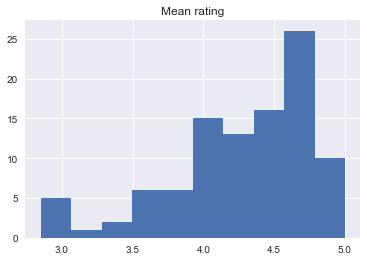

In [219]:
plt.hist(reviews_df_small['mean'])
plt.title('Mean rating')
plt.show()

### Then run on complete data set:

In [240]:
reviews_df = reviews_df.assign(total=reviews_df.iloc[:,:5].sum(axis=1))

In [221]:
reviews_df = reviews_df.assign(mean = np.nan, median = np.nan, std_dev = np.nan)

for index in reviews_df.index:
    mean,median,std_dev = calculate_stats(reviews_df,index)
    reviews_df.at[index,'mean'] = mean
    reviews_df.at[index,'median'] = median
    reviews_df.at[index,'std_dev'] = std_dev
    
reviews_df.head()

1  2  3   4    5       total      mean  median   std_dev
asin                                                                
000100039X  6  4  8  15  173  422.548341  4.674757     5.0  0.873584
0001055178  0  4  2  10    2   44.511369  3.555556     4.0  0.955814
0001473123  1  0  0   2   13   42.617157  4.625000     5.0  0.992157
0001473727  0  0  0   0    7   24.000000  5.000000     5.0  0.000000
0001473905  0  0  1   0    5   22.412023  4.666667     5.0  0.745356

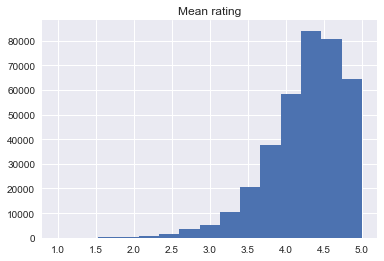

In [222]:
plt.hist(reviews_df['mean'],bins=15)
plt.title('Mean rating')
plt.show()

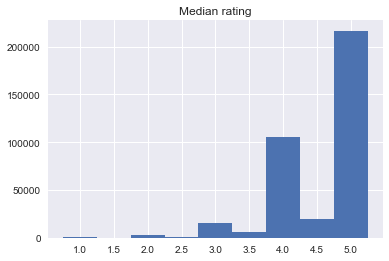

In [223]:
binrange = np.arange(1.0,6.0,0.5) # last bin needs to be from 5 to 5.5
plt.hist(reviews_df['median'],bins=binrange,align='left')
plt.title('Median rating')
plt.xticks(np.arange(1.0,5.5,0.5))
plt.show()

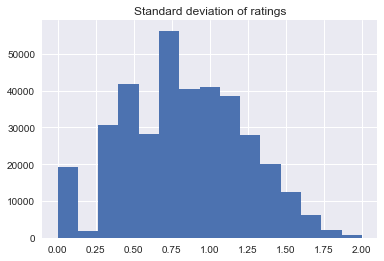

In [224]:
plt.hist(reviews_df['std_dev'],bins=15)
plt.title('Standard deviation of ratings')
plt.show()

In [225]:
np.percentile(sorted(list(reviews_df['mean'])),25)

4.0

In [226]:
np.percentile(sorted(list(reviews_df['mean'])),75)

4.625

In [227]:
np.percentile(sorted(list(reviews_df['std_dev'])),25)

0.50726923005551061

In [228]:
np.percentile(sorted(list(reviews_df['std_dev'])),75)

1.1180339887498949

In [243]:
reviews_df.head()

1  2  3   4    5  total      mean  median   std_dev
asin                                                           
000100039X  6  4  8  15  173    206  4.674757     5.0  0.873584
0001055178  0  4  2  10    2     18  3.555556     4.0  0.955814
0001473123  1  0  0   2   13     16  4.625000     5.0  0.992157
0001473727  0  0  0   0    7      7  5.000000     5.0  0.000000
0001473905  0  0  1   0    5      6  4.666667     5.0  0.745356

### Class assignments for all points

In [230]:
reviews_df_all = reviews_df.assign(goodness = 'none', controversiality = 'none')

In [244]:
reviews_df_all = reviews_df_all.assign(total=reviews_df_all.iloc[:,:5].sum(axis=1))

In [232]:
for index in reviews_df_all.index:
    if reviews_df_all.loc[index]['mean'] < 4.0:
        reviews_df_all.at[index,'goodness'] = 'bad'
    elif reviews_df_all.loc[index]['mean'] > 4.625:
        reviews_df_all.at[index,'goodness'] = 'good'
    else:
        reviews_df_all.at[index,'goodness'] = 'neutral'
    
    if reviews_df_all.loc[index]['std_dev'] < 0.50726923005551061:
        reviews_df_all.at[index,'controversiality'] = 'uncontroversial'
    elif reviews_df_all.loc[index]['std_dev'] > 1.1180339887498949:
        reviews_df_all.at[index,'controversiality'] = 'controversial'
    else:
        reviews_df_all.at[index,'controversiality'] = 'neutral'

In [233]:
reviews_df_all.loc[reviews_df_all['controversiality'] == 'controversial'].count()
#reviews_df_all.count()

1                   90621
2                   90621
3                   90621
4                   90621
5                   90621
total               90621
mean                90621
median              90621
std_dev             90621
controversiality    90621
goodness            90621
dtype: int64

### Class assignments for points with total > 9

Here we decided that the books with less than 10 reviews couldn't be classified as the mean and standard deviation need a big number of reviews to be significant. We will classify those books as none both in goodness and controversiality. 

In [246]:
reviews_df_10 = reviews_df.assign(goodness = 'none', controversiality = 'none')
reviews_df_10.head()

1  2  3   4    5  total      mean  median   std_dev  \
asin                                                              
000100039X  6  4  8  15  173    206  4.674757     5.0  0.873584   
0001055178  0  4  2  10    2     18  3.555556     4.0  0.955814   
0001473123  1  0  0   2   13     16  4.625000     5.0  0.992157   
0001473727  0  0  0   0    7      7  5.000000     5.0  0.000000   
0001473905  0  0  1   0    5      6  4.666667     5.0  0.745356   

           controversiality goodness  
asin                                  
000100039X             none     none  
0001055178             none     none  
0001473123             none     none  
0001473727             none     none  
0001473905             none     none

In [247]:
len(reviews_df.loc[reviews_df['total'] > 9])

196511

In [248]:
np.percentile(sorted(list(reviews_df.loc[reviews_df['total'] > 9]['mean'])),25)

4.0

In [249]:
np.percentile(sorted(list(reviews_df.loc[reviews_df['total'] > 9]['mean'])),75)

4.583333333333333

In [250]:
np.percentile(sorted(list(reviews_df.loc[reviews_df['total'] > 9]['std_dev'])),25)

0.65998148571120763

In [251]:
np.percentile(sorted(list(reviews_df.loc[reviews_df['total'] > 9]['std_dev'])),75)

1.1224972160321822

In [252]:
for index in reviews_df_10.index:
    if reviews_df_10.loc[index]['total'] > 9:
        if reviews_df_10.loc[index]['mean'] <= 4.0:
            reviews_df_10.at[index,'goodness'] = 'bad'
        elif reviews_df_10.loc[index]['mean'] >= 4.583333333333333:
            reviews_df_10.at[index,'goodness'] = 'good'
        else:
            reviews_df_10.at[index,'goodness'] = 'neutral'

        if reviews_df_10.loc[index]['std_dev'] <= 0.65998148571120763:
            reviews_df_10.at[index,'controversiality'] = 'uncontroversial'
        elif reviews_df_10.loc[index]['std_dev'] >= 1.1224972160321822:
            reviews_df_10.at[index,'controversiality'] = 'controversial'
        else:
            reviews_df_10.at[index,'controversiality'] = 'neutral'

In [253]:
reviews_df_10.head()

1  2  3   4    5  total      mean  median   std_dev  \
asin                                                              
000100039X  6  4  8  15  173    206  4.674757     5.0  0.873584   
0001055178  0  4  2  10    2     18  3.555556     4.0  0.955814   
0001473123  1  0  0   2   13     16  4.625000     5.0  0.992157   
0001473727  0  0  0   0    7      7  5.000000     5.0  0.000000   
0001473905  0  0  1   0    5      6  4.666667     5.0  0.745356   

           controversiality goodness  
asin                                  
000100039X          neutral     good  
0001055178          neutral      bad  
0001473123          neutral     good  
0001473727             none     none  
0001473905             none     none

In [254]:
reviews_df_10.loc[reviews_df_10['goodness'] == 'good'].count()

1                   49527
2                   49527
3                   49527
4                   49527
5                   49527
total               49527
mean                49527
median              49527
std_dev             49527
controversiality    49527
goodness            49527
dtype: int64

In [255]:
len(reviews_df_10.query('goodness=="bad" and controversiality=="controversial"'))
#goodvalue = 'good'
#controvalue = 'uncontroversial'
#len(reviews_df_10.query('goodness=="'+goodvalue+'" and controversiality=="'+controvalue+'"'))
#'goodness=='+goodvalue+' and controversiality=='+controvalue+''

33558

#### Cross-terms for all 9 categories

In [256]:
cross_terms = pd.DataFrame(index=["good","neutral","bad"])
cross_terms = cross_terms.assign(uncontroversial=-1)
cross_terms = cross_terms.assign(neutral=-1)
cross_terms = cross_terms.assign(controversial=-1)

for goodvalue in ["good","bad","neutral"]:
    for controvalue in ["uncontroversial","controversial","neutral"]:
        cross_terms[controvalue][goodvalue] = len(reviews_df_10.query('goodness=="'+goodvalue+'" and controversiality=="'+controvalue+'"'))
cross_terms

uncontroversial  neutral  controversial
good               37761    11610            156
neutral            10801    69502          15415
bad                  566    17142          33558

Here we notice that most of the good books are uncontroversial and most of the bad books are controversial. This is normal since it is directly related to the definitions we took with the standard deviation and mean. 

#### Some plots

(array([  1.60000000e+01,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   2.10000000e+01,
          1.41000000e+02,   1.02800000e+03,   1.12660000e+04,
          3.66530000e+04]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

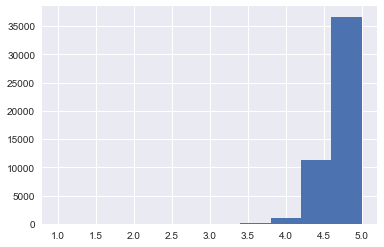

In [257]:
plt.hist(reviews_df_10.query('controversiality=="uncontroversial"')['mean'].values)

#### Save data frame to .csv

In [265]:
reviews_df_10.head()

1  2  3   4    5  total      mean  median   std_dev  \
asin                                                              
000100039X  6  4  8  15  173    206  4.674757     5.0  0.873584   
0001055178  0  4  2  10    2     18  3.555556     4.0  0.955814   
0001473123  1  0  0   2   13     16  4.625000     5.0  0.992157   
0001473727  0  0  0   0    7      7  5.000000     5.0  0.000000   
0001473905  0  0  1   0    5      6  4.666667     5.0  0.745356   

           controversiality goodness  
asin                                  
000100039X          neutral     good  
0001055178          neutral      bad  
0001473123          neutral     good  
0001473727             none     none  
0001473905             none     none

In [270]:
reviews_df_10.to_csv("classifications.csv")

#### Some extra plots:

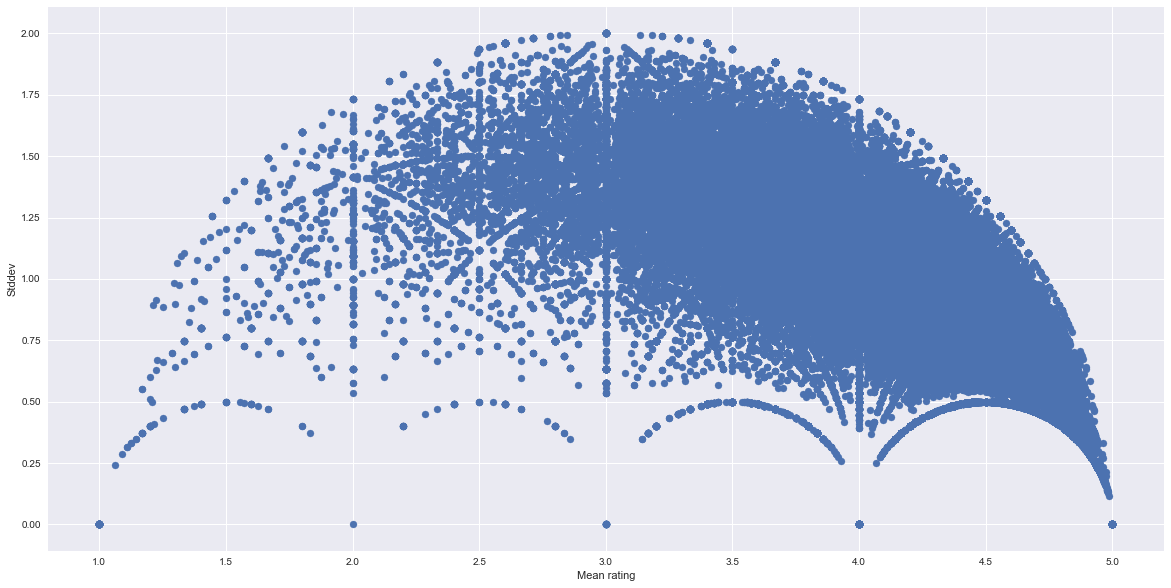

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(x=reviews_df['mean'],y=reviews_df['std_dev'])
plt.ylabel('Stddev')
plt.xlabel('Mean rating')

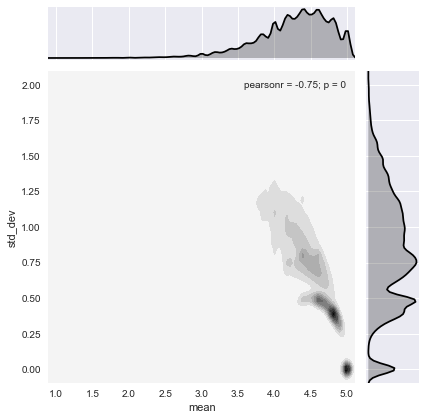

In [260]:
sns.jointplot(x=reviews_df['mean'],y=reviews_df['std_dev'],kind='kde',color='k')

## K-Means to cluster datapoints

Here we will try to classify our books into categories but using a machine learning technique (hear k_means). However, we will keep our classifications for books.

For n_clusters = 2 The average silhouette_score is : 0.605456255789
4401
10599


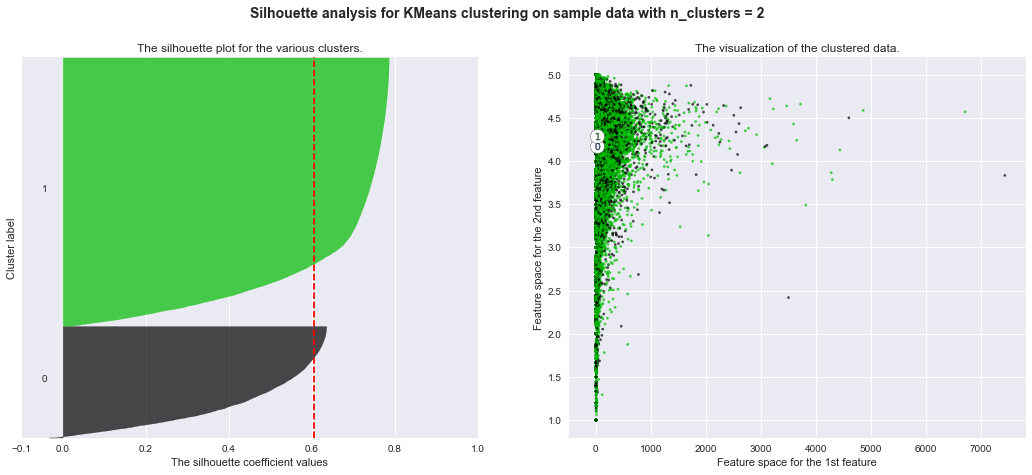

For n_clusters = 3 The average silhouette_score is : 0.565506575443
7945
1564
5491


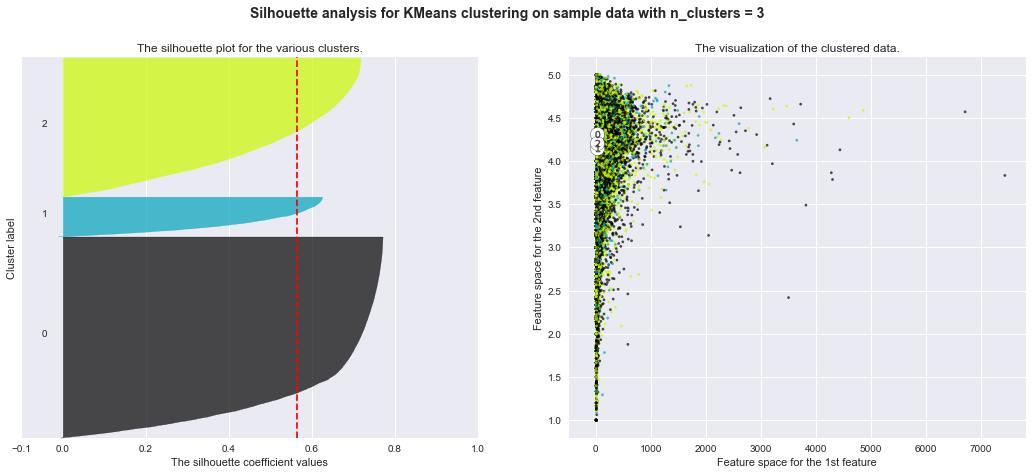

For n_clusters = 4 The average silhouette_score is : 0.549236961701
4995
2748
6565
692


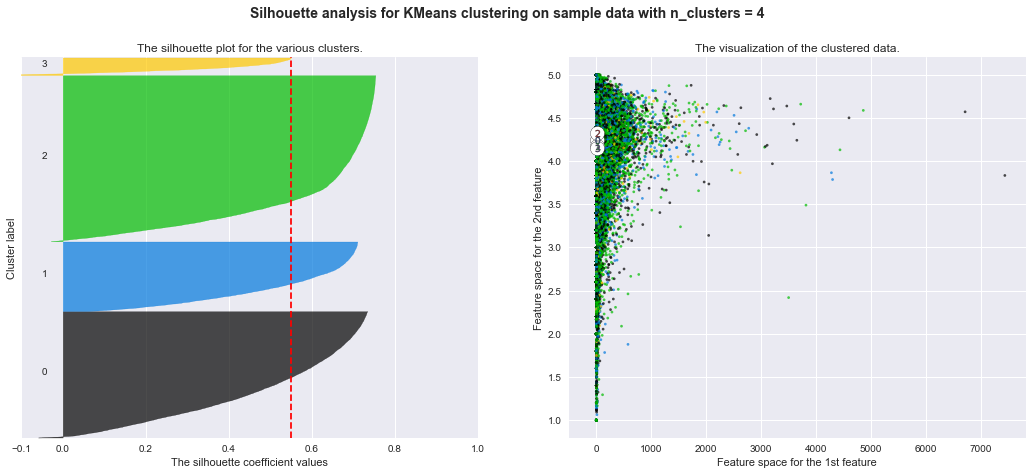

For n_clusters = 5 The average silhouette_score is : 0.52430263359
4181
486
3407
2143
4783


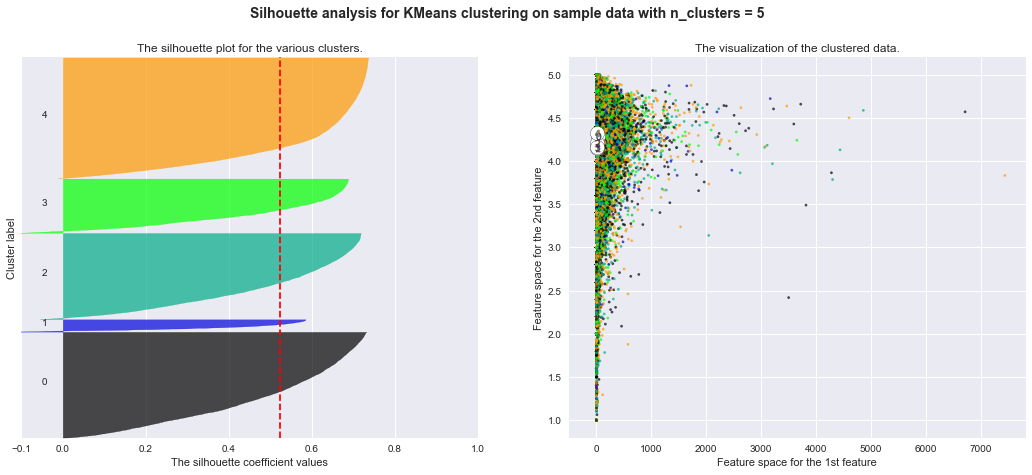

For n_clusters = 6 The average silhouette_score is : 0.51741134872
3297
2066
4316
1005
4031
285


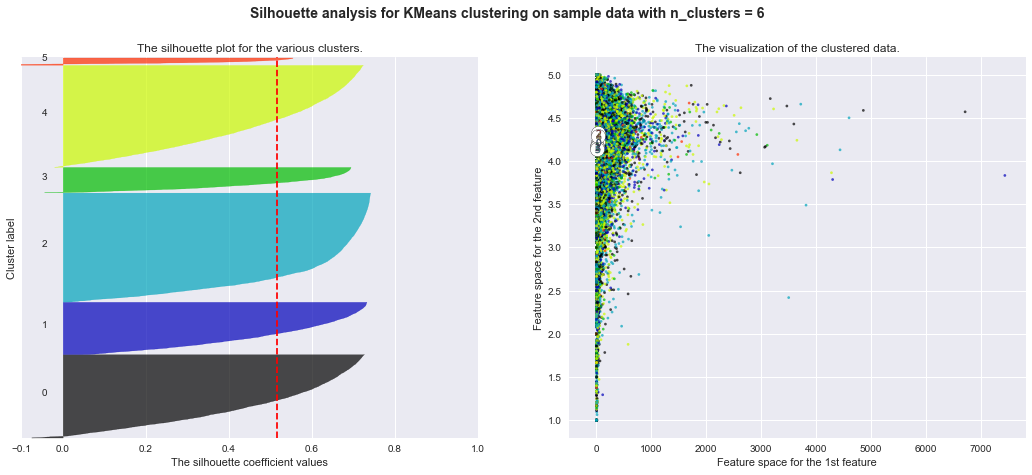

For n_clusters = 7 The average silhouette_score is : 0.497772266529
2599
1821
3254
925
3102
277
3022


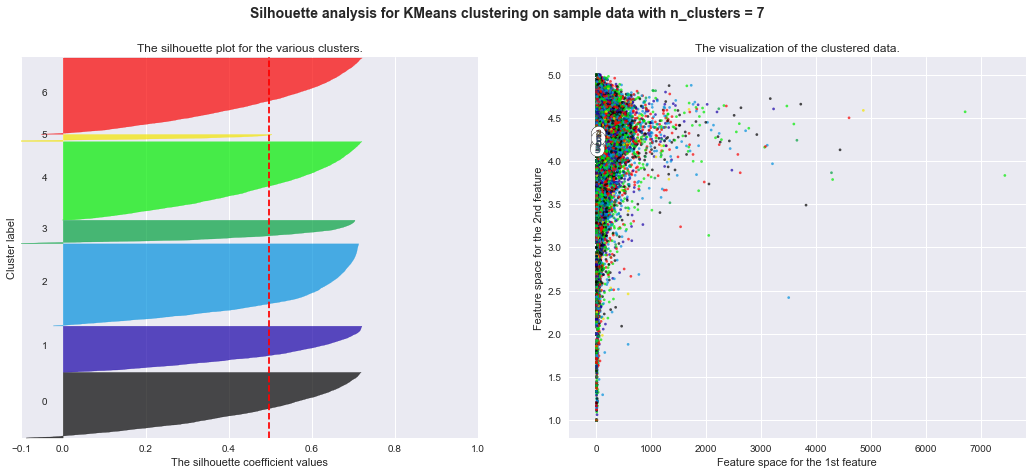

For n_clusters = 8 The average silhouette_score is : 0.504782891189
54
1674
3276
949
3099
288
3007
2653


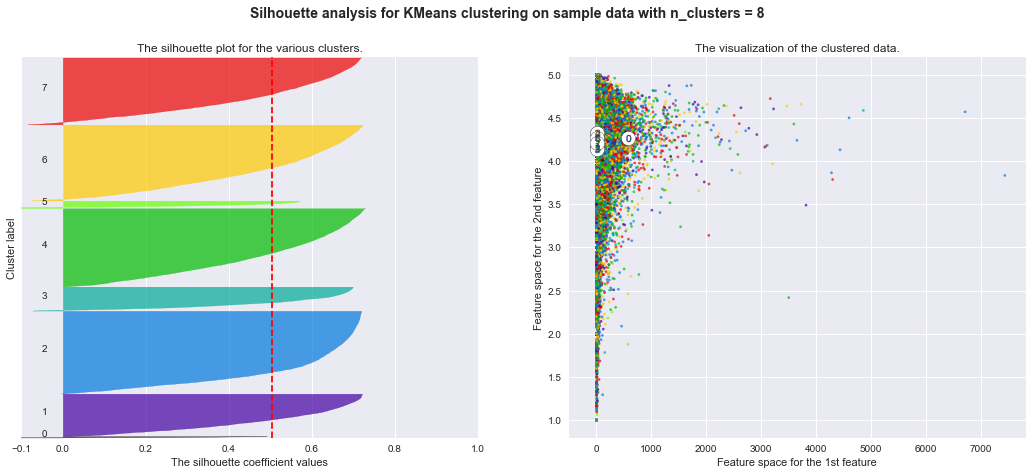

For n_clusters = 9 The average silhouette_score is : 0.47794246451
79
1746
2350
904
2503
242
2749
2628
1799


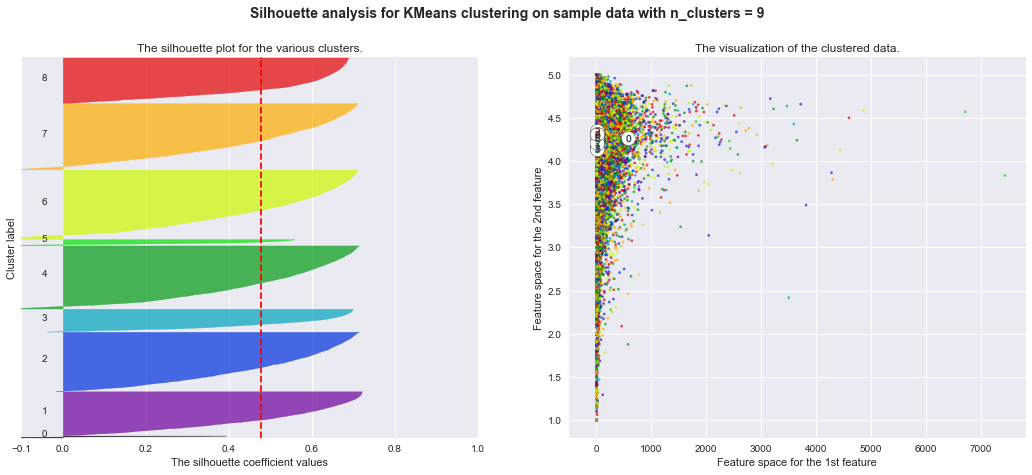

For n_clusters = 10 The average silhouette_score is : 0.43890444645
2025
255
2113
1572
1345
1479
1535
2076
1790
810


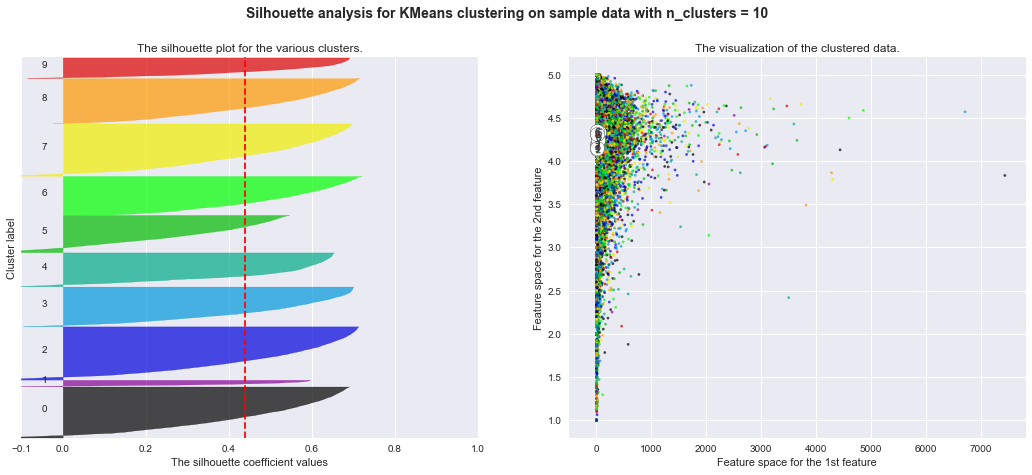

In [106]:
X = ratings_grouped_unstack_df[['Number_of_reviews', 'Weighted_mean', 'Std_dev', 'Avg_len']].values
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, 15000 + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.  
    clusterer = MiniBatchKMeans(init='random', n_clusters=n_clusters, batch_size=40000,
                      n_init=10, max_no_improvement=10, verbose=0, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels, sample_size=10000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    X_sample, cluster_labels_sample = resample(X, cluster_labels, replace = False, n_samples = 15000)
    sample_silhouette_values = silhouette_samples(X_sample, cluster_labels_sample)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels_sample == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        print(size_cluster_i)
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels_sample.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## Analysis with books classification

In this part we will use our classification of goodness and controversiality of books to analyse our dataset. 

In [3]:
categ_df = pd.read_csv('classifications.csv')

In [4]:
categ_df.head()

asin  1  2  3   4    5  total      mean  median   std_dev  \
0  000100039X  6  4  8  15  173    206  4.674757     5.0  0.873584   
1  0001055178  0  4  2  10    2     18  3.555556     4.0  0.955814   
2  0001473123  1  0  0   2   13     16  4.625000     5.0  0.992157   
3  0001473727  0  0  0   0    7      7  5.000000     5.0  0.000000   
4  0001473905  0  0  1   0    5      6  4.666667     5.0  0.745356   

  controversiality goodness  
0          neutral     good  
1          neutral      bad  
2          neutral     good  
3             none     none  
4             none     none

In [15]:
review_df.head()

asin             reviewerID  overall  rew_compound  \
unixReviewTime                                                                  
2012-12-16 01:00:00  000100039X  A10000012B7CGYKOMPQ4L      5.0        0.7256   
2003-12-11 01:00:00  000100039X         A2S166WSCFIFP5      5.0        0.8349   
2014-01-18 01:00:00  000100039X         A1BM81XB4QHOA3      5.0        0.4404   
2011-09-27 02:00:00  000100039X         A1MOSTXNIO5MPJ      5.0        0.9201   
2002-10-07 02:00:00  000100039X         A2XQ5LZHTD4AFT      5.0        0.9800   

                    controversiality goodness  
unixReviewTime                                 
2012-12-16 01:00:00          neutral     good  
2003-12-11 01:00:00          neutral     good  
2014-01-18 01:00:00          neutral     good  
2011-09-27 02:00:00          neutral     good  
2002-10-07 02:00:00          neutral     good

Each line corresponds to one review where the asin is the book reviewed, the unixreviextime is the time of the review, the overall score is the rating given along with the review, the rew compound is the vader score calculated.

In [168]:
good_df = review_df.loc[review_df.goodness == 'good']
Ngood = good_df.shape[0]
good_df.head()

asin             reviewerID  overall  rew_compound  \
unixReviewTime                                                                  
2012-12-16 01:00:00  000100039X  A10000012B7CGYKOMPQ4L      5.0        0.7256   
2003-12-11 01:00:00  000100039X         A2S166WSCFIFP5      5.0        0.8349   
2014-01-18 01:00:00  000100039X         A1BM81XB4QHOA3      5.0        0.4404   
2011-09-27 02:00:00  000100039X         A1MOSTXNIO5MPJ      5.0        0.9201   
2002-10-07 02:00:00  000100039X         A2XQ5LZHTD4AFT      5.0        0.9800   

                    controversiality goodness  
unixReviewTime                                 
2012-12-16 01:00:00          neutral     good  
2003-12-11 01:00:00          neutral     good  
2014-01-18 01:00:00          neutral     good  
2011-09-27 02:00:00          neutral     good  
2002-10-07 02:00:00          neutral     good

In [169]:
bad_df = review_df.loc[review_df.goodness == 'bad']
Nbad = bad_df.shape[0]
bad_df.head()

asin      reviewerID  overall  rew_compound  \
unixReviewTime                                                           
2001-04-24 02:00:00  0001055178   A3JD7EO66IBTO      3.0       -0.6455   
2000-02-13 01:00:00  0001055178  A177RENQJIMMR9      4.0        0.8508   
2008-09-03 02:00:00  0001055178   AI4MUD97FH6G2      2.0       -0.2579   
2002-03-14 01:00:00  0001055178   ATWVC3WQOZSFS      3.0        0.8779   
2010-08-08 02:00:00  0001055178  A3VIOCJZ22JZXT      5.0        0.9381   

                    controversiality goodness  
unixReviewTime                                 
2001-04-24 02:00:00          neutral      bad  
2000-02-13 01:00:00          neutral      bad  
2008-09-03 02:00:00          neutral      bad  
2002-03-14 01:00:00          neutral      bad  
2010-08-08 02:00:00          neutral      bad

In [170]:
neutral_df = review_df.loc[review_df.goodness == 'neutral']
Nneutral = neutral_df.shape[0]
contr_df = review_df.loc[review_df.controversiality == 'controversial']
Ncontr = contr_df.shape[0]
uncontr_df = review_df.loc[review_df.controversiality == 'uncontroversial']
Nuncontr = uncontr_df.shape[0]
neutrcontr_df = review_df.loc[review_df.controversiality == 'neutral']
Nneutrcontr = neutrcontr_df.shape[0]

Text(0,0.5,'Mean rating for books')

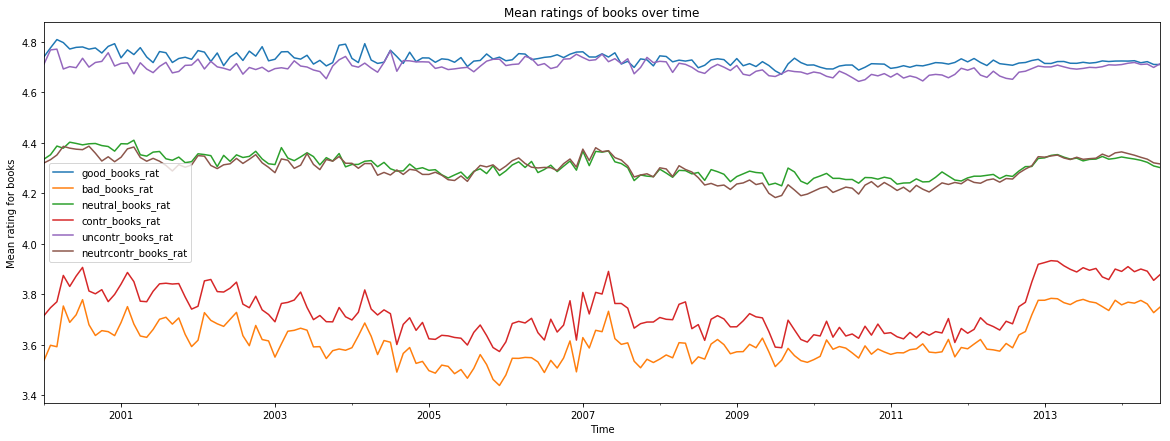

In [171]:
good_df_mean_m = good_df.groupby(good_df.index.to_period('M')).mean()
good_df_mean_m = good_df_mean_m.loc[ good_df_mean_m.index >= '2000']
bad_df_mean_m = bad_df.groupby(bad_df.index.to_period('M')).mean()
bad_df_mean_m = bad_df_mean_m.loc[ bad_df_mean_m.index >= '2000']
neutral_df_mean_m = neutral_df.groupby(neutral_df.index.to_period('M')).mean()
neutral_df_mean_m = neutral_df_mean_m.loc[ neutral_df_mean_m.index >= '2000']
contr_df_mean_m = contr_df.groupby(contr_df.index.to_period('M')).mean()
contr_df_mean_m = contr_df_mean_m.loc[ contr_df_mean_m.index >= '2000']
uncontr_df_mean_m = uncontr_df.groupby(uncontr_df.index.to_period('M')).mean()
uncontr_df_mean_m = uncontr_df_mean_m.loc[ uncontr_df_mean_m.index >= '2000']
neutrcontr_df_mean_m = neutrcontr_df.groupby(neutrcontr_df.index.to_period('M')).mean()
neutrcontr_df_mean_m = neutrcontr_df_mean_m.loc[ neutrcontr_df_mean_m.index >= '2000']

good_df_mean_m.columns = ['good_books_rat','good_books_comp']
bad_df_mean_m.columns = ['bad_books_rat','bad_books_comp']
neutral_df_mean_m.columns = ['neutral_books_rat','neutral_books_comp']
contr_df_mean_m.columns = ['contr_books_rat','contr_books_comp']
uncontr_df_mean_m.columns = ['uncontr_books_rat','uncontr_books_comp']
neutrcontr_df_mean_m.columns = ['neutrcontr_books_rat','neutrcontr_books_comp']

goodness_df_m = good_df_mean_m.join(bad_df_mean_m).join(neutral_df_mean_m).join(contr_df_mean_m).join(uncontr_df_mean_m).join(neutrcontr_df_mean_m)
goodness_df_m[['good_books_rat','bad_books_rat','neutral_books_rat','contr_books_rat','uncontr_books_rat','neutrcontr_books_rat']].plot(figsize=(20,7))
plt.title('Mean ratings of books over time')
plt.xlabel('Time')
plt.ylabel('Mean rating for books')

This shows again that most of the good books are uncontroversial ones and most of bad books are controversial ones as the lines are very close. What we also see is that good books and uncontroversial have a mean rating that is very high and very steady in time. However, the controversial books and the bad books have a mean rating that is not very steady, they are also controversial in time. 

In [ ]:
GC0 = good_df.loc[good_df.controversiality == 'controversial']
GC = GC0.groupby(GC0.index.to_period('M')).mean()
GC = GC.loc[ GC.index >= '2000']

GU0 = good_df.loc[good_df.controversiality == 'uncontroversial']
GU = GU0.groupby(GU0.index.to_period('M')).mean()
GU = GU.loc[ GU.index >= '2000']

GN0 = good_df.loc[good_df.controversiality == 'neutral']
GN = GN0.groupby(GN0.index.to_period('M')).mean()
GN = GN.loc[ GN.index >= '2000']

BC0 = bad_df.loc[bad_df.controversiality == 'controversial']
BC = BC0.groupby(BC0.index.to_period('M')).mean()
BC = BC.loc[ BC.index >= '2000']

BU0 = bad_df.loc[bad_df.controversiality == 'uncontroversial']
BU = BU0.groupby(BU0.index.to_period('M')).mean()
BU = BU.loc[ BU.index >= '2000']

BN0 = bad_df.loc[bad_df.controversiality == 'neutral']
BN = BN0.groupby(BN0.index.to_period('M')).mean()
BN = BN.loc[ BN.index >= '2000']

NC0 = neutral_df.loc[neutral_df.controversiality == 'controversial']
NC = NC0.groupby(NC0.index.to_period('M')).mean()
NC = NC.loc[ NC.index >= '2000']

NU0 = neutral_df.loc[neutral_df.controversiality == 'uncontroversial']
NU = NU0.groupby(NU0.index.to_period('M')).mean()
NU = NU.loc[ NU.index >= '2000']

NN0 = neutral_df.loc[neutral_df.controversiality == 'neutral']
NN = NN0.groupby(NN0.index.to_period('M')).mean()
NN = NN.loc[ NN.index >= '2000']

GC.columns = ['goodcontr_books_rat','goodcontr_books_comp']
GU.columns = ['gooduncontr_books_rat','gooduncontr_books_comp']
GN.columns = ['goodneutr_books_rat','goodneutr_books_comp']
BC.columns = ['badcontr_books_rat','badcontr_books_comp']
BU.columns = ['baduncontr_books_rat','baduncontr_books_comp']
BN.columns = ['badneutr_books_rat','badneutr_books_comp']
NC.columns = ['neutrcontr_books_rat','neutrcontr_books_comp']
NU.columns = ['neutruncontr_books_rat','neutruncontr_books_comp']
NN.columns = ['neutrneutr_books_rat','neutrneutr_books_comp']

goodness_df_m = GC.join(GU).join(GN).join(BC).join(BU).join(BN).join(NC).join(NU).join(NN)
goodness_df_m[['goodcontr_books_rat','gooduncontr_books_rat','goodneutr_books_rat',
               'badcontr_books_rat','baduncontr_books_rat','badneutr_books_rat',
               'neutrcontr_books_rat','neutruncontr_books_rat','neutrneutr_books_rat']].plot(figsize=(20,7))
plt.title('Mean ratings of books over time')
plt.xlabel('Time')
plt.ylabel('Mean rating for books')

The lines for good and controversial books and for bad and uncotnroversial books are way less smooth but that is because there are only a few books in those categories. However, we can still notice that their lines are varying more over time compared to the other categories. 

Text(0,0.5,'Number or reviews in the month')

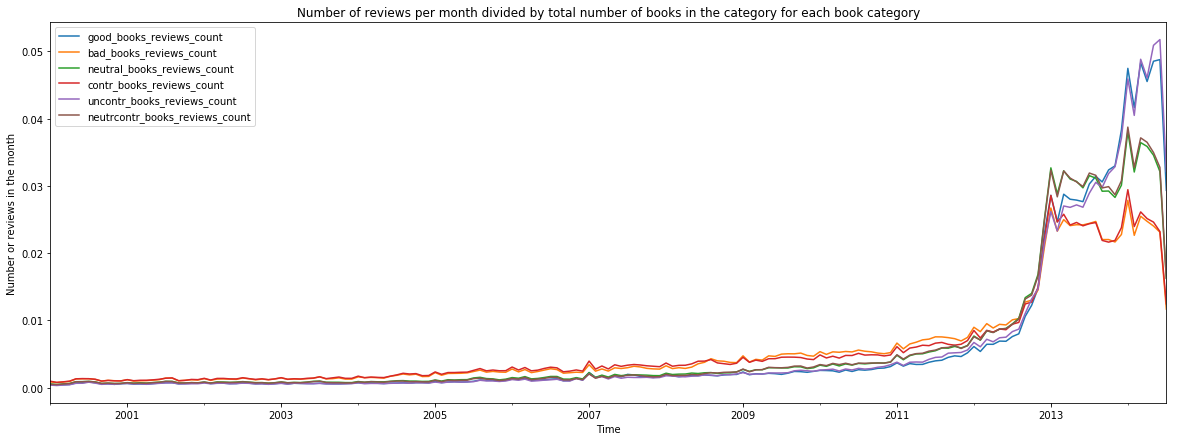

In [173]:
#number of comments with time 


good_df_count_m = good_df.groupby(good_df.index.to_period('M')).count()
good_df_count_m = good_df_count_m.loc[ good_df_count_m.index >= '2000'][['asin']]/Ngood
good_df_count_m.columns = ['good_books_reviews_count']

bad_df_count_m = bad_df.groupby(bad_df.index.to_period('M')).count()
bad_df_count_m = bad_df_count_m.loc[ bad_df_count_m.index >= '2000'][['asin']]/Nbad
bad_df_count_m.columns = ['bad_books_reviews_count']

neutral_df_count_m = neutral_df.groupby(neutral_df.index.to_period('M')).count()
neutral_df_count_m = neutral_df_count_m.loc[ neutral_df_count_m.index >= '2000'][['asin']]/Nneutral
neutral_df_count_m.columns = ['neutral_books_reviews_count']


contr_df_count_m = contr_df.groupby(contr_df.index.to_period('M')).count()
contr_df_count_m = contr_df_count_m.loc[ contr_df_count_m.index >= '2000'][['asin']]/Ncontr
contr_df_count_m.columns = ['contr_books_reviews_count']

uncontr_df_count_m = uncontr_df.groupby(uncontr_df.index.to_period('M')).count()
uncontr_df_count_m = uncontr_df_count_m.loc[ uncontr_df_count_m.index >= '2000'][['asin']]/Nuncontr
uncontr_df_count_m.columns = ['uncontr_books_reviews_count']

neutrcontr_df_count_m = neutrcontr_df.groupby(neutrcontr_df.index.to_period('M')).count()
neutrcontr_df_count_m = neutrcontr_df_count_m.loc[ neutrcontr_df_count_m.index >= '2000'][['asin']]/Nneutrcontr
neutrcontr_df_count_m.columns = ['neutrcontr_books_reviews_count']

goodness_df_count_m = good_df_count_m.join(bad_df_count_m).join(neutral_df_count_m).join(contr_df_count_m).join(uncontr_df_count_m).join(neutrcontr_df_count_m)

goodness_df_count_m.plot(figsize=(20,7))
plt.title('Number of reviews per month divided by total number of books in the category for each book category')
plt.xlabel('Time')
plt.ylabel('Number or reviews in the month')

Here we can see that the evolutions are very similar for all types of books, there is still something happening in 2012 in the Amazon website regarding reviews but it is a general pattern.

Text(0,0.5,'Number or reviews in the month')

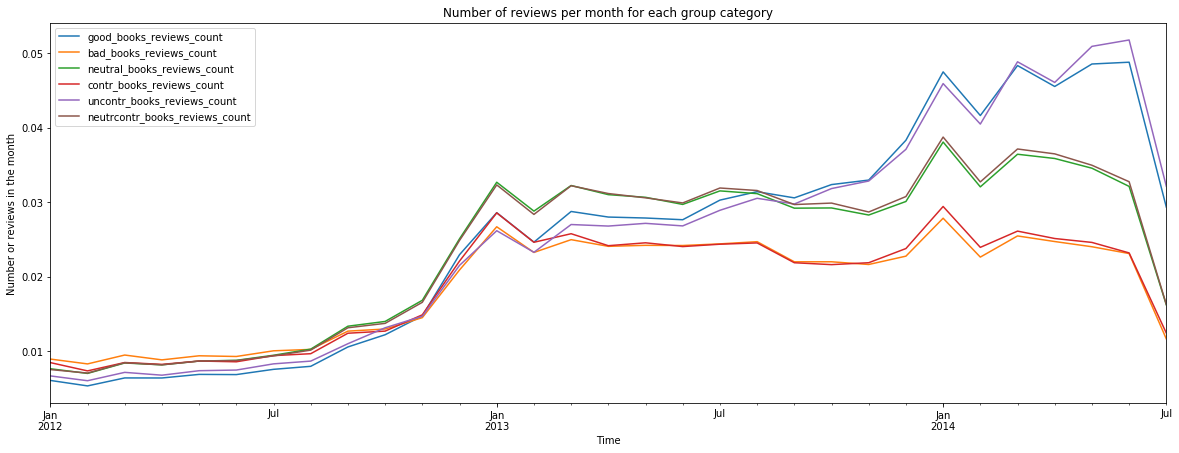

In [105]:
#number of comments with time 


good_df_count_m = good_df.groupby(good_df.index.to_period('M')).count()
good_df_count_m = good_df_count_m.loc[ good_df_count_m.index >= '2012'][['asin']]/Ngood
good_df_count_m.columns = ['good_books_reviews_count']

bad_df_count_m = bad_df.groupby(bad_df.index.to_period('M')).count()
bad_df_count_m = bad_df_count_m.loc[ bad_df_count_m.index >= '2012'][['asin']]/Nbad
bad_df_count_m.columns = ['bad_books_reviews_count']

neutral_df_count_m = neutral_df.groupby(neutral_df.index.to_period('M')).count()
neutral_df_count_m = neutral_df_count_m.loc[ neutral_df_count_m.index >= '2012'][['asin']]/Nneutral
neutral_df_count_m.columns = ['neutral_books_reviews_count']


contr_df_count_m = contr_df.groupby(contr_df.index.to_period('M')).count()
contr_df_count_m = contr_df_count_m.loc[ contr_df_count_m.index >= '2012'][['asin']]/Ncontr
contr_df_count_m.columns = ['contr_books_reviews_count']

uncontr_df_count_m = uncontr_df.groupby(uncontr_df.index.to_period('M')).count()
uncontr_df_count_m = uncontr_df_count_m.loc[ uncontr_df_count_m.index >= '2012'][['asin']]/Nuncontr
uncontr_df_count_m.columns = ['uncontr_books_reviews_count']

neutrcontr_df_count_m = neutrcontr_df.groupby(neutrcontr_df.index.to_period('M')).count()
neutrcontr_df_count_m = neutrcontr_df_count_m.loc[ neutrcontr_df_count_m.index >= '2012'][['asin']]/Nneutrcontr
neutrcontr_df_count_m.columns = ['neutrcontr_books_reviews_count']

goodness_df_count_m = good_df_count_m.join(bad_df_count_m).join(neutral_df_count_m).join(contr_df_count_m).join(uncontr_df_count_m).join(neutrcontr_df_count_m)

goodness_df_count_m.plot(figsize=(20,7))
plt.title('Number of reviews per month for each group category')
plt.xlabel('Time')
plt.ylabel('Number or reviews in the month')

Before Jan 2013, all the lines are very close which means that all types of books were commented the same. The increase in early 2014 was higher for the good books and uncontroversial books than for the other categories. 

In [24]:
#have a look at the outliers 

In [22]:
badcontr_df = bad_df.loc[bad_df.controversiality == "uncontroversial"]
baduncontr_df = bad_df.loc[bad_df.controversiality == "uncontroversial"]

In [26]:
goodcontr_df = good_df.loc[good_df.controversiality == "controversial"]

Text(0,0.5,'Number or reviews in the month')

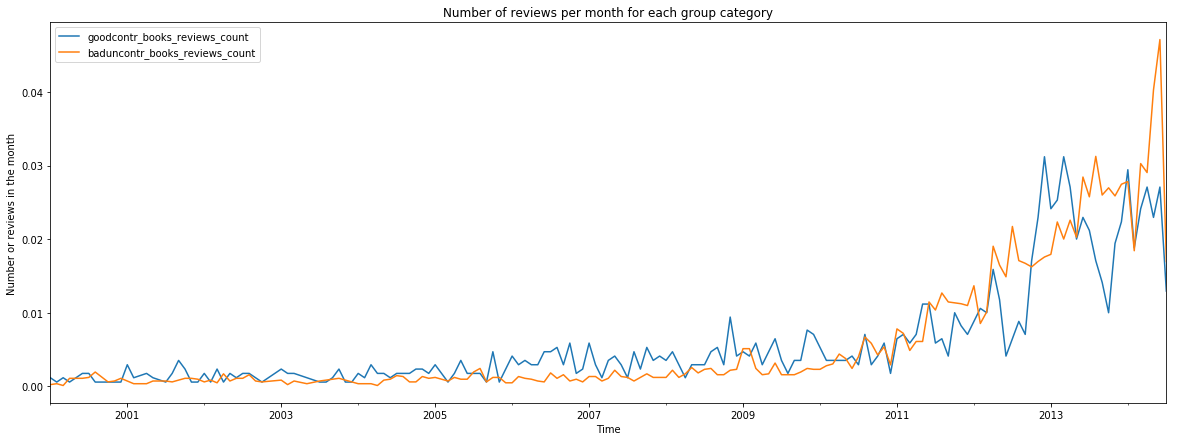

In [101]:
Ngoodcontr = goodcontr_df.shape[0]
Nbaduncontr = baduncontr_df.shape[0]
goodcontr_df_count_m = goodcontr_df.groupby(goodcontr_df.index.to_period('M')).count()
goodcontr_df_count_m = goodcontr_df_count_m.loc[ goodcontr_df_count_m.index >= '2000'][['asin']]/Ngoodcontr
goodcontr_df_count_m.columns = ['goodcontr_books_reviews_count']

baduncontr_df_count_m = baduncontr_df.groupby(baduncontr_df.index.to_period('M')).count()
baduncontr_df_count_m = baduncontr_df_count_m.loc[ baduncontr_df_count_m.index >= '2000'][['asin']]/Nbaduncontr
baduncontr_df_count_m.columns = ['baduncontr_books_reviews_count']


outliers_df_count_m = goodcontr_df_count_m.join(baduncontr_df_count_m)

outliers_df_count_m.plot(figsize=(20,7))
plt.title('Number of reviews per month for each group category')
plt.xlabel('Time')
plt.ylabel('Number or reviews in the month')

Here we see that the lines are way less smooth again this is because in those categories there are way fewer books. 

Text(0,0.5,'Number of reviews divided by total number of books in category')

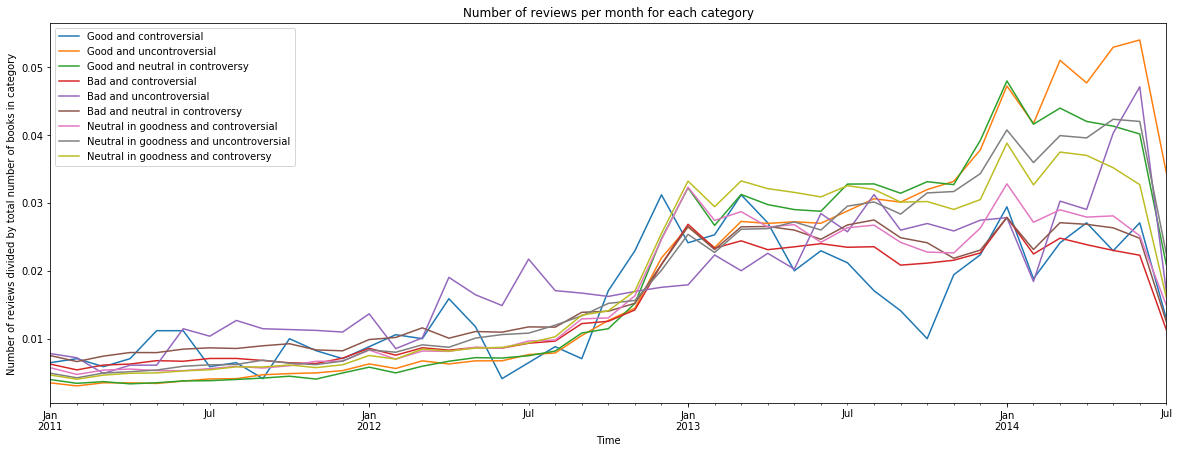

In [109]:
Ngc= GC0.shape[0]
GC = GC0.groupby(GC0.index.to_period('M')).count()
GC = GC.loc[ GC.index >= '2011'][['asin']]/Ngc
GC.columns = ['Good and controversial']

Ngu= GU0.shape[0]
GU = GU0.groupby(GU0.index.to_period('M')).count()
GU = GU.loc[ GU.index >= '2011'][['asin']]/Ngu
GU.columns =['Good and uncontroversial']

Ngn= GN0.shape[0]
GN = GN0.groupby(GN0.index.to_period('M')).count()
GN = GN.loc[ GN.index >= '2011'][['asin']]/Ngn
GN.columns = ['Good and neutral in controversy']

Nbc=BC0.shape[0]
BC = BC0.groupby(BC0.index.to_period('M')).count()
BC = BC.loc[ BC.index >= '2011'][['asin']]/Nbc
BC.columns = ['Bad and controversial']


Nbu=BU0.shape[0]
BU = BU0.groupby(BU0.index.to_period('M')).count()
BU = BU.loc[ BU.index >= '2011'][['asin']]/Nbu
BU.columns = ['Bad and uncontroversial']

Nbn = BN0.shape[0]
BN = BN0.groupby(BN0.index.to_period('M')).count()
BN = BN.loc[ BN.index >= '2011'][['asin']]/Nbn
BN.columns= ['Bad and neutral in controversy']

Nnc=NC0.shape[0]
NC = NC0.groupby(NC0.index.to_period('M')).count()
NC = NC.loc[ NC.index >= '2011'][['asin']]/Nnc
NC.columns = ['Neutral in goodness and controversial']

Nnu = NU0.shape[0]
NU = NU0.groupby(NU0.index.to_period('M')).count()
NU = NU.loc[ NU.index >= '2011'][['asin']]/Nnu
NU.columns = ['Neutral in goodness and uncontroversial']

Nnn=NN0.shape[0]
NN = NN0.groupby(NN0.index.to_period('M')).count()
NN = NN.loc[ NN.index >= '2011'][['asin']]/Nnn
NN.columns = ['Neutral in goodness and controversy']

goodness_df_m = GC.join(GU).join(GN).join(BC).join(BU).join(BN).join(NC).join(NU).join(NN)
goodness_df_m.plot(figsize=(20,7))
plt.title('Number of reviews per month for each category')
plt.xlabel('Time')
plt.ylabel('Number of reviews divided by total number of books in category')




Again, there is hardly any difference between the evolution in the number of reviews from 2011 to 2014 for the different categories. The blue line and purple one are less smooth given that there are less books in those categories.

In [ ]:
#number of reviews per month for different number of stars 

In [42]:
review_df.head()

asin             reviewerID  overall  rew_compound  \
unixReviewTime                                                                  
2012-12-16 01:00:00  000100039X  A10000012B7CGYKOMPQ4L      5.0        0.7256   
2003-12-11 01:00:00  000100039X         A2S166WSCFIFP5      5.0        0.8349   
2014-01-18 01:00:00  000100039X         A1BM81XB4QHOA3      5.0        0.4404   
2011-09-27 02:00:00  000100039X         A1MOSTXNIO5MPJ      5.0        0.9201   
2002-10-07 02:00:00  000100039X         A2XQ5LZHTD4AFT      5.0        0.9800   

                    controversiality goodness  
unixReviewTime                                 
2012-12-16 01:00:00          neutral     good  
2003-12-11 01:00:00          neutral     good  
2014-01-18 01:00:00          neutral     good  
2011-09-27 02:00:00          neutral     good  
2002-10-07 02:00:00          neutral     good

In [47]:
df_5 = review_df.loc[review_df.overall == 5]
N5= df_5.shape[0]
df_4 = review_df.loc[review_df.overall == 4]
N4= df_4.shape[0]
df_3 = review_df.loc[review_df.overall == 3]
N3= df_3.shape[0]
df_2 = review_df.loc[review_df.overall == 2]
N2= df_2.shape[0]
df_1 = review_df.loc[review_df.overall == 1]
N1= df_1.shape[0]

Text(0,0.5,'Number or reviews with n-stars in the month')

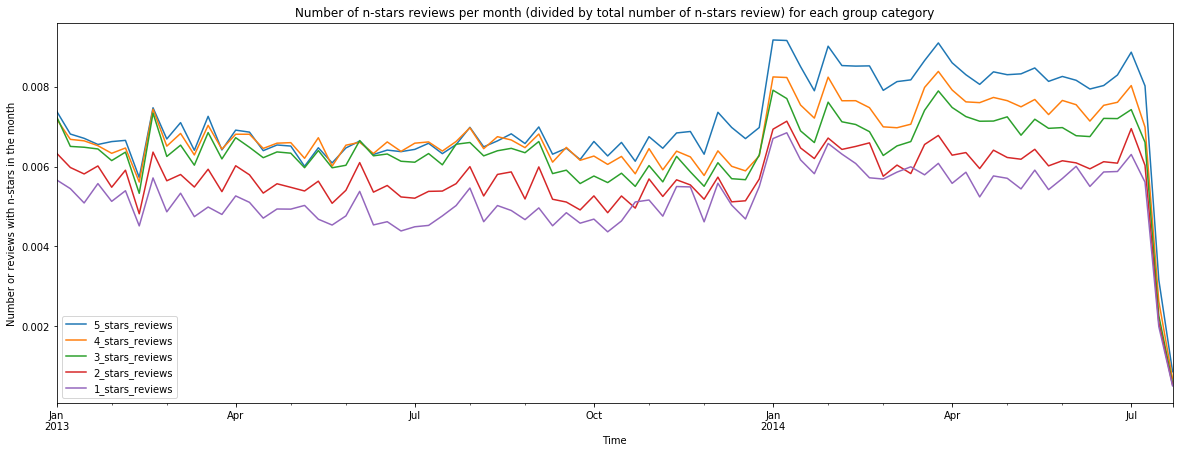

In [77]:
df_5_count_m = df_5.groupby(df_5.index.to_period('W')).count()
df_5_count_m = df_5_count_m.loc[ df_5_count_m.index >= '2013'][['asin']]/N5
df_4_count_m = df_4.groupby(df_4.index.to_period('W')).count()
df_4_count_m = df_4_count_m.loc[ df_4_count_m.index >= '2013'][['asin']]/N4
df_3_count_m = df_3.groupby(df_3.index.to_period('W')).count()
df_3_count_m = df_3_count_m.loc[ df_3_count_m.index >= '2013'][['asin']]/N3
df_2_count_m = df_2.groupby(df_2.index.to_period('W')).count()
df_2_count_m = df_2_count_m.loc[ df_2_count_m.index >= '2013'][['asin']]/N2
df_1_count_m = df_1.groupby(df_1.index.to_period('W')).count()
df_1_count_m = df_1_count_m.loc[ df_1_count_m.index >= '2013'][['asin']]/N1

df_5_count_m.columns=['5_stars_reviews']
df_4_count_m.columns=['4_stars_reviews']
df_3_count_m.columns=['3_stars_reviews']
df_2_count_m.columns=['2_stars_reviews']
df_1_count_m.columns=['1_stars_reviews']
stars_df_count_m = df_5_count_m.join(df_4_count_m).join(df_3_count_m).join(df_2_count_m).join(df_1_count_m)

stars_df_count_m.plot(figsize=(20,7))
plt.title('Number of n-stars reviews per month (divided by total number of n-stars review) for each group category')
plt.xlabel('Time')
plt.ylabel('Number or reviews with n-stars in the month')

The evolutions for all the 1,2,3,4 and 5 stars are very similar in time, there is no noticeable difference.

## Book categories distribution across book's classes

In this part we will look at which Amazon categories are most present in our classifications of good and bad books. 

In [258]:
reviews_df_10.head()

1  2  3   4    5  total      mean  median   std_dev  \
asin                                                              
000100039X  6  4  8  15  173    206  4.674757     5.0  0.873584   
0001055178  0  4  2  10    2     18  3.555556     4.0  0.955814   
0001473123  1  0  0   2   13     16  4.625000     5.0  0.992157   
0001473727  0  0  0   0    7      7  5.000000     5.0  0.000000   
0001473905  0  0  1   0    5      6  4.666667     5.0  0.745356   

           controversiality goodness  
asin                                  
000100039X          neutral     good  
0001055178          neutral      bad  
0001473123          neutral     good  
0001473727             none     none  
0001473905             none     none

In [259]:
books_with_categories.head()

author             brand  \
29335    Gillian Flynn             Crown   
68268  Suzanne Collins  Scholastic Press   
54647     Markus Zusak   Alfred A. Knopf   
58019     John Grisham      John Grisham   
68270  Suzanne Collins  Scholastic Press   

                                              categories  \
29335  [[Books, Mystery, Thriller & Suspense, Thrille...   
68268  [[Books, Children's Books, Science Fiction & F...   
54647  [[Books, Children's Books, Literature & Fictio...   
58019  [[Books, Mystery, Thriller & Suspense, Thrille...   
68270  [[Books, Teens, Literature & Fiction, Social &...   

                                                keywords  \
29335  [mystery fiction, wives, 030758836x, thrillers...   
68268  [science fiction, scholastic press, survival, ...   
54647  [holocaust, the book thief, historical, orphan...   
58019  [john grisham, political, suspense fiction, ra...   
68270  [science fiction, scholastic press, survival, ...   

                           publisher release_date  \
29335                          Crown   2012-06-05   
68268               Scholastic Press   2008-09-14   
54647  Knopf Books for Young Readers   2006-03-14   
58019       Random House Large Print   2013-10-22   
68270               Scholastic Press   2010-08-24   

                                             title    1    2     3  \
29335                                    Gone Girl  567  640  1209   
68268  The Hunger Games (The Hunger Games, Book 1)  129  134   344   
54647                               The Book Thief   81  109   274   
58019                                 Sycamore Row   50   91   360   
68270                Mockingjay (The Hunger Games)  184  298   607   

          ...           mean   Std_dev     Avg_len  first_review_date  \
29335     ...       3.834543  1.250125  455.739785         2012-03-25   
68268     ...       4.571684  0.835131  709.171952         2008-07-22   
54647     ...       4.588199  0.830168  482.175576         2006-02-16   
58019     ...       4.501955  0.809504  276.146612         2013-10-22   
68270     ...       4.131081  1.134602  720.243018         2010-03-03   

       number_of_reviews days_since_first_review  pop_metric_1  \
29335               7440                   850.0      8.752941   
68268               6717                  2192.0      3.064325   
54647               4864                  3079.0      1.579734   
58019               4604                   274.0     16.802920   
68270               4440                  1603.0      2.769807   

       pop_metric_2_date        asin pop_metric_2  
29335            2013-03  030758836X       1564.0  
68268            2013-02  0439023483        981.0  
54647            2014-02  0375831002       1882.0  
58019            2014-01  038536315X       2566.0  
68270            2013-03  0439023513        793.0  

[5 rows x 22 columns]

In [260]:
books_with_categories_class = pd.merge(books_with_categories, reviews_df_10[['controversiality', 'goodness']], left_on='asin', right_index=True)

In [261]:
books_with_categories_class.head()

author             brand  \
29335    Gillian Flynn             Crown   
68268  Suzanne Collins  Scholastic Press   
54647     Markus Zusak   Alfred A. Knopf   
58019     John Grisham      John Grisham   
68270  Suzanne Collins  Scholastic Press   

                                              categories  \
29335  [[Books, Mystery, Thriller & Suspense, Thrille...   
68268  [[Books, Children's Books, Science Fiction & F...   
54647  [[Books, Children's Books, Literature & Fictio...   
58019  [[Books, Mystery, Thriller & Suspense, Thrille...   
68270  [[Books, Teens, Literature & Fiction, Social &...   

                                                keywords  \
29335  [mystery fiction, wives, 030758836x, thrillers...   
68268  [science fiction, scholastic press, survival, ...   
54647  [holocaust, the book thief, historical, orphan...   
58019  [john grisham, political, suspense fiction, ra...   
68270  [science fiction, scholastic press, survival, ...   

                           publisher release_date  \
29335                          Crown   2012-06-05   
68268               Scholastic Press   2008-09-14   
54647  Knopf Books for Young Readers   2006-03-14   
58019       Random House Large Print   2013-10-22   
68270               Scholastic Press   2010-08-24   

                                             title    1    2     3   ...     \
29335                                    Gone Girl  567  640  1209   ...      
68268  The Hunger Games (The Hunger Games, Book 1)  129  134   344   ...      
54647                               The Book Thief   81  109   274   ...      
58019                                 Sycamore Row   50   91   360   ...      
68270                Mockingjay (The Hunger Games)  184  298   607   ...      

          Avg_len  first_review_date  number_of_reviews  \
29335  455.739785         2012-03-25               7440   
68268  709.171952         2008-07-22               6717   
54647  482.175576         2006-02-16               4864   
58019  276.146612         2013-10-22               4604   
68270  720.243018         2010-03-03               4440   

       days_since_first_review  pop_metric_1 pop_metric_2_date        asin  \
29335                    850.0      8.752941           2013-03  030758836X   
68268                   2192.0      3.064325           2013-02  0439023483   
54647                   3079.0      1.579734           2014-02  0375831002   
58019                    274.0     16.802920           2014-01  038536315X   
68270                   1603.0      2.769807           2013-03  0439023513   

       pop_metric_2  controversiality goodness  
29335        1564.0     controversial      bad  
68268         981.0           neutral  neutral  
54647        1882.0           neutral     good  
58019        2566.0           neutral  neutral  
68270         793.0     controversial  neutral  

[5 rows x 24 columns]

In [263]:
cross_terms = pd.DataFrame(index=["good", "neutral", "bad"])
cross_terms = cross_terms.assign(uncontroversial=-1)
cross_terms = cross_terms.assign(neutral=-1)
cross_terms = cross_terms.assign(controversial=-1)

for goodvalue in ["good", "bad", "neutral"]:
    for controvalue in ["uncontroversial", "controversial", "neutral"]:
        cross_terms[controvalue][goodvalue] = len(
            books_with_categories_class.query(
                'goodness=="' + goodvalue + '" and controversiality=="' +
                controvalue + '"'))
cross_terms

uncontroversial  neutral  controversial
good                2499     1960              0
neutral              425    12946           1779
bad                    2     1770           4180

In [353]:
books_bad = books_with_categories_class[books_with_categories_class['goodness'] == 'bad']
books_good = books_with_categories_class[books_with_categories_class['goodness'] == 'good']
books_contr = books_with_categories_class[books_with_categories_class['controversiality'] == 'controversial']
books_uncontr = books_with_categories_class[books_with_categories_class['controversiality'] == 'uncontroversial']

In [264]:
# First level category
def first_level_categories(df):
    first_level_cat = df['categories'].apply(
        lambda x: list(set([lists[1] for lists in x if len(lists) > 1])))
    first_level_cat_frequency = dict(Counter(first_level_cat.sum()))
    sorted_first_level_cat_frequency = sorted(
        first_level_cat_frequency.items(),
        key=operator.itemgetter(1),
        reverse=True)
    return sorted_first_level_cat_frequency[:10]

In [357]:
plt.rcdefaults()
font = {'size' : 10}
plt.rc('font', **font)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [362]:
def category_plot(category_list, title, filename):
    # save the names and their respective scores separately
    # reverse the tuples to go from most frequent to least frequent
    category = [item[0] for item in category_list]
    score = [item[1] for item in category_list]
    x_pos = np.flip(np.arange(len(category)), axis=0)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.barh(x_pos, score, align='center')
    ax.set_yticks(x_pos)
    ax.set_yticklabels(category)
    ax.set_xlabel('Number of entries')
    ax.set_title(title)
    plt.savefig('./images/' + filename + "_categories.png", transparent=True)
    plt.show()

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


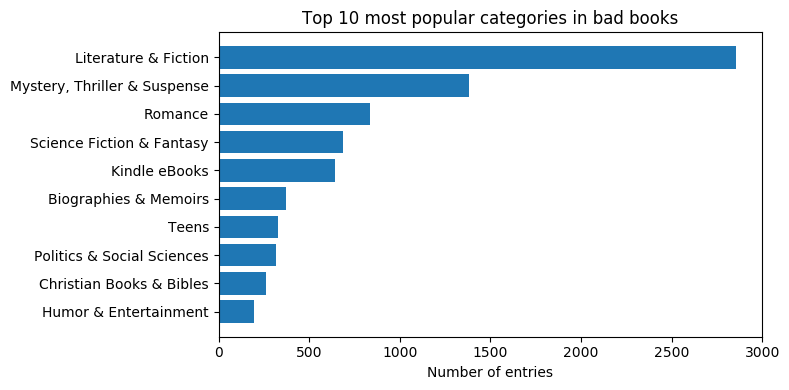

In [363]:
category_plot(
    first_level_categories(books_bad),
    "Top 10 most popular categories in bad books", 'bad_books')

In the bad books we classified, the three more common categories are Literature & Fiction, Mystery Thriller & Suspense and Romance. 

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


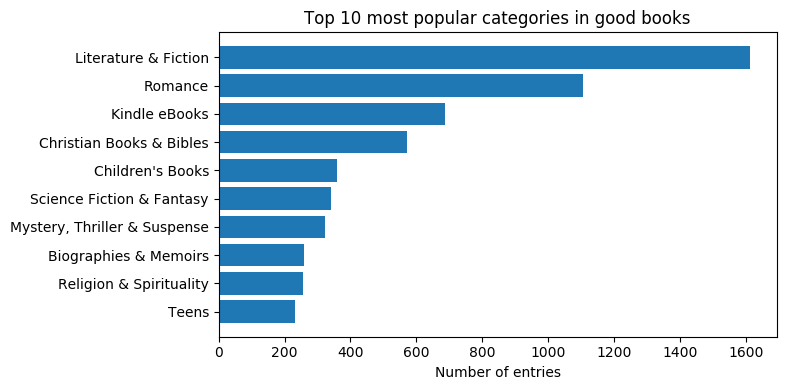

In [364]:
category_plot(
    first_level_categories(books_good),
    "Top 10 most popular categories in good books", 'good_books')

In the good books we classified, the three more common categories are Literature & Fiction, Romance and the Kindle eBooks. 

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


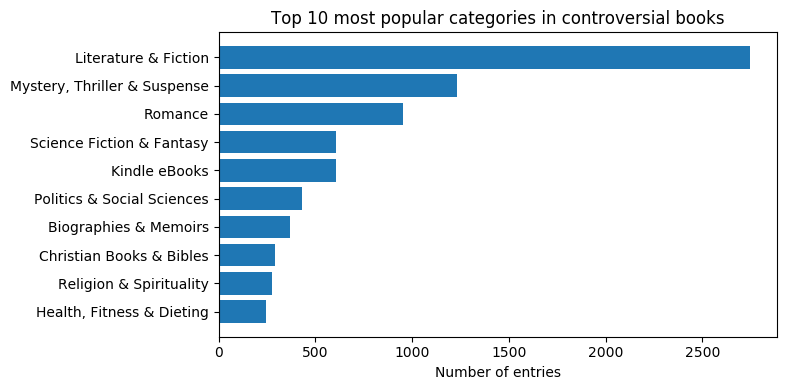

In [365]:
category_plot(
    first_level_categories(books_contr),
    "Top 10 most popular categories in controversial books", 'books_contr')

In the good books we classified, the three more common categories are Literature & Fiction, Mystery, Thriller & Suspence and Romance as for bad books.

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


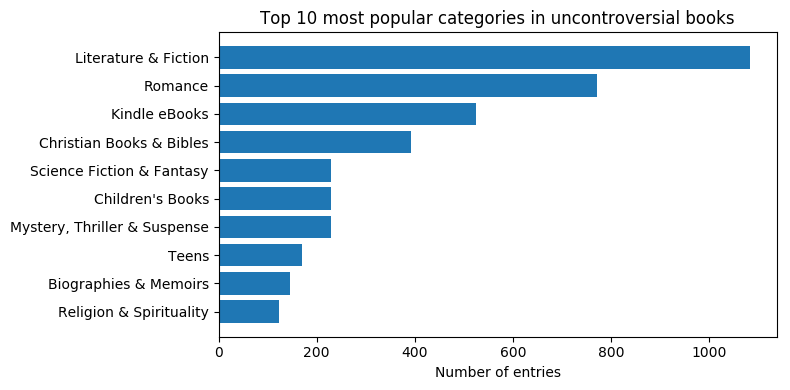

In [366]:
category_plot(
    first_level_categories(books_uncontr),
    "Top 10 most popular categories in uncontroversial books", 'books_uncontr')

In [302]:
first_level_categories(books_bad)

[('Literature & Fiction', 2857),
 ('Mystery, Thriller & Suspense', 1383),
 ('Romance', 837),
 ('Science Fiction & Fantasy', 684),
 ('Kindle eBooks', 643),
 ('Biographies & Memoirs', 373),
 ('Teens', 329),
 ('Politics & Social Sciences', 316),
 ('Christian Books & Bibles', 263),
 ('Humor & Entertainment', 193)]

# Sentiment analysis

In this part we will use the Vader sentiment analysis algorithm to analyse the positiveness and negativeness of the reviews of books. We will compute the compound score for each books (score between -1 and 1 where -1 is very negative and 1 is very positive). We will then compare this to the ratings we have associated with the review to see if high rated review are classified as positive reviews for example. This will tell you whether the vader model is consistent and if people consistently review positively when they put a high rating.  

## Data collection using Apache Spark and VADER model (nltk)

In [ ]:
# Initialization of VADER model
sid = SentimentIntensityAnalyzer()

In [ ]:
# Create Spark context if it is not running
sc = SparkContext()
sqlContext = SQLContext(sc)

In [ ]:
# Loading file with reviews
text_file = sc.textFile("/media/adam/B236CB1D36CAE209/Studia/ADA/reviews_Books_5.json")
df = sqlContext.read.json(text_file)

In [ ]:
# Data transformation
df = df.withColumn('unixReviewTime', from_unixtime(df['unixReviewTime']))
df = df.withColumn('reviewTime', to_date(df['unixReviewTime']))
df = df.withColumn('unixReviewTime', df['unixReviewTime'].cast('timestamp'))

In [ ]:
# Function to apply on each row of the data - compute the sentiment score for each review
def sentiment_f(row):
    rew = sid.polarity_scores(row.reviewText)
    summ = sid.polarity_scores(row.summary)
    return (row.asin, row.unixReviewTime, row.reviewerID, row.overall,
            rew['compound'], rew['neg'], rew['neu'], rew['pos'],
            summ['compound'], summ['neg'], summ['neu'], summ['pos'])

In [ ]:
# Transform and collect the data about sentiment
sentiment = df.select("asin", "reviewText", "summary", "unixReviewTime",
                      'overall', "reviewerID").rdd.map(sentiment_f).collect()

In [19]:
sentiment_df = pd.DataFrame(sentiment, columns=['asin', 'unixReviewTime', 'reviewerID', 'overall', 'rew_compound', 'rew_neg', 'rew_neu', 'rew_pos',
           'summ_compound', 'summ_neg', 'summ_neu', 'summ_pos'])
sentiment_df.head()

asin      unixReviewTime      reviewerID  overall  rew_compound  \
0  B009UMF4KA 2013-02-20 01:00:00  A24RY39KA1P8K0      1.0       -0.9293   
1  B009UMF4KA 2013-02-18 01:00:00   AA1HAXGZ8A6OZ      3.0        0.8159   
2  B009UMF4KA 2013-06-30 02:00:00  A31EPS36AHUBF9      5.0        0.9020   
3  B009UMF4KA 2013-01-30 01:00:00  A33LSPIIUUBVBY      4.0        0.4927   
4  B009UMF4KA 2013-03-17 01:00:00  A20EFEJWLMIXRT      3.0       -0.6887   

   rew_neg  rew_neu  rew_pos  summ_compound  summ_neg  summ_neu  summ_pos  
0    0.275    0.668    0.056         0.0000     0.000     1.000     0.000  
1    0.042    0.841    0.117         0.0000     0.000     1.000     0.000  
2    0.000    0.591    0.409         0.4588     0.000     0.571     0.429  
3    0.145    0.670    0.185         0.4404     0.000     0.256     0.744  
4    0.100    0.839    0.061        -0.4019     0.383     0.426     0.191

In [ ]:
# Save collected data
sentiment_df.to_csv("sentiment.csv", index=False)

In [ ]:
# Stop Spark context
sc.stop()

## Comparison of sentiment with ratings

In [3]:
# Read the files and create a dataframe grouped by books 
df = pd.read_csv('data/sentiment_01.csv')

In [4]:
by_book = df.groupby(['asin']).mean()
by_book.head()

overall  rew_compound   rew_neg   rew_neu   rew_pos  \
asin                                                               
000100039X  4.674757      0.778295  0.030427  0.775301  0.194252   
0001055178  3.555556      0.215511  0.085778  0.808722  0.105556   
0001473123  4.625000      0.762069  0.015000  0.728313  0.256625   
0001473727  5.000000      0.706571  0.018714  0.743286  0.237857   
0001473905  4.666667      0.724667  0.019333  0.843667  0.137000   

            summ_compound  summ_neg  summ_neu  summ_pos  
asin                                                     
000100039X       0.277660  0.012772  0.649024  0.338209  
0001055178      -0.012039  0.076000  0.881444  0.042556  
0001473123       0.175725  0.014875  0.726688  0.258437  
0001473727       0.171843  0.022429  0.833429  0.144143  
0001473905       0.150833  0.000000  0.819667  0.180333

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


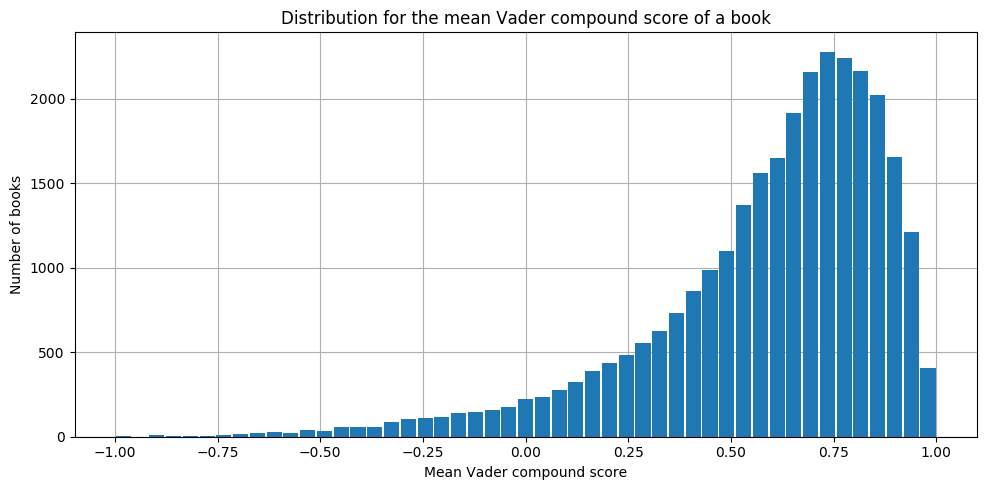

In [426]:
#Plot a histogram 
fig, ax = plt.subplots(figsize=(10,5), ncols=1, nrows=1)

by_book.rew_compound.hist(bins=np.linspace(-1,1,50), rwidth=0.9)

plt.title('Distribution for the mean Vader compound score of a book')
plt.xlabel('Mean Vader compound score')
plt.ylabel('Number of books')
plt.savefig('./images/Distribution_mean_Vader_compound_book.png', transparent=True)
plt.show()

It looks like the same skewness (as we had with the reviews ratings before) in the positivness of the comments can be seen with the Vader analysis. Let's check if it is the case for the other files as well

In [6]:
def plot_histo(x):
    df = pd.read_csv('data/sentiment_0' + str(x) + '.csv')
    by_book = df.groupby(['asin']).mean()

    #Plot a histogram
    fig, ax = plt.subplots(figsize=(15, 7), ncols=1, nrows=1)

    by_book.rew_compound.hist(bins=np.linspace(-1, 1, 50), rwidth=0.9)

    plt.title('Distribution for the mean Vader compound score of a book')
    plt.xlabel('Mean Vader compound score')
    plt.ylabel('Number of books')

In [7]:
#Put everything together in one dataframe
def create_dataf():
    df = pd.read_csv('data/sentiment_01.csv')
    total_df = df.groupby(['asin']).mean()
    for x in range(2, 10):
        df = pd.read_csv('data/sentiment_0' + str(x) + '.csv')
        by_book = df.groupby(['asin']).mean()
        tot = total_df.copy()
        total_df = pd.concat([tot, by_book])
    return (total_df)

In [8]:
total_df = create_dataf()

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


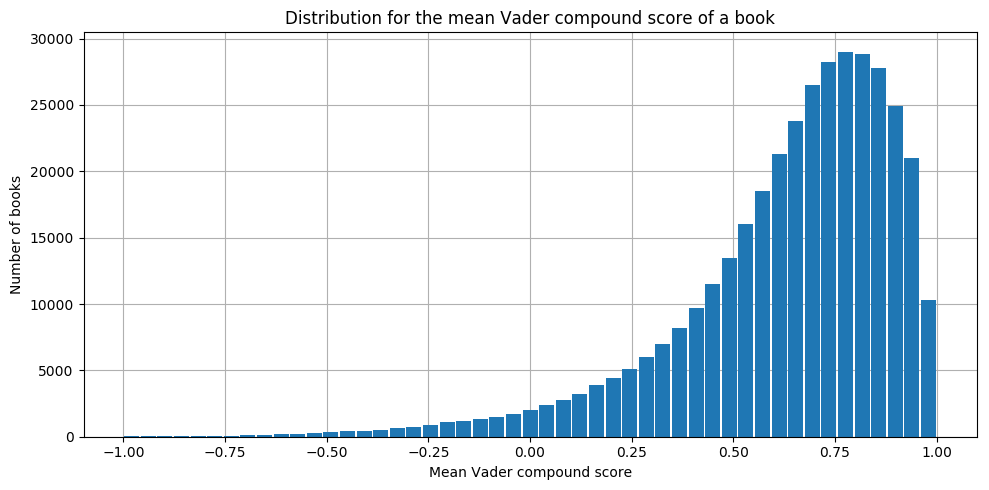

In [427]:
#Plot a histogram
fig, ax = plt.subplots(figsize=(10, 5), ncols=1, nrows=1)

total_df.rew_compound.hist(bins=np.linspace(-1, 1, 50), rwidth=0.9)

plt.title('Distribution for the mean Vader compound score of a book')
plt.xlabel('Mean Vader compound score')
plt.ylabel('Number of books')
plt.savefig(
    './images/Distribution_mean_Vader_compound_score_book.png',
    transparent=True)
#plt.xticks([1,2,3,4,5])

Taking all the comments we have and putting them into the vader programm and then plotting the mean of the compound score for each book gives a very similar plot (left skewed) to the one we drew before with the number of 1,2,3,4 and 5 stars for each book. 

Let's now try to compare the value for the compound score to the ratings score we normalized before. 

In [17]:
#recall the first table we got with the ratings
complete_books_df.head()

1  2  3   4    5      mean   Std_dev      Avg_len first_review_date  \
0  6  4  8  15  173  4.674757  0.873584   638.033981        2000-02-20   
1  0  4  2  10    2  3.555556  0.955814  1308.611111        1998-12-13   
2  1  0  0   2   13  4.625000  0.992157   287.937500        2009-11-27   
3  0  0  0   0    7  5.000000  0.000000   187.571429        2011-06-02   
4  0  0  1   0    5  4.666667  0.745356   481.833333        2009-04-19   

   number_of_reviews  days_since_first_review  pop_metric_1 pop_metric_2_date  \
0                206                   5267.0      0.039111           2014-01   
1                 18                   5701.0      0.003157           2000-03   
2                 16                   1699.0      0.009417           2013-02   
3                  7                   1147.0      0.006103           2014-03   
4                  6                   1921.0      0.003123           2013-02   

         asin  pop_metric_2  
0  000100039X          19.0  
1  0001055178           4.0  
2  0001473123           4.0  
3  0001473727           3.0  
4  0001473905           3.0

In [18]:
total_df['asin'] = total_df.index
total_df.head()

overall  rew_compound   rew_neg   rew_neu   rew_pos  \
asin                                                               
000100039X  4.674757      0.778295  0.030427  0.775301  0.194252   
0001055178  3.555556      0.215511  0.085778  0.808722  0.105556   
0001473123  4.625000      0.762069  0.015000  0.728313  0.256625   
0001473727  5.000000      0.706571  0.018714  0.743286  0.237857   
0001473905  4.666667      0.724667  0.019333  0.843667  0.137000   

            summ_compound  summ_neg  summ_neu  summ_pos        asin  
asin                                                                 
000100039X       0.277660  0.012772  0.649024  0.338209  000100039X  
0001055178      -0.012039  0.076000  0.881444  0.042556  0001055178  
0001473123       0.175725  0.014875  0.726688  0.258437  0001473123  
0001473727       0.171843  0.022429  0.833429  0.144143  0001473727  
0001473905       0.150833  0.000000  0.819667  0.180333  0001473905

In [19]:
compare_df = pd.merge(complete_books_df, total_df, how='inner', on=['asin'])

In [24]:
#calculate the values of ratings to be between -1 and 1
compare_df['norm_mean'] = ((1 - (-1)) / (5 - 1)) * (compare_df['mean'] - 5) + 1

In [25]:
#compare the difference between ratings and vader
compare_df['comparison'] = compare_df.norm_mean - compare_df.rew_compound

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


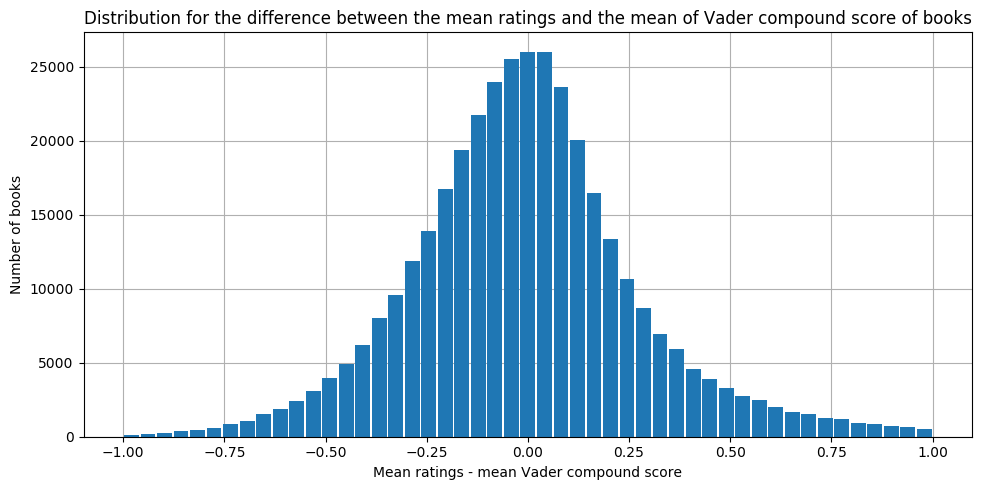

In [428]:
#plot the difference
fig, ax = plt.subplots(figsize=(10, 5), ncols=1, nrows=1)

compare_df.comparison.hist(bins=np.linspace(-1, 1, 50), rwidth=0.9)

plt.title(
    'Distribution for the difference between the mean ratings and the mean of Vader compound score of books'
)
plt.xlabel('Mean ratings - mean Vader compound score')
plt.ylabel('Number of books')
plt.savefig(
    './images/Distribution_difference_mean_ratings_mean_Vader_compound_books.png',
    transparent=True)

This is a very good result as it shows that vader is very close to the ratings for a majority of cases as the plot is centered on 0 and the two right and left parts are very small quite fast. This means that the Vader model is consistent with the ratings we have for our comments and associate "positive" comments to high rated comments and "negative" comments to low rated comments.

# Time analysis

In this category we will have a look at our metrics (number of reviews, mean ratings etc...) and their evolution in time. 

## Average rating and Vader compound score comparison over time

In [2]:
df0 = pd.read_csv('data/sentiment_01.csv')

In [3]:
del df0['rew_neg']
del df0['rew_neu']
del df0['rew_pos']
del df0['summ_neg']
del df0['summ_compound']
del df0['summ_neu']
del df0['summ_pos']

In [4]:
df0.head()

asin       unixReviewTime             reviewerID  overall  \
0  000100039X  2012-12-16 01:00:00  A10000012B7CGYKOMPQ4L      5.0   
1  000100039X  2003-12-11 01:00:00         A2S166WSCFIFP5      5.0   
2  000100039X  2014-01-18 01:00:00         A1BM81XB4QHOA3      5.0   
3  000100039X  2011-09-27 02:00:00         A1MOSTXNIO5MPJ      5.0   
4  000100039X  2002-10-07 02:00:00         A2XQ5LZHTD4AFT      5.0   

   rew_compound  
0        0.7256  
1        0.8349  
2        0.4404  
3        0.9201  
4        0.9800

In this table, the asin is the Amazon code for a special book. Each line correspond to a review where the asin is the book reviewed, the unixReviewTime is the time at which the comment was posted, the reviewerID is the ID of the reviewer, the overall score is the rating given by the user with the comment and the rew_compound is the Vader score calculated by inputting the review in the Vader sentimental analysis algorithm. 

In [387]:
def create_tot_dataf () : 
    df0 = pd.read_csv('data/sentiment_01.csv')
    #transform the time to a time easily handled with pandas
    df0.index = df0.unixReviewTime.astype('datetime64[ns]')
    #delete the columns not needed
    del df0['rew_neg']
    del df0['rew_neu']
    del df0['rew_pos']
    del df0['summ_neg']
    del df0['summ_compound']
    del df0['summ_neu']
    del df0['summ_pos']
    total_df = df0
    for x in range(2,10):
        df0 = pd.read_csv('data/sentiment_0'+str(x)+'.csv')
        df0.index = df0.unixReviewTime.astype('datetime64[ns]')
        del df0['rew_neg']
        del df0['rew_neu']
        del df0['rew_pos']
        del df0['summ_neg']
        del df0['summ_compound']
        del df0['summ_neu']
        del df0['summ_pos']
        tot = total_df.copy()
        total_df = pd.concat([tot, df0])
    return(total_df)

In [388]:
#create a table with all information
tot_df = create_tot_dataf()
tot_df.head()

asin       unixReviewTime             reviewerID  \
unixReviewTime                                                                
2012-12-16 01:00:00  000100039X  2012-12-16 01:00:00  A10000012B7CGYKOMPQ4L   
2003-12-11 01:00:00  000100039X  2003-12-11 01:00:00         A2S166WSCFIFP5   
2014-01-18 01:00:00  000100039X  2014-01-18 01:00:00         A1BM81XB4QHOA3   
2011-09-27 02:00:00  000100039X  2011-09-27 02:00:00         A1MOSTXNIO5MPJ   
2002-10-07 02:00:00  000100039X  2002-10-07 02:00:00         A2XQ5LZHTD4AFT   

                     overall  rew_compound  
unixReviewTime                              
2012-12-16 01:00:00      5.0        0.7256  
2003-12-11 01:00:00      5.0        0.8349  
2014-01-18 01:00:00      5.0        0.4404  
2011-09-27 02:00:00      5.0        0.9201  
2002-10-07 02:00:00      5.0        0.9800

In [389]:
#Groupe by month and take the mean rating and mean vader compound score of reviews 
tot_df_m = tot_df.groupby(tot_df.index.to_period('M')).mean()
tot_df_m.head()

overall  rew_compound
unixReviewTime                        
1996-05         4.000000     -0.815600
1996-06         1.000000     -0.894300
1996-08         5.000000      0.986800
1996-09         5.000000      0.973200
1996-11         3.666667      0.506483

In [394]:
#Before 2000 there are not many reviews so it's not very representative
tot_df_sh = tot_df_m.loc[tot_df_m.index>=1999]

In [395]:
tot_df_sh.head()

overall  rew_compound
unixReviewTime                        
1999-01         4.113985      0.577268
1999-02         4.141039      0.567280
1999-03         4.202358      0.555608
1999-04         4.252669      0.579375
1999-05         4.203098      0.586352

In [396]:
#calculate the values of ratings to be between -1 and 1 
tot_df_sh['scaled_rat'] = ((1- (-1))/(5-1))*(tot_df_sh.overall-5)+1

/home/adam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


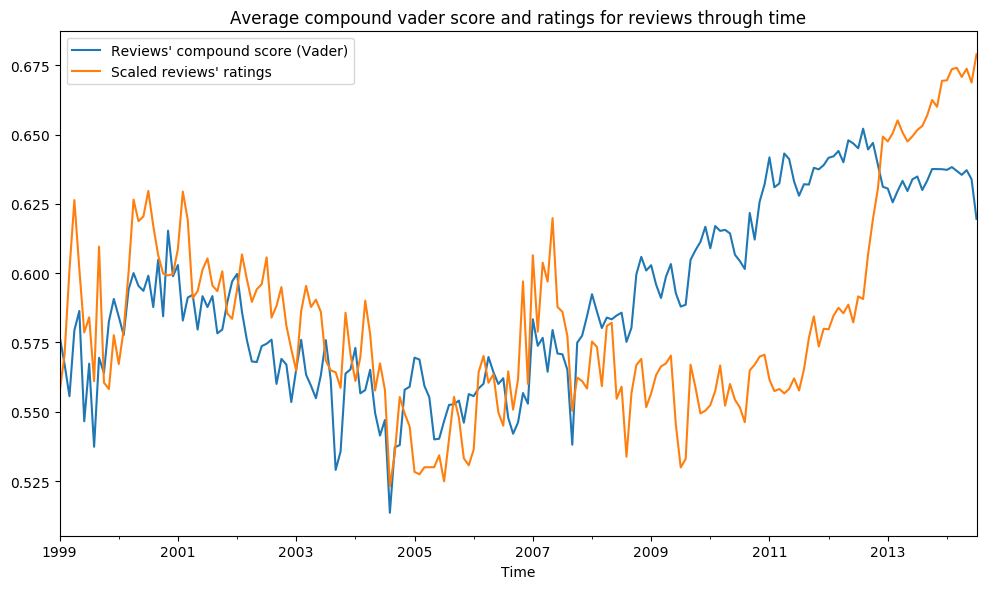

In [404]:
#show the vader compound score and scaled ratings evolution by month
tot_df_sh[['rew_compound','scaled_rat']].plot(figsize=(10,6))
plt.title("Average compound vader score and ratings for reviews through time")
plt.xlabel("Time")
plt.legend(['Reviews\' compound score (Vader)', 'Scaled reviews\' ratings'])
plt.savefig('./images/Average compound vader score and ratings for reviews through time.png', transparent=True)
plt.show()

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


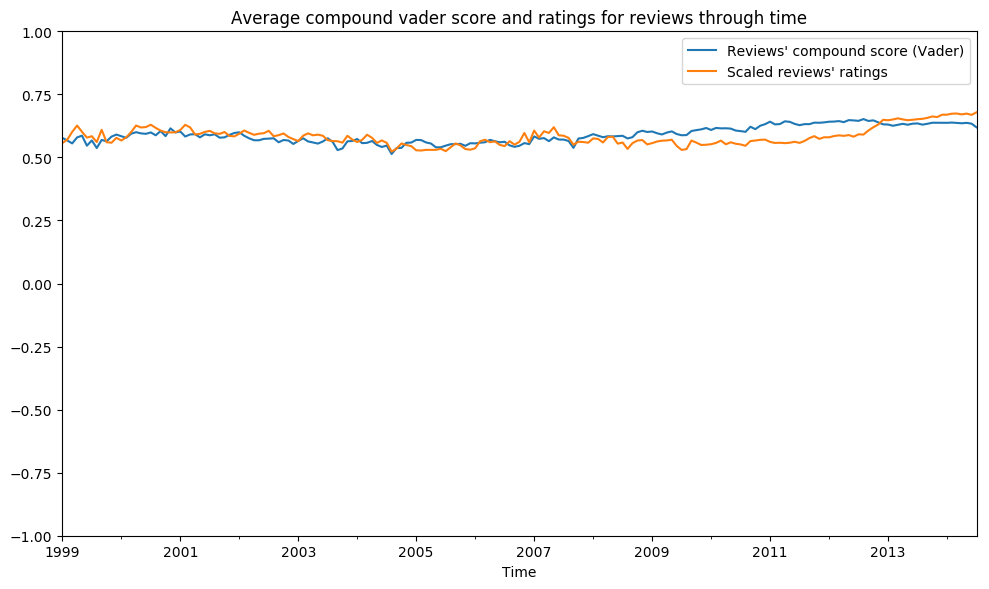

In [405]:
#show the vader compound score and scaled ratings evolution by month
tot_df_sh[['rew_compound','scaled_rat']].plot(figsize=(10,6))
plt.ylim([-1,1])
plt.title("Average compound vader score and ratings for reviews through time")
plt.xlabel("Time")
plt.legend(['Reviews\' compound score (Vader)', 'Scaled reviews\' ratings'])
plt.savefig('./images/Average compound vader score and ratings for reviews through time2.png', transparent=True)
plt.show()

Again we see here that the compound score given by Vader is very close to the ratings associated with the review. We notice that in 2009 the two lines get further from each other: the compound score seems to get higher than the associated rating so people would have commented more positively than the number of stars they put with their comment. In 2013, the compound line gets lower again. 

## Average number of ratings for each month - year to year comparison

In [430]:
#focus on number of reviews per month through years 
df = tot_df.groupby([tot_df.index.map(lambda t: t.year),tot_df.index.map(lambda t: t.month)]).count()[['asin']]

In [431]:
df.index.names = ['year','month']
df.head()

asin
year month      
1996 5         1
     6         1
     8         1
     9         1
     11        6

In [432]:
df2 = df.unstack(level = 0)

In [433]:
#divide by total number of reviews per year for each year
df3 = df2 / df2.sum(axis = 0)

In [434]:
df3.columns = df3.columns.droplevel(level=0)

/home/adam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


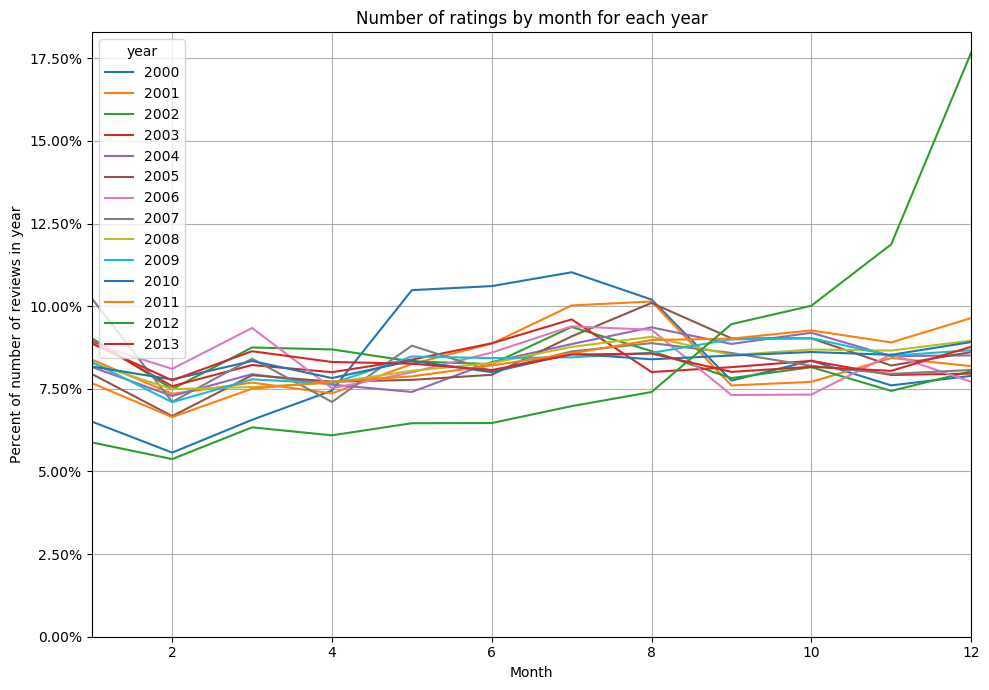

In [445]:
ax = df3.iloc[:, 4:-1].plot(figsize=(10,7))
plt.grid()
plt.ylim(ymin = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.ylabel("Percent of number of reviews in year")
plt.xlabel("Month")
plt.title("Number of ratings by month for each year")
plt.savefig("./images/number_of_ratings_stacked2.png", transparency=True)
plt.show()

The line for 2012 shows again that something happened to the Amazon website this year. The other lines show a pattern for the number of reviews each month: a drop can be seen in February which can be explained by the fact that people get books for christmas and review them around January and then in February nothing special happens. An increase can be seen also between april and august where people are in holiday so they have more time to read and review the books.

In [196]:
tot_df['Year'] = tot_df.index.map(lambda t: t.year)

In [10]:
#focus on mean rating and mean vader compound through years
grouped_df = tot_df.groupby(tot_df.index.map(lambda t: t.year)).mean()
grouped_df.head()

overall  rew_compound  Year
unixReviewTime                              
1996            4.280000      0.245924  1996
1997            4.250367      0.507452  1997
1998            4.220532      0.573459  1998
1999            4.157556      0.572835  1999
2000            4.216561      0.594990  2000

In [199]:
mean_rats  = grouped_df [['overall']]
mean_rats = mean_rats.unstack(level = 0)
mean_rats.columns = mean_rats.columns.droplevel(level=0)
mean_comp = grouped_df[['rew_compound']]
mean_comp = mean_comp.unstack(level = 0)
mean_comp.columns = mean_comp.columns.droplevel(level=0)


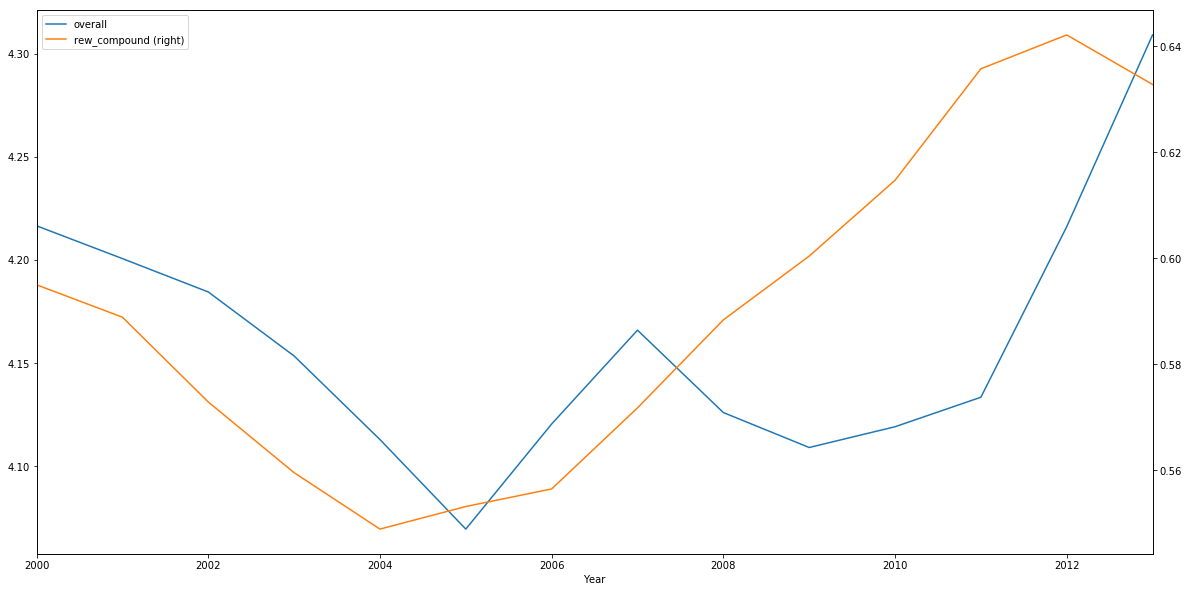

In [15]:
grouped_df.iloc[4:-1, :].plot(x ='Year', y=['overall','rew_compound'], secondary_y=['rew_compound'], figsize = (20,10))

Text(0.5,1,'Mean ratings of reviews through years')

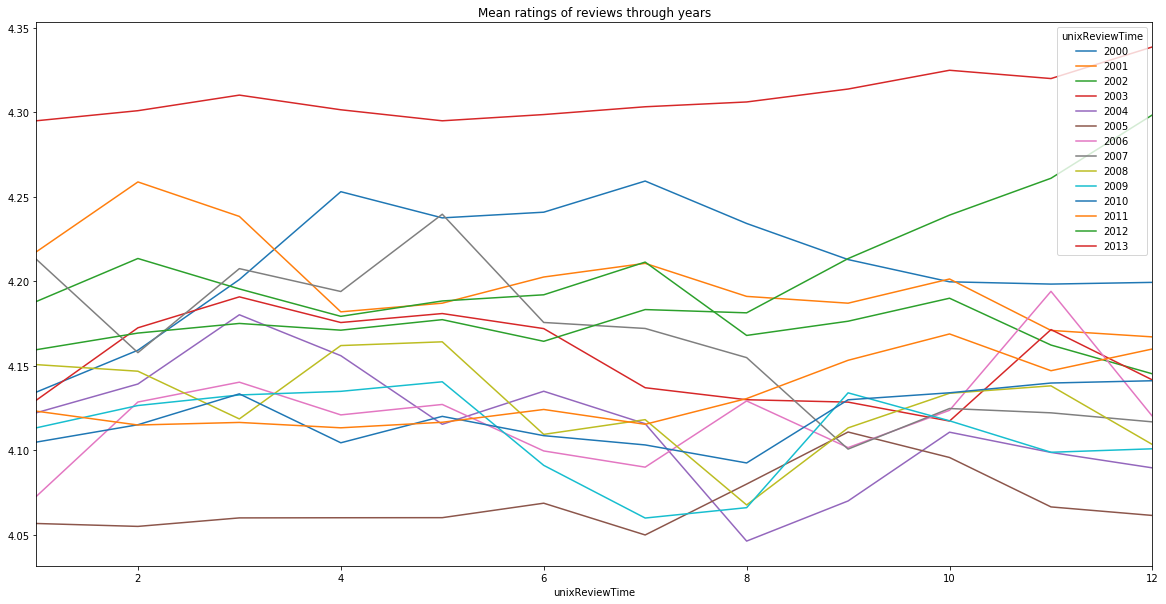

In [200]:
#we don't account for the first years where we don't have many reviews and the last year 2014 that is not complete
mean_rats.iloc[:, 4:-1].plot(figsize = (20,10))
plt.title("Mean ratings of reviews through years")

Text(0.5,1,'Average vador compound score of reviews through years')

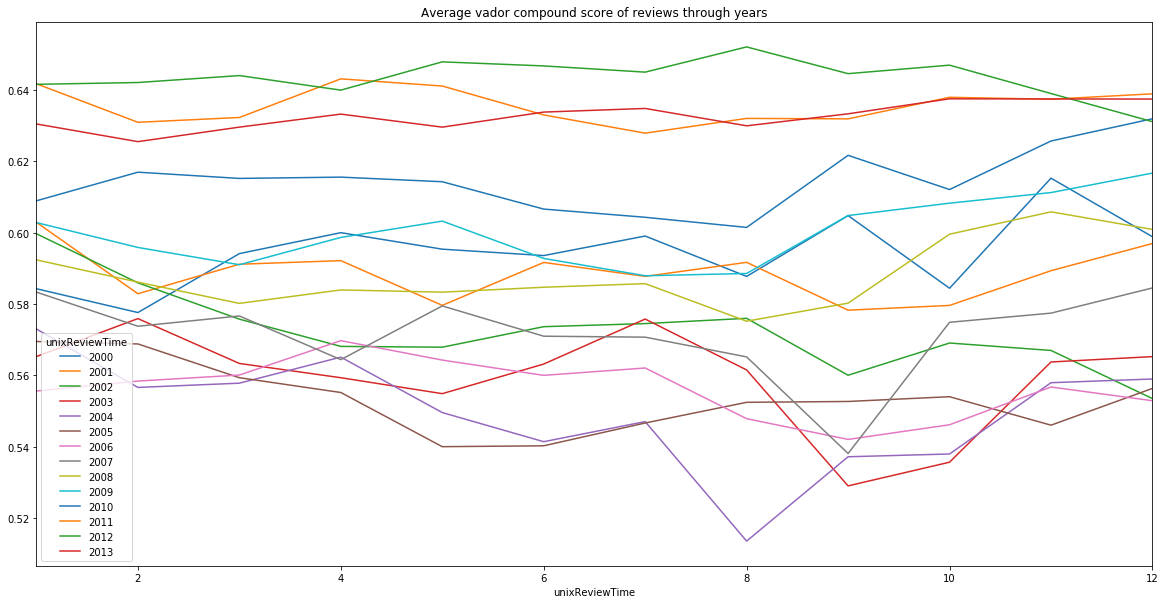

In [201]:
mean_comp.iloc[:, 4:-1].plot(figsize = (20,10))
plt.title("Average vador compound score of reviews through years")

With the first plot, we can see that the mean ratings went up from 2005 to 2013. 

# Finale
This notebook was very long and filled with different explorations of the data. Only part made it to the final data story to avoid overwhelming the reader with information. For the future steps: we will use the data story as a basis for the poster and presentation at the Applied Machine Learning Days.

Thank you for reading!